In [1]:
# load librairies
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
from os.path import join
import seaborn as sns
import scipy
import json


from functions import utils

# 1. Load subjects #

In [30]:
included_subjects = [
    'preop001 mSST', 

    'C002 mSST', 'C003 mSST', 'C004 mSST', 'C006 mSST', 
    
    'sub006 DBS ON mSST', 'sub006 DBS OFF mSST', 
    'sub007 DBS OFF mSST', 
    'sub008 DBS ON mSST', 'sub008 DBS OFF mSST', 
    'sub009 DBS ON mSST', 'sub009 DBS OFF mSST', 
    'sub011 DBS OFF mSST', 'sub011 DBS ON mSST', 
    'sub012 DBS ON mSST', 
    'sub013 DBS OFF mSST', 
    'sub014 DBS ON mSST', 
    'sub015 DBS OFF mSST', 'sub015 DBS ON mSST', 
    'sub017 DBS ON mSST',  'sub017 DBS OFF mSST', 
    'sub019 DBS ON mSST', 'sub019 DBS OFF mSST', 
    'sub020 DBS ON mSST', 
    'sub021 DBS OFF mSST', 'sub021 DBS ON mSST', 
    'sub022 DBS ON mSST', 
    'sub023 DBS OFF mSST', 'sub023 DBS ON mSST',
    'sub024 DBS ON mSST', 'sub024 DBS OFF mSST'
    ]

excluded_subjects = []

In [31]:
onedrive_path = utils._get_onedrive_path()
working_path = os.path.dirname(os.getcwd())
results_path = join(working_path, "results")
behav_results_saving_path = join(results_path, "behav_results")
if not os.path.isdir(behav_results_saving_path):
    os.makedirs(behav_results_saving_path)

In [32]:
# load data by looping through the subjects
data = {}
for subject in included_subjects:
    if subject.startswith('sub'):
        subject_ID, na, condition, task = subject.split(' ')
        sub_onedrive_path = join(onedrive_path, subject_ID)
        sub_onedrive_path_raw = join(sub_onedrive_path, 'raw_data')
        sub_onedrive_path_behav = join(sub_onedrive_path_raw, 'BEHAVIOR')
        sub_onedrive_path_condition = join(sub_onedrive_path_behav, (na + ' ' + condition))
        sub_onedrive_path_task = join(sub_onedrive_path_condition, task)
        behav_filename = [f for f in os.listdir(sub_onedrive_path_task) if f.endswith('.csv')]
        filepath = join(sub_onedrive_path_task, behav_filename[0])
        df = pd.read_csv(filepath)
        
    elif subject.startswith('C'):
        subject_ID, task = subject.split(' ')
        sub_onedrive_path = join(onedrive_path, subject_ID)
        sub_onedrive_path_raw = join(sub_onedrive_path, 'raw_data')
        sub_onedrive_path_behav = join(sub_onedrive_path_raw, 'BEHAVIOR')
        sub_onedrive_path_task = join(sub_onedrive_path_behav, task)
        behav_filename = [f for f in os.listdir(sub_onedrive_path_task) if f.endswith('.csv')]
        filepath = join(sub_onedrive_path_task, behav_filename[0])
        df = pd.read_csv(filepath)
    
    elif subject.startswith('preop'):
        subject_ID, task = subject.split(' ')
        sub_onedrive_path = join(onedrive_path, subject_ID)
        sub_onedrive_path_raw = join(sub_onedrive_path, 'raw_data')
        sub_onedrive_path_behav = join(sub_onedrive_path_raw, 'BEHAVIOR')
        sub_onedrive_path_behav_preop = join(sub_onedrive_path_behav, 'PRE OP')
        sub_onedrive_path_task = join(sub_onedrive_path_behav_preop, task)
        behav_filename = [f for f in os.listdir(sub_onedrive_path_task) if f.endswith('.csv')]
        filepath = join(sub_onedrive_path_task, behav_filename[0])
        df = pd.read_csv(filepath)        

    data[subject] = df

In [33]:
color_dict = {
    'dbs_off': '#20a39e', 
    'dbs_on': '#ef5b5b', 
    'control': '#ffba49', 
    'preop': '#8E7DBE'
    }


# 2. Extract main statistics and values for each subject and compile in a dictionnary #

In [34]:
stats = utils.extract_stats(data)

results_dict = {}
# create subdictionnaries for each subject:
for subject in included_subjects:
    results_dict[subject] = {}

In [35]:
# If no file was found, create a new JSON file
filename = "stats.json"
file_path = os.path.join(results_path, filename)
#if not os.path.isfile(file_path):
#    with open(file_path, "w", encoding="utf-8") as file:
#            json.dump({}, file, indent=4)

# Save the updated or new JSON file
with open(file_path, "w", encoding="utf-8") as file:
    json.dump(stats, file, indent=4)


# 3. Test the independence assumption of the horse race model #

"""

Action initiation and action inhibition are two independent processes --> assumption of independence.

The independence assumption predicts that 
the RT for unsuccessful STOP trials should be faster than GO trials 
the RT for unsuccessful STOP trials should increase with SSD

“To accept the assumption with confidence, however, we need to show that the data are inconsistent with alternatives to independence.”
(Logan et al., 1984).


“The first major alternative to independence is the possibility that the stopping process and the primary-task process race against each other but share limited resources, so that the two processes cannot function at the same time without interfering with one another.”
“The primary-task process would be operating with less resources on stop-signal trials than on no-signal trials, so signal-respond reaction times should be substantially longer than no-signal reaction times. 

-->  (a) If (u)GS RT > GO RT , the independence assumption is violated.

Also, the sooner the stop signal occurred, the sooner the primary task would have to operate with reduced resources, and so signal-respond reaction times should be longer the earlier the delay (i.e., signal-respond reaction times should decrease with stop-signal delay).”

-->  (b) If (u)GS RT with small SSD > (u)GS RT with long SSD, the independence assumption is violated


Also important, 

(c) the omission rate on GO trials should be lower than 15%, otherwise it becomes difficult to know whether the "successful STOP trials" were really successful STOPS and not just "NOT GOING". So, success rate for GO, GC, and GF trials should be at least 75%, and success rate on GStop trials should not deviate substantially from 50%.

"""

## 3.a. test: (a) If (u)GS RT > GO RT , the independence assumption is violated ##

In [36]:
# Initialize empty dictionaries
stats_OFF = {}
stats_ON = {}
stats_CONTROL = {}
stats_PREOP = {}

# Loop through the original dictionary and filter into sub-dictionaries
for key, value in stats.items():
    if "OFF" in key:
        stats_OFF[key] = value
    elif "ON" in key:
        stats_ON[key] = value
    elif "C" in key:
        stats_CONTROL[key] = value
    elif "preop" in key:
        stats_PREOP[key] = value

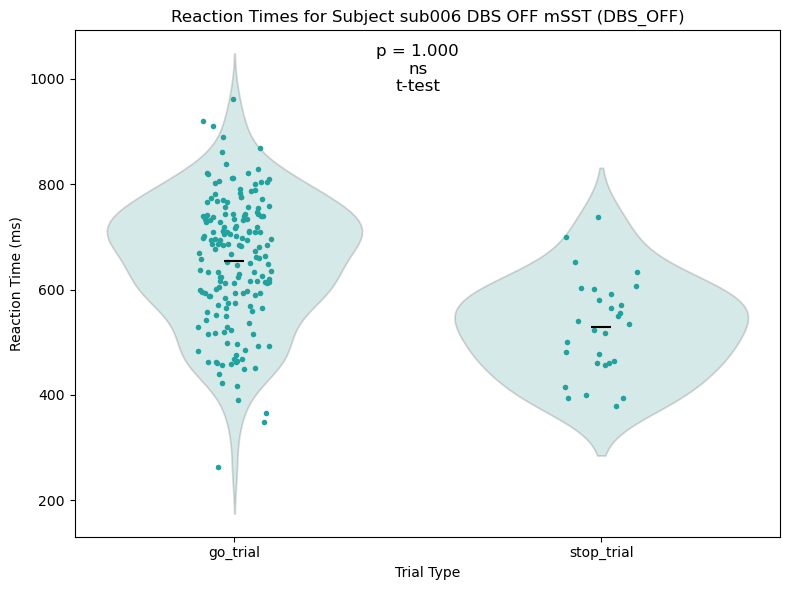

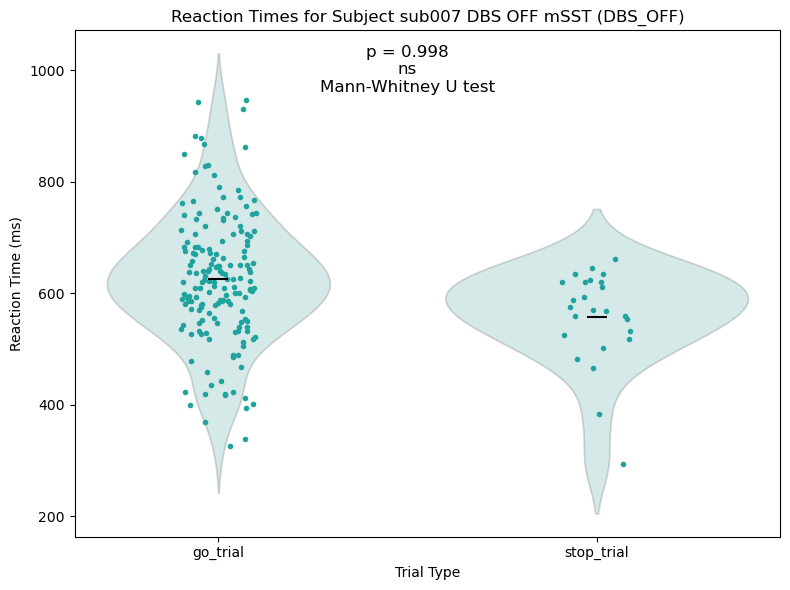

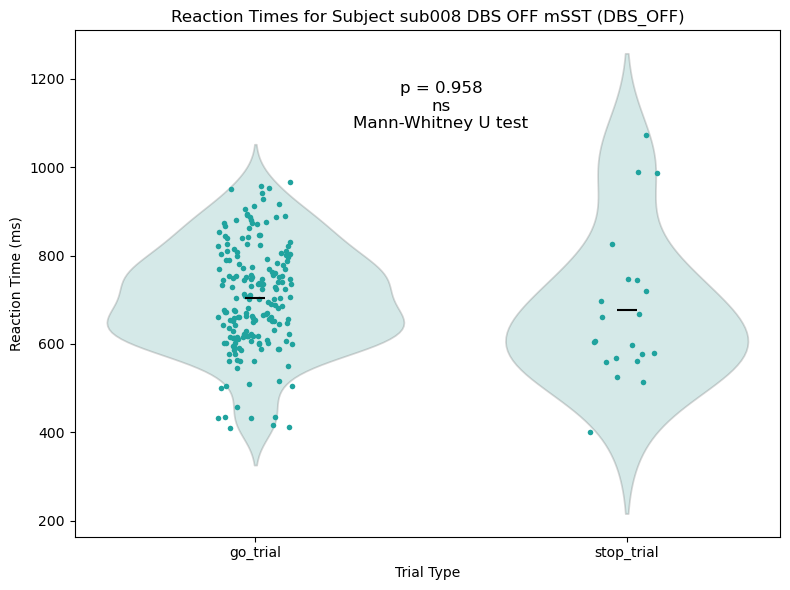

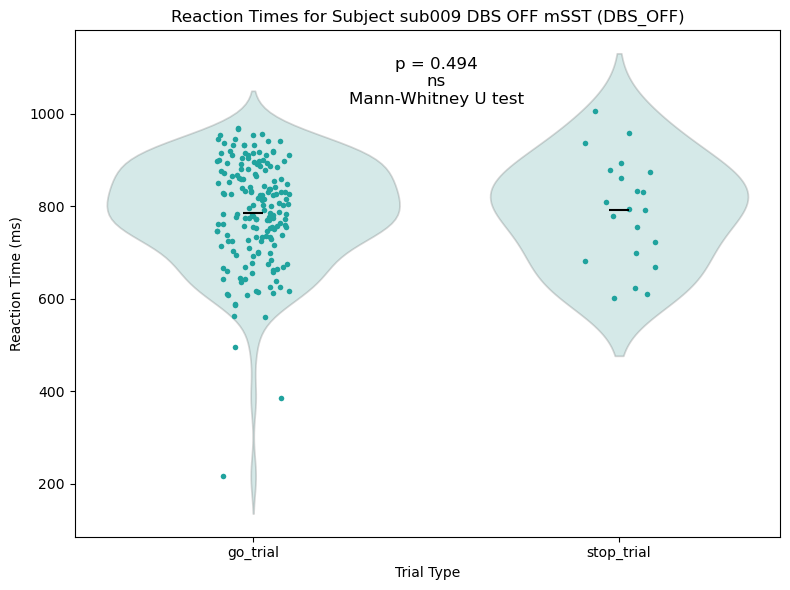

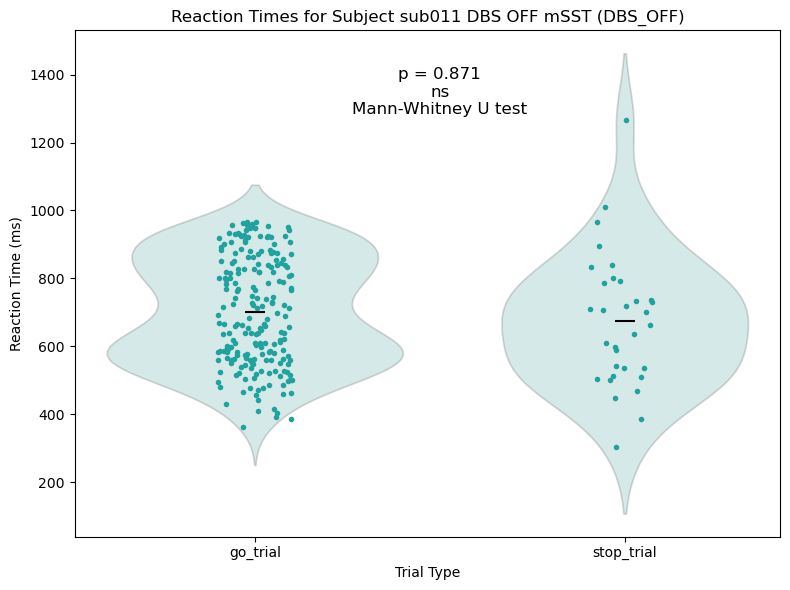

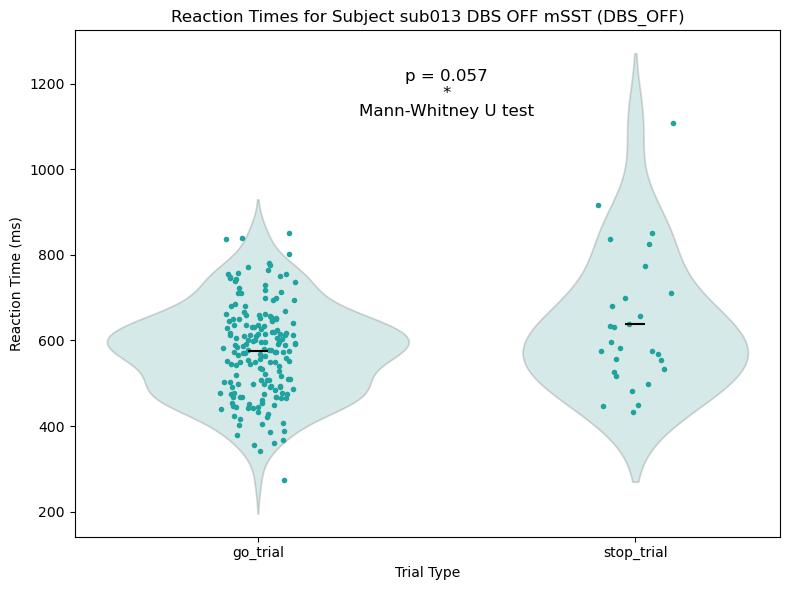

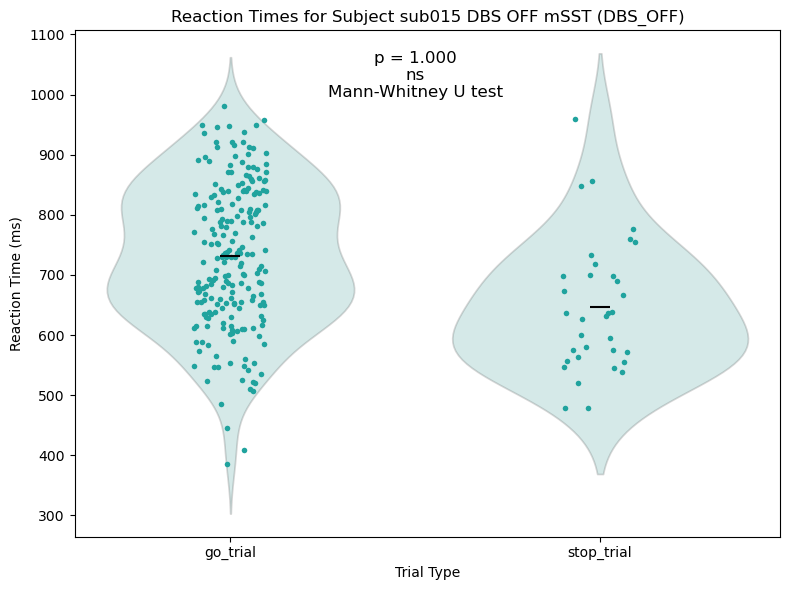

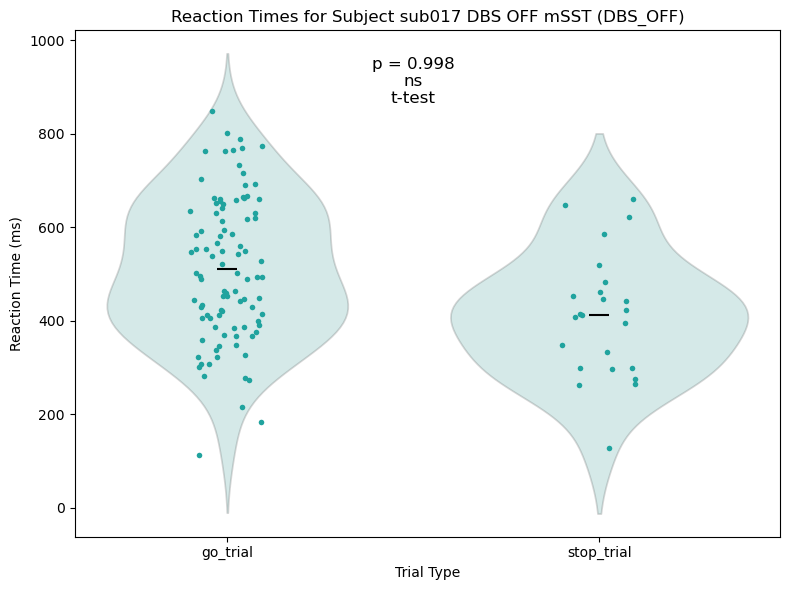

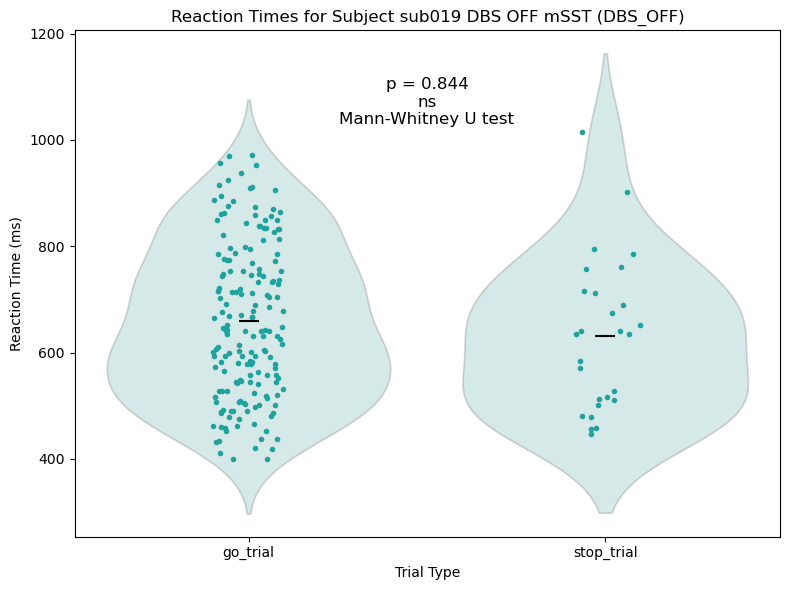

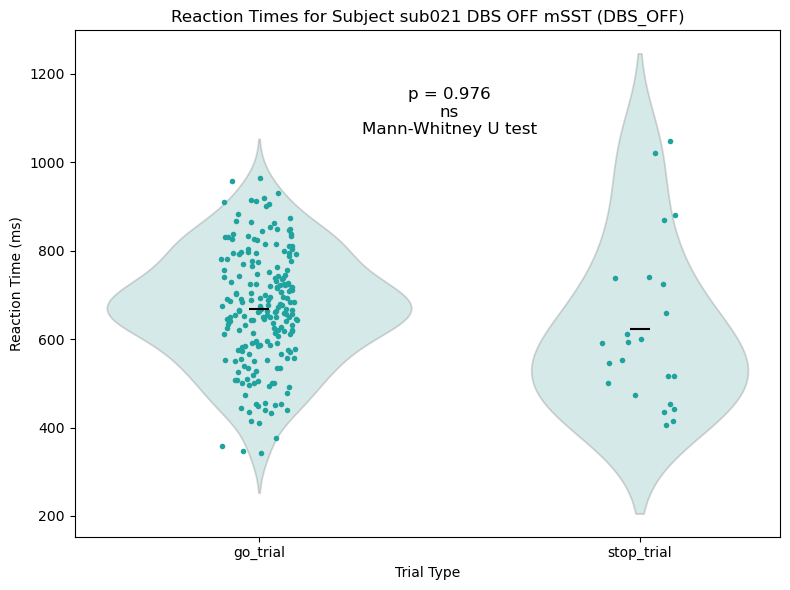

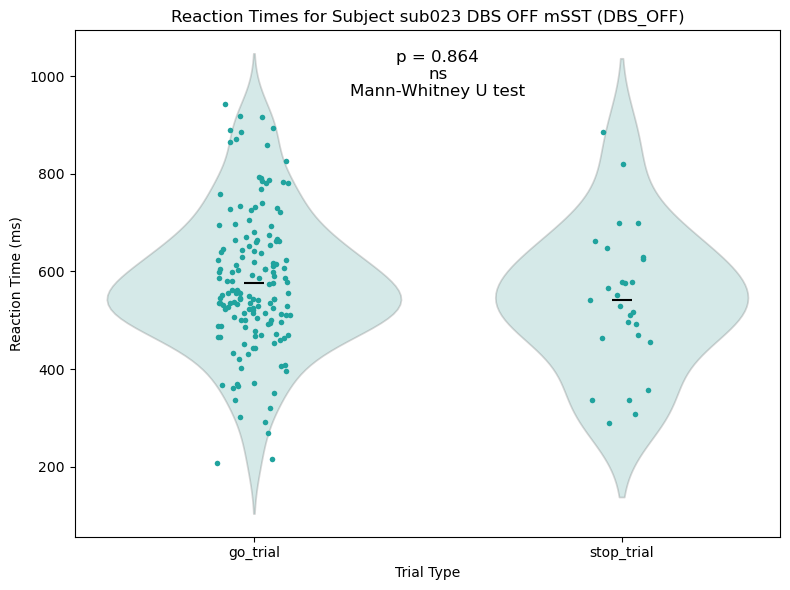

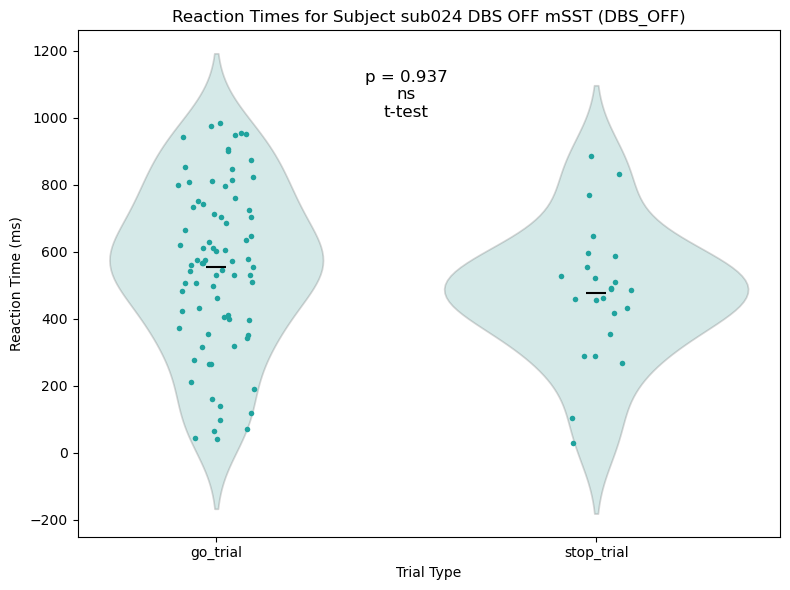

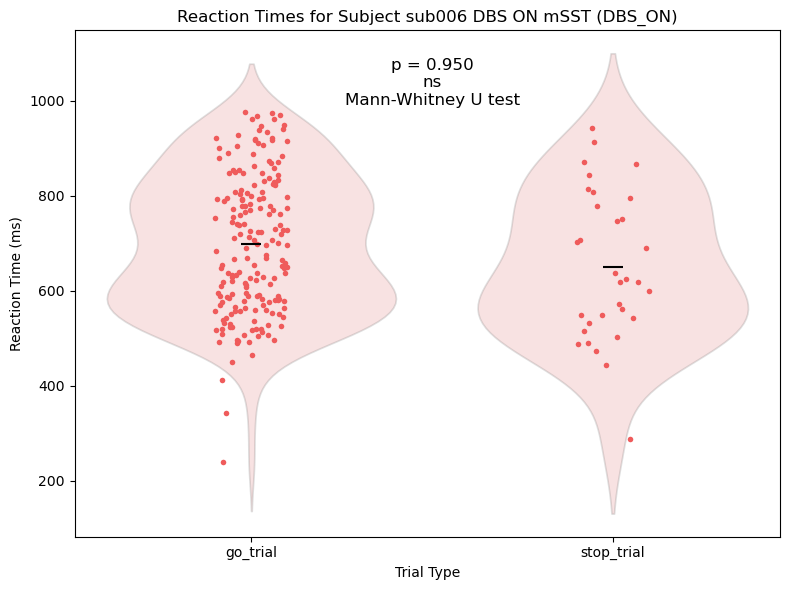

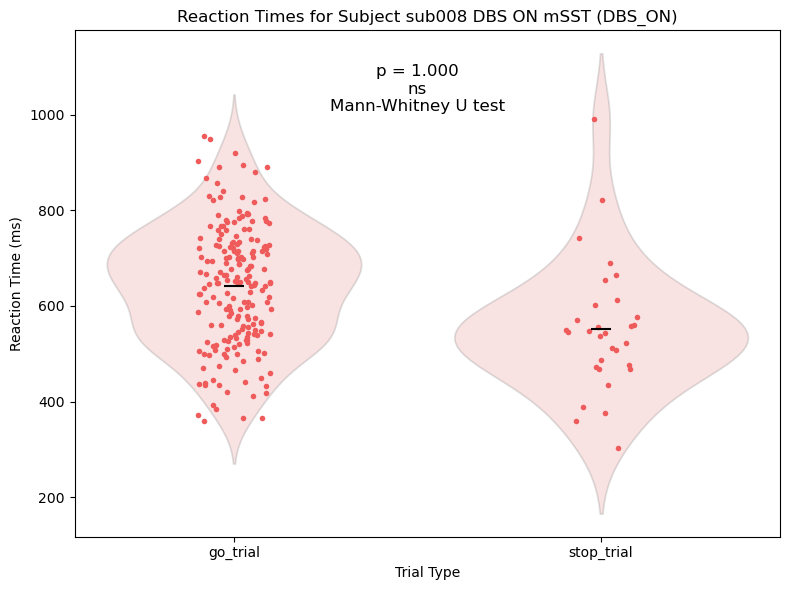

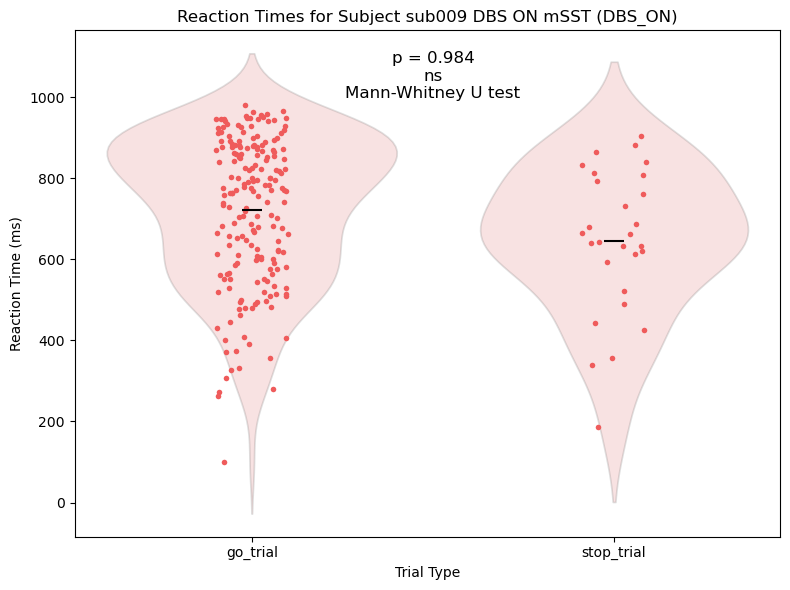

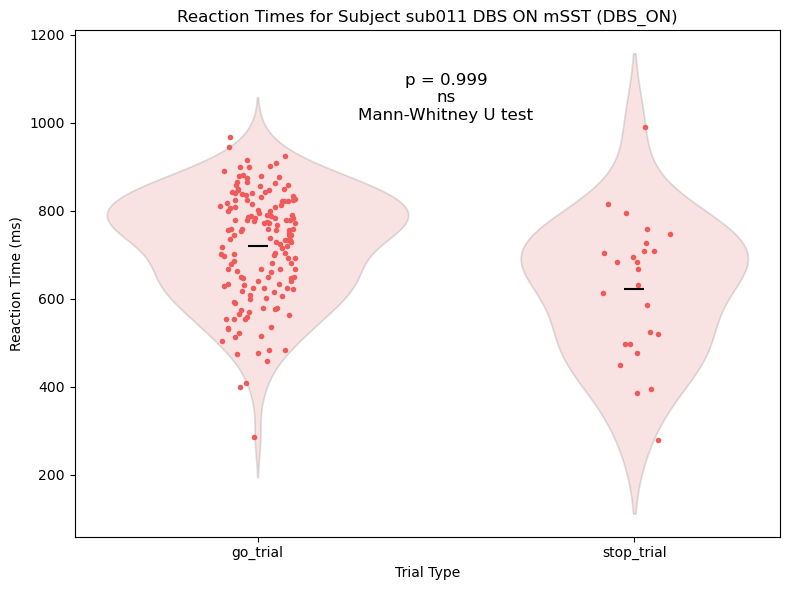

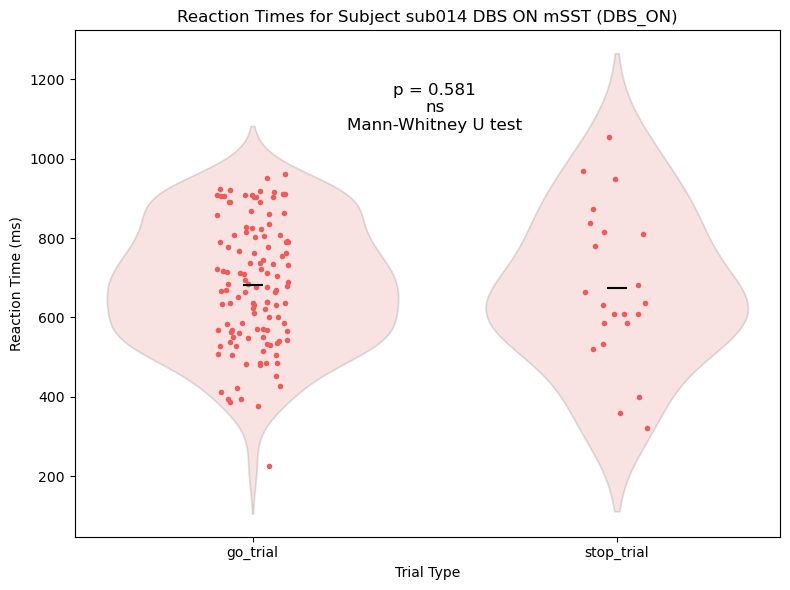

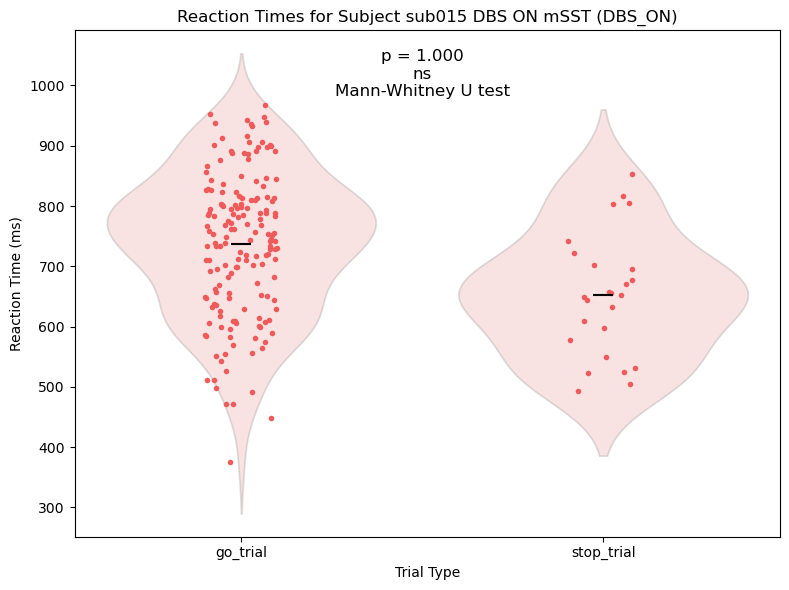

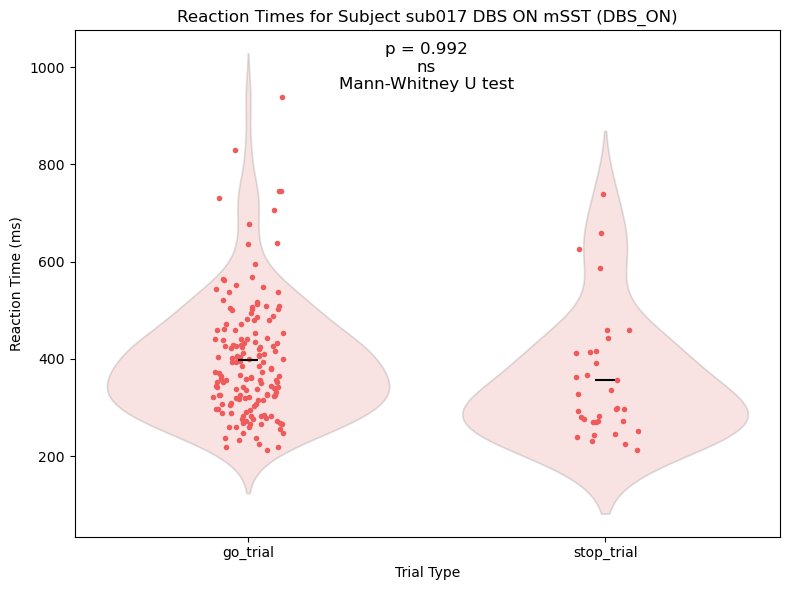

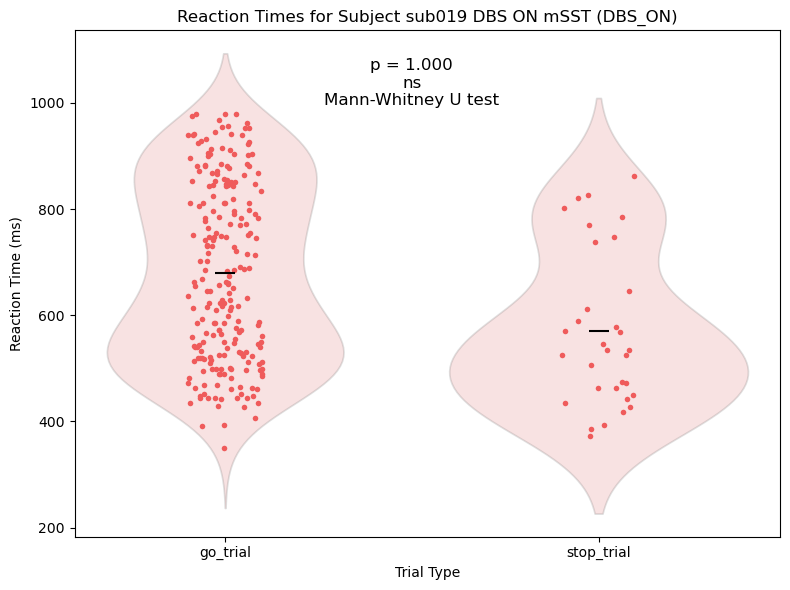

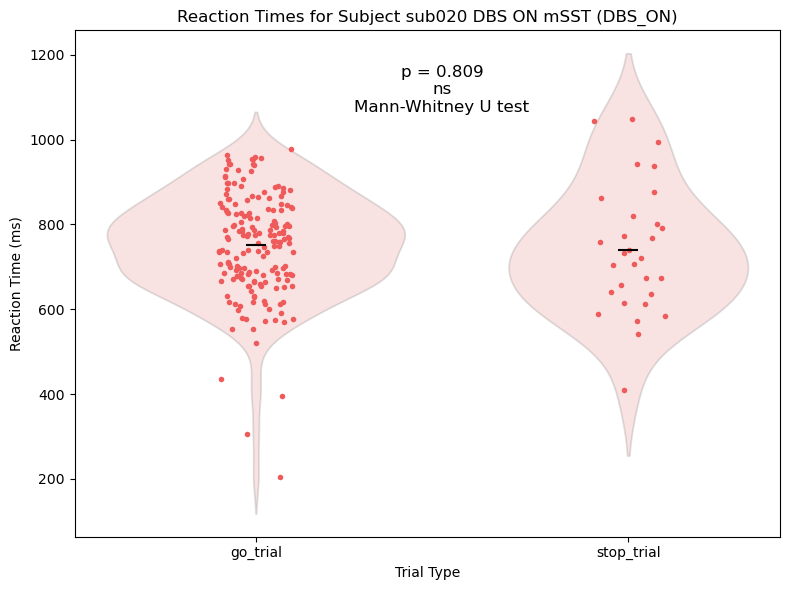

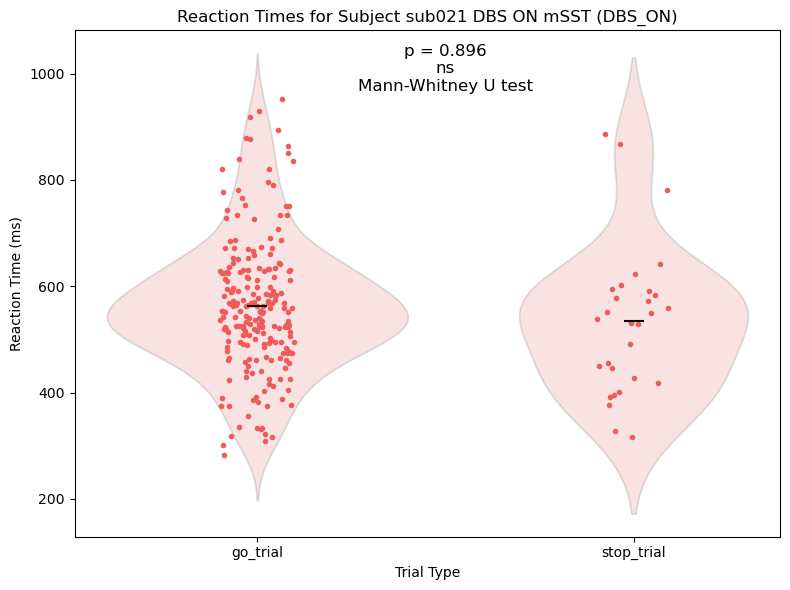

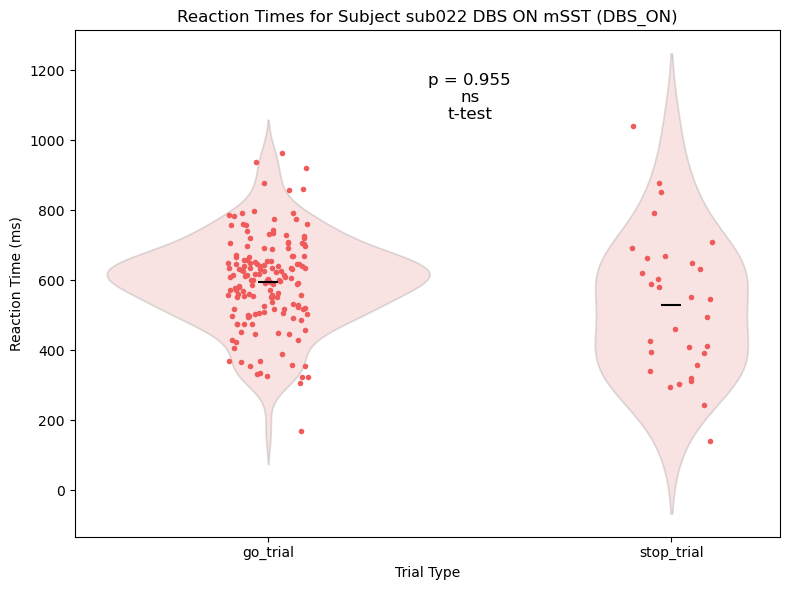

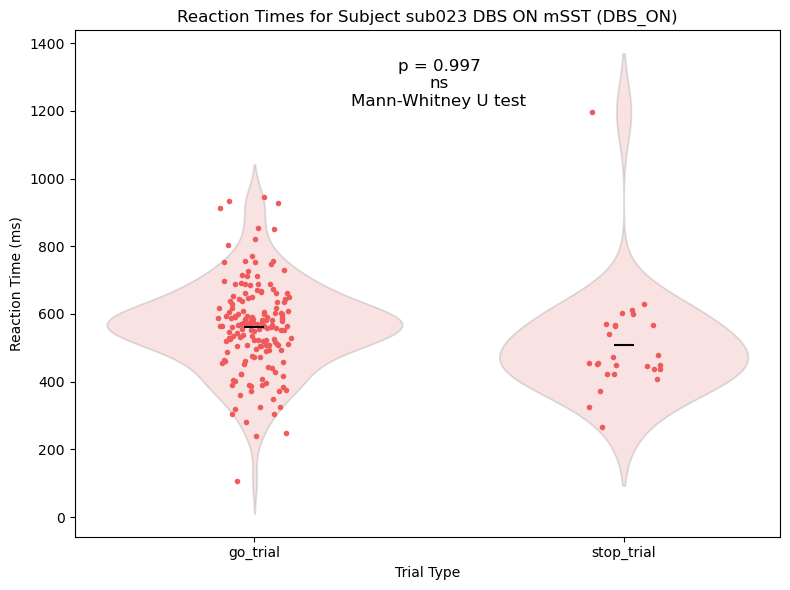

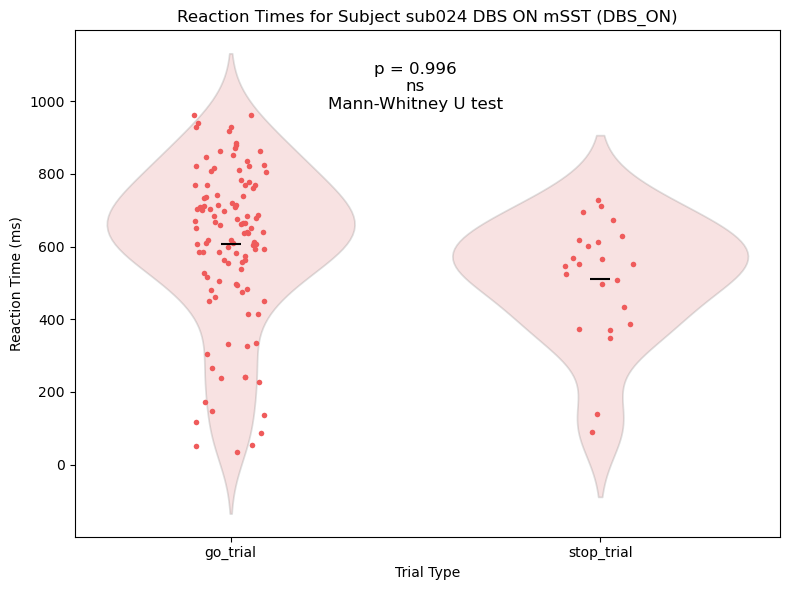

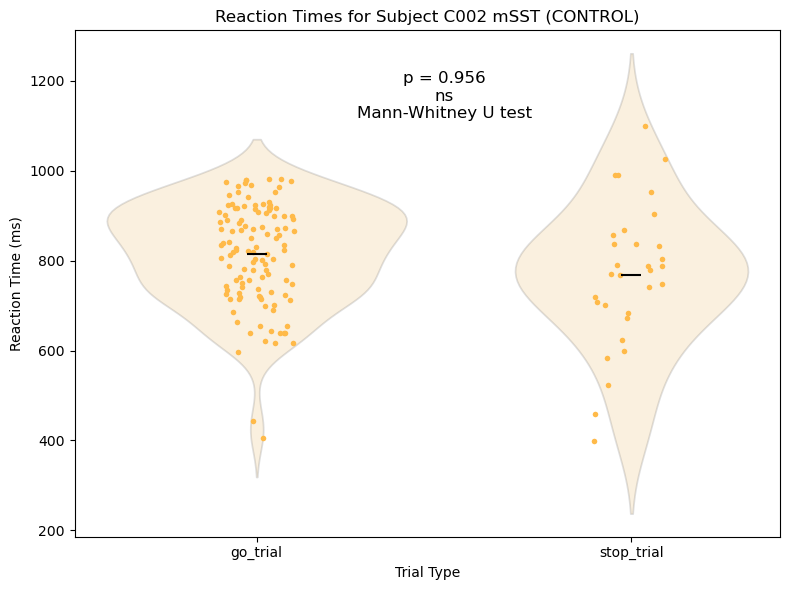

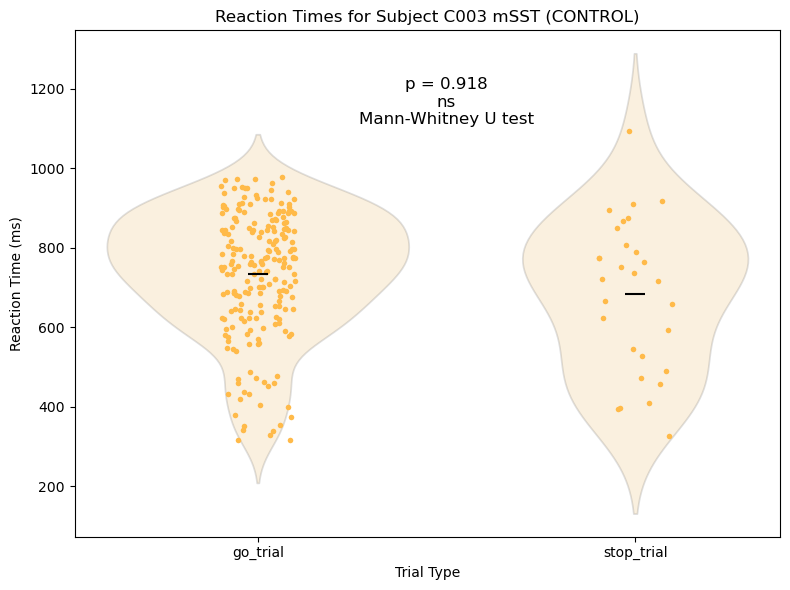

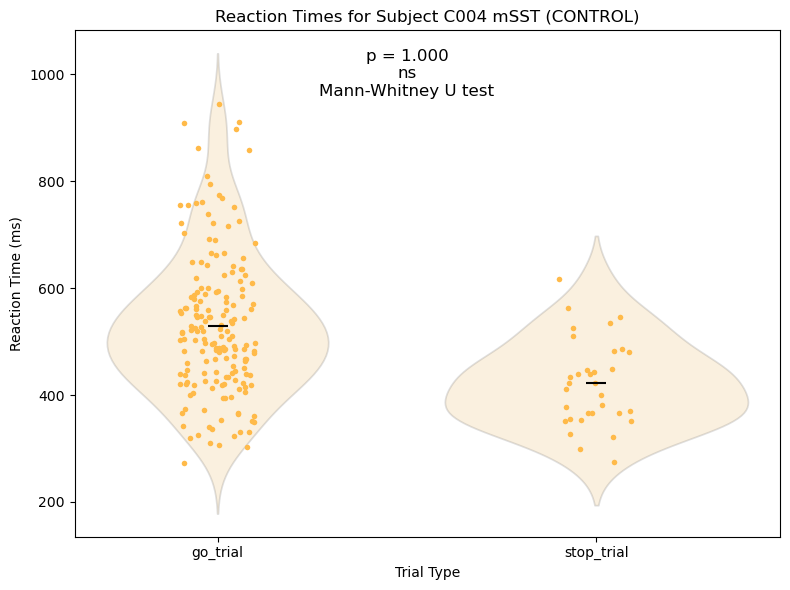

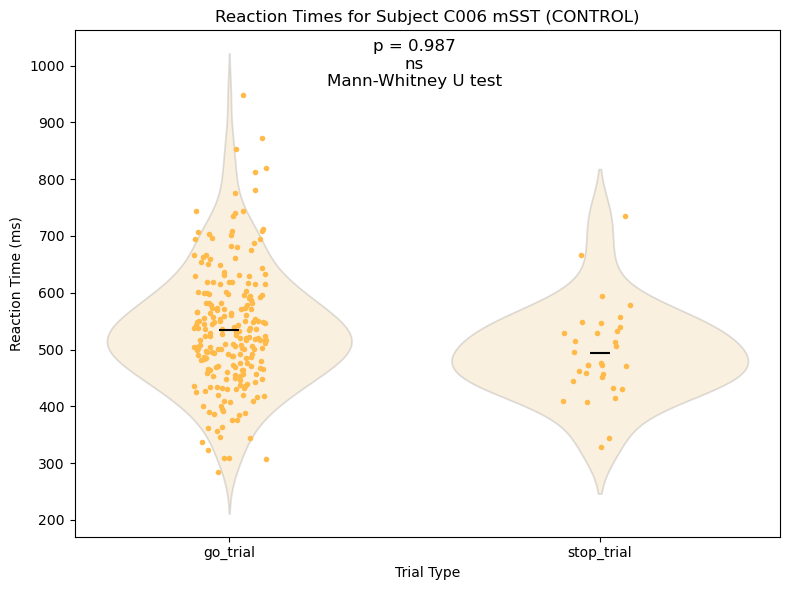

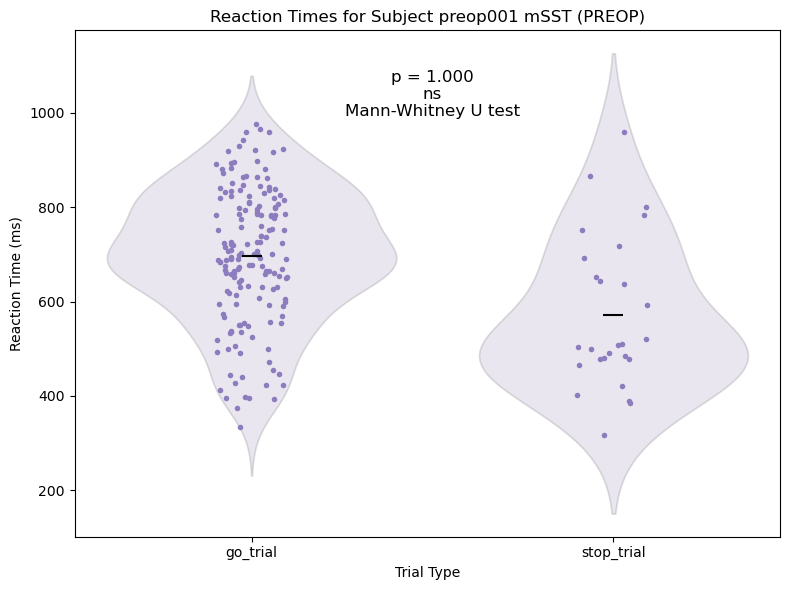

Excel file saved as 'p_values_independance_test.xlsx'.


In [37]:
# Define trial types to include only Go trials and Stop trials
trial_types = ['go_trial', 'stop_trial']
p_value_dict = {}
normal_go_count = 0
normal_stop_count = 0
# Loop through the filtered dictionaries (e.g., stats_OFF, stats_ON, etc.)
for condition, condition_stats in [('dbs_off', stats_OFF), 
                                   ('dbs_on', stats_ON), 
                                   ('control', stats_CONTROL), 
                                   ('preop', stats_PREOP)]:
    for subject_id, subject_data in condition_stats.items():
        # Gather data for the selected trial types into a DataFrame
        data = []
        for trial_type in trial_types:
            if f"{trial_type} RTs (ms)" in subject_data:  # Ensure the trial type key exists
                data.extend([(trial_type, val) for val in subject_data[f"{trial_type} RTs (ms)"]])

        df = pd.DataFrame(data, columns=['Trial Type', 'Reaction Time'])

        # Extract reaction times for statistical comparison
        go_data = df[df['Trial Type'] == 'go_trial']['Reaction Time']
        stop_data = df[df['Trial Type'] == 'stop_trial']['Reaction Time']

        # Test for normality:
        normal_go = scipy.stats.shapiro(go_data)[1] > 0.05 if len(go_data) >= 3 else False
        normal_go_count += 1 if normal_go else 0
        normal_stop = scipy.stats.shapiro(stop_data)[1] > 0.05 if len(stop_data) >= 3 else False
        normal_stop_count += 1 if normal_stop else 0

        # Perform Independent t-test if normality is met; otherwise, fallback to Mann-Whitney
        if len(go_data) >= 3 and len(stop_data) >= 3:
            if normal_go and normal_stop:
                stat, p_value = scipy.stats.ttest_ind(stop_data, go_data, equal_var=False, alternative = 'greater')  # Welch's t-test
                test = 't-test'
            else:
                stat, p_value = scipy.stats.mannwhitneyu(stop_data, go_data, alternative='greater')
                test = 'Mann-Whitney U test'
        else:
            p_value = None  # Not enough data for test

        p_value_dict[f"{subject_id}_{test}"] = p_value
        results_dict[subject_id]['independance test used'] = test
        results_dict[subject_id]['p-value independance'] = p_value

        # Initialize the plot
        plt.figure(figsize=(8, 6))

        # Plot violins for the single condition using the custom palette
        sns.violinplot(data=df, x='Trial Type', y='Reaction Time', 
                       inner=None, color=color_dict[condition], alpha=0.2)  # Use condition color

        # Overlay data points with a strip plot
        sns.stripplot(data=df, x='Trial Type', y='Reaction Time', 
                      jitter=True, color=color_dict[condition], marker='o', size=4)

        # Calculate and plot means manually for each trial type
        for i, trial_type in enumerate(trial_types):
            condition_data = df[df['Trial Type'] == trial_type]
            mean_value = condition_data['Reaction Time'].mean()
            plt.scatter(x=i, y=mean_value, color='black', marker="_", s=200, label='Mean' if i == 0 else "", zorder=5)

        # Annotate statistical results
        if p_value is not None:
            annotation = "*" if p_value <= 0.1 else "ns"
            max_val = df['Reaction Time'].max()
            plt.text(0.5, max_val + 10, f"p = {p_value:.3f}\n{annotation}\n{test}", 
                     ha='center', va='bottom', color='black', fontsize=12)

        # Customize plot
        plt.xlabel('Trial Type')
        plt.ylabel('Reaction Time (ms)')
        plt.title(f'Reaction Times for Subject {subject_id} ({condition.upper()})')
        plt.tight_layout()
        plt.savefig(join(behav_results_saving_path, f"test_independance_{subject_id}_{condition}.png"))
        plt.show()

# Convert dictionary to DataFrame
df_p_value_dict = pd.DataFrame(list(p_value_dict.items()), columns=['Subject_test', 'P-Value'])

# Save to Excel
df_p_value_dict.to_excel(join(behav_results_saving_path,'p_values_independance_test.xlsx'), index=False)

print("Excel file saved as 'p_values_independance_test.xlsx'.")


### Replication of tests used in Hervault et al., 2021 ###
"every single participant had a shorter mean RT in failed–STOP trials than in GO trials. This was the case in both the pressing (t(39) = 8.42, p < .001, d =1.35) and the swiping type (t(39) = 13.72, p < .001, d = 2.0)"
Statistical test used:
t(39) → A paired t-test with 40 participants (degrees of freedom = 39).

t-value:
Pressing: t = 8.42
Swiping: t = 13.72

p < .001 → Very strong evidence against the null hypothesis.

Cohen’s d (effect size):
Pressing: d = 1.35 (large effect)
Swiping: d = 2.0 (very large effect)


Paired t-test results: t-statistic(30) = -7.687042936257252, p-value = 7.088818962920056e-09
[125.63808606  45.18994226  49.84295083 108.11763579  40.76441482
  46.73675682 124.85419713  67.97017754  89.64382166  27.54004772
  75.32269308  -4.93829466  26.30357379  97.96941508 133.50963037
 -62.41231116   6.62372933  84.52579162  84.61846652  40.94570891
  98.83059602 107.55390695  27.05538388  10.16465158  45.4808262
  28.98825679  66.89951084  34.85865184  53.60567232  97.41846785
  76.92272156]
Negative differences found at indices: [11 15], corresponding subjects: ['sub009 DBS OFF mSST', 'sub013 DBS OFF mSST']
Excluded subjects: ['sub009 DBS OFF mSST', 'sub013 DBS OFF mSST']
Cohen's d = 1.38


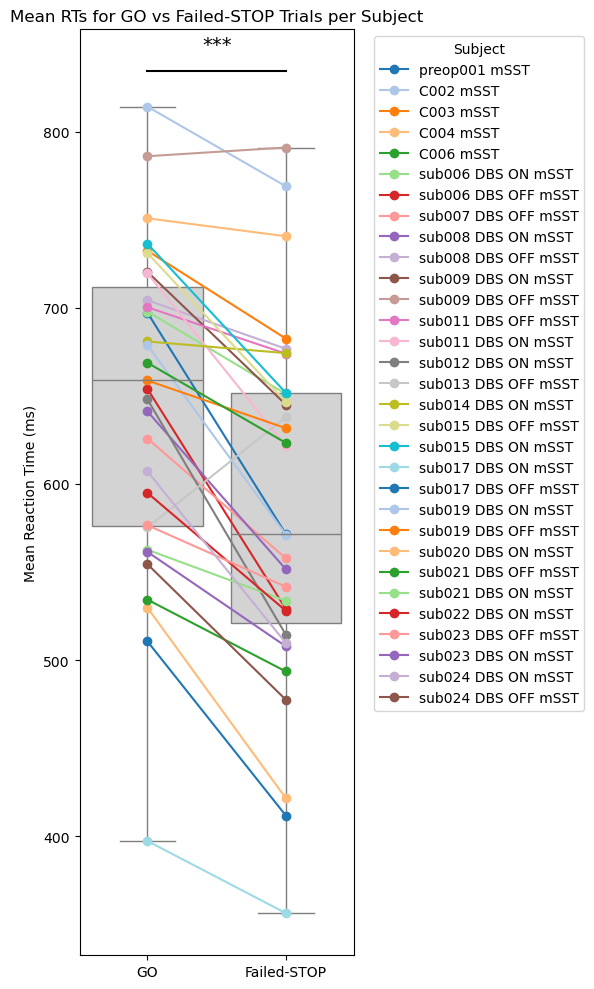

In [38]:
# paired t-test for Go and Stop trials accross all subjects
mean_RT_go = []
mean_RT_stop = []
subs = []
for sub in stats.keys():
    subs.append(sub)
    mean_RT_go.append(stats[sub]['go_trial mean RT (ms)'])
    mean_RT_stop.append(stats[sub]['stop_trial mean RT (ms)'])

# Perform the paired t-test
t_stat, p_value = scipy.stats.ttest_rel(mean_RT_stop, mean_RT_go, alternative='less')
print(f"Paired t-test results: t-statistic({len(subs)-1}) = {t_stat}, p-value = {p_value}")

# Convert to NumPy arrays if needed
go = np.array(mean_RT_go)
stop = np.array(mean_RT_stop)

# Calculate difference
diff = go - stop
print(diff)
# Look for negative values in diff and print the indexes
negative_indices = np.where(diff < 0)[0]
if len(negative_indices) > 0:
    print(f"Negative differences found at indices: {negative_indices}, corresponding subjects: {[subs[i] for i in negative_indices]}")
    excluded_subjects = [subs[i] for i in negative_indices]
print(f"Excluded subjects: {excluded_subjects}")
mean_diff = np.mean(diff)
sd_diff = np.std(diff, ddof=1)

# Cohen's d
cohens_d = mean_diff / sd_diff
print(f"Cohen's d = {cohens_d:.2f}")

# Determine significance level
if p_value < 0.001:
    stars = '***'
elif p_value < 0.01:
    stars = '**'
elif p_value < 0.05:
    stars = '*'
else:
    stars = 'ns'  # not significant

# Prepare long-format DataFrame
df_long = pd.DataFrame({
    'Subject': subs * 2,
    'Trial Type': ['GO'] * len(subs) + ['Failed-STOP'] * len(subs),
    'Mean RT (ms)': mean_RT_go + mean_RT_stop
})

plt.figure(figsize=(6, 10))

# First: draw the boxplot for GO and STOP trials
sns.boxplot(
    data=df_long,
    x='Trial Type',
    y='Mean RT (ms)',
    color='lightgray',
    fliersize=0  # hide individual outlier dots from the boxplot
)

# Then: overlay individual subject lines
palette = sns.color_palette('tab20', n_colors=len(subs))
subject_colors = dict(zip(subs, palette))

for subject in subs:
    go_rt = df_long[(df_long['Subject'] == subject) & (df_long['Trial Type'] == 'GO')]['Mean RT (ms)'].values[0]
    stop_rt = df_long[(df_long['Subject'] == subject) & (df_long['Trial Type'] == 'Failed-STOP')]['Mean RT (ms)'].values[0]
    plt.plot(['GO', 'Failed-STOP'], [go_rt, stop_rt], marker='o', color=subject_colors[subject], label=subject)

# Add the significance line and stars
y_max = df_long['Mean RT (ms)'].max()
line_height = y_max + 20
text_height = y_max + 30
plt.plot([0, 1], [line_height, line_height], color='black', linewidth=1.5)
plt.text(0.5, text_height, stars, ha='center', va='bottom', fontsize=14)
plt.legend(title='Subject', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Mean RTs for GO vs Failed-STOP Trials per Subject')
plt.ylabel('Mean Reaction Time (ms)')
plt.xlabel('')
plt.tight_layout()
plt.show()

Overall, participants had a shorter mean RT in unsuccessful STOP trials than in GO trials (t(29) = -7.384085884627519, p < 0.001, d = 1.35). At the individual level, this didn't hold true for 2 subjects (sub009 DBS OFF, sub013 DBS OFF) and they were therefore removed from subsequent analysis.

## 3.b. test: (b) If (u)GS RT with small SSD > (u)GS RT with long SSD, the independence assumption is violated ##


preop001 mSST


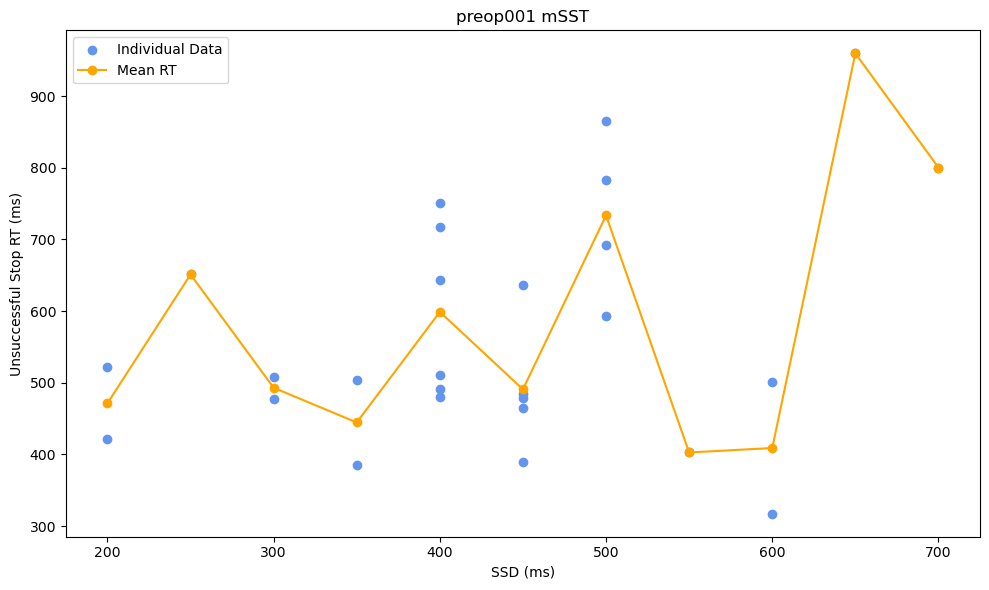

Data does NOT appear normal (p = 0.04224039401486028 )
Data appears normally distributed (p = 0.8196523821332566 )
Mean RT (Small SSD): 528.6993444444508
Mean RT (Long SSD): 657.1955777730586
T-test p-value: 0.9474037474399793


C002 mSST


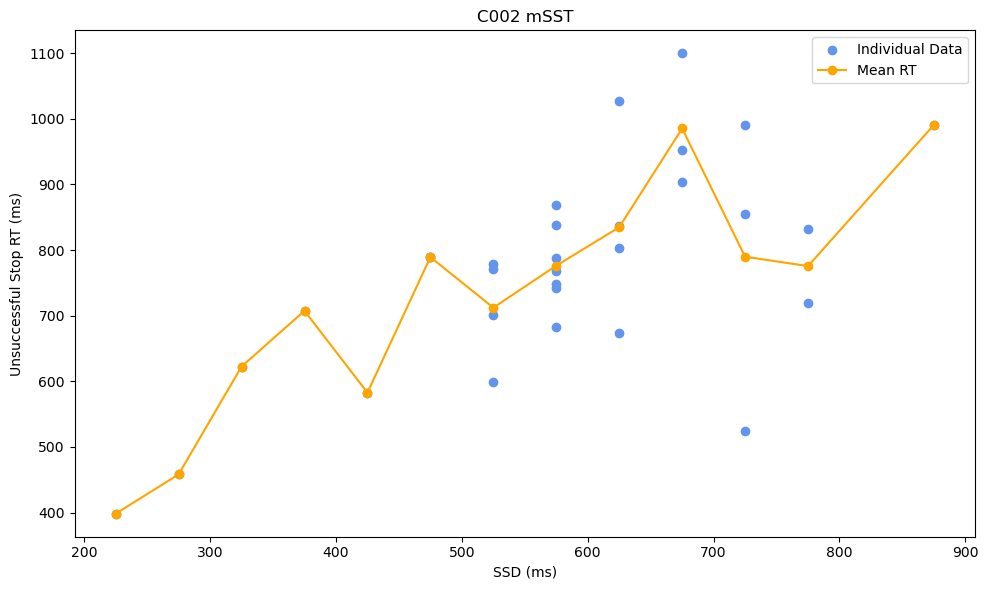

Data does NOT appear normal (p = 0.04041486019909104 )
Data appears normally distributed (p = 0.8575597363974581 )
Mean RT (Small SSD): 701.6918666971227
Mean RT (Long SSD): 862.0348307304084
T-test p-value: 0.9978970455900583


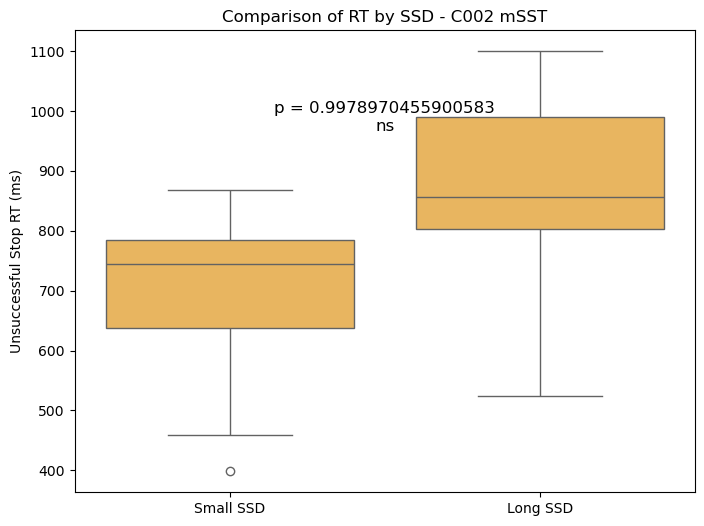

C003 mSST


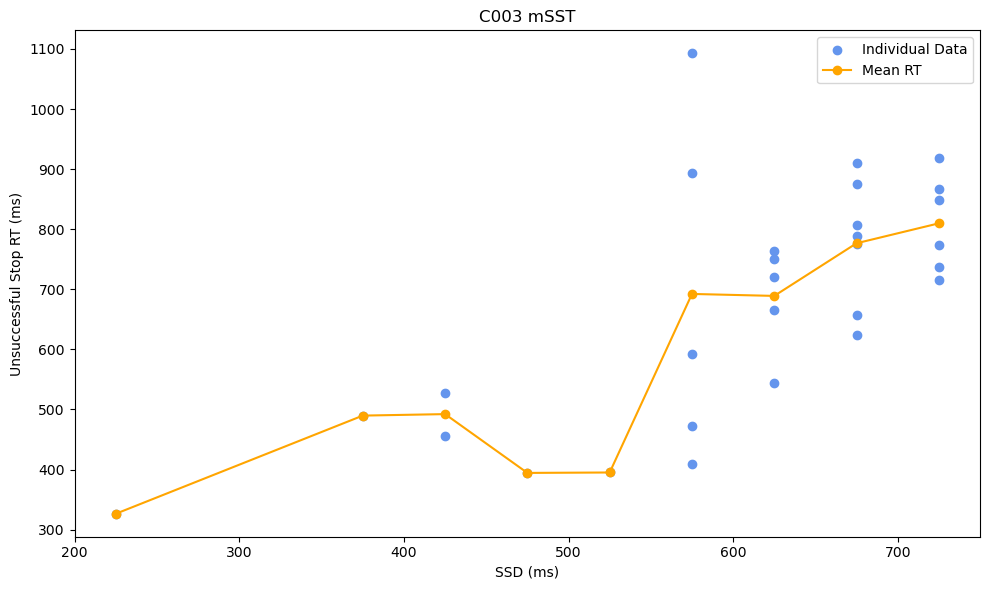

Data appears normally distributed (p = 0.19979562097095344 )
Data appears normally distributed (p = 0.7447579481864404 )
Mean RT (Small SSD): 593.5723750044417
Mean RT (Long SSD): 791.9256615434558
T-test p-value: 0.9984621583241703


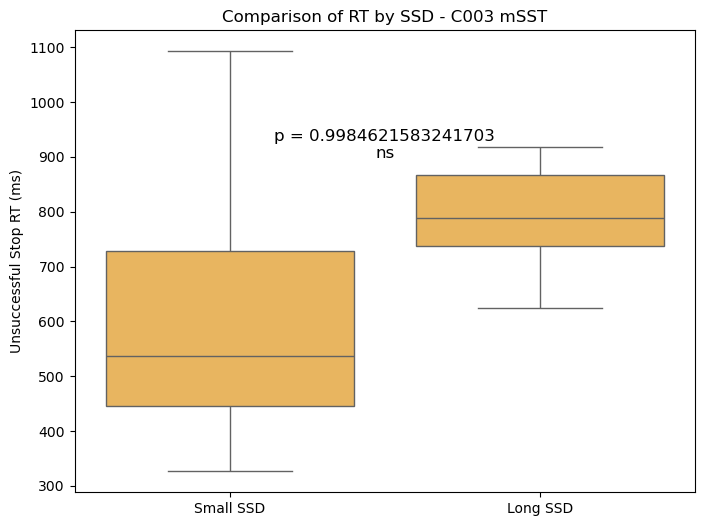

C004 mSST


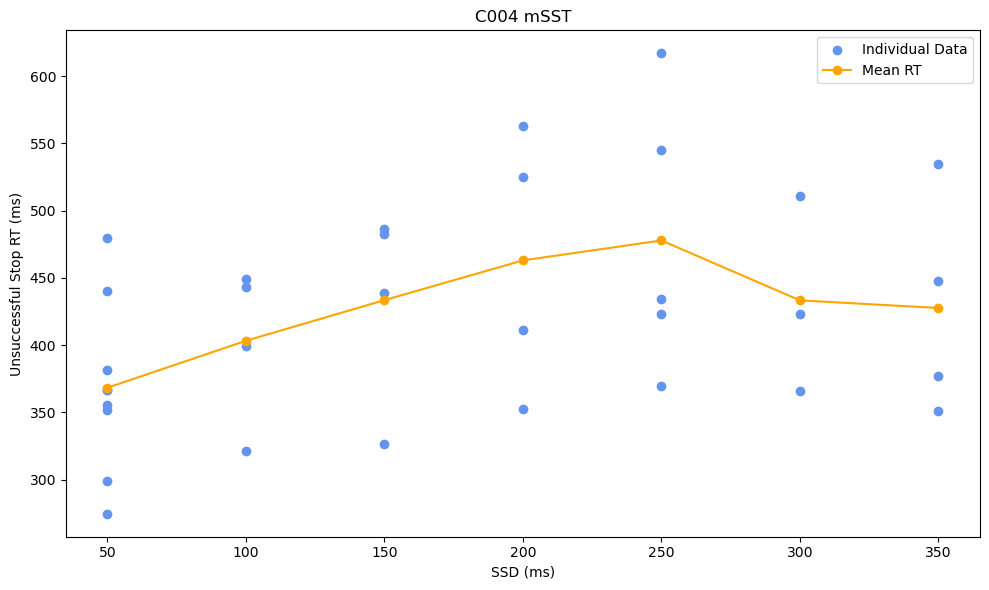

Data appears normally distributed (p = 0.3867234914078971 )
Data appears normally distributed (p = 0.15561779546439602 )
Mean RT (Small SSD): 391.86568235677174
Mean RT (Long SSD): 453.2370750057453
T-test p-value: 0.9655523969967634


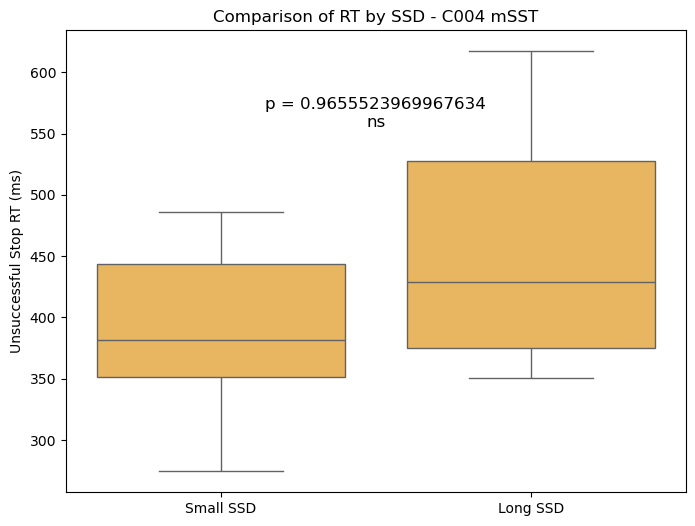

C006 mSST


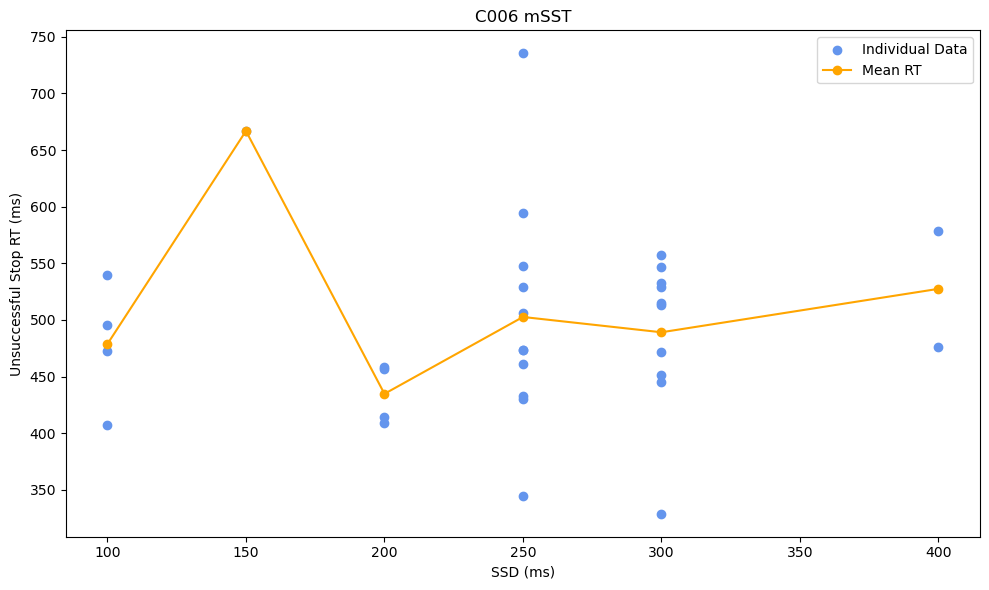

Data appears normally distributed (p = 0.0738212096763488 )
Data appears normally distributed (p = 0.1381340533099874 )
Mean RT (Small SSD): 492.4506649840623
Mean RT (Long SSD): 495.4668332745011
T-test p-value: 0.7986717773486776


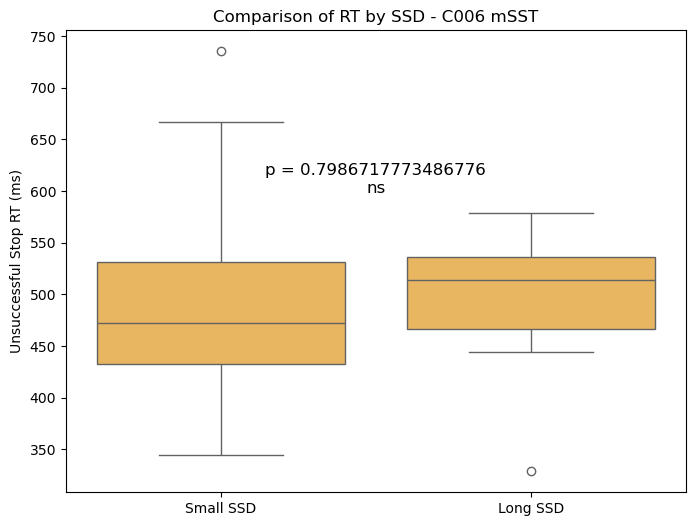

sub006 DBS ON mSST


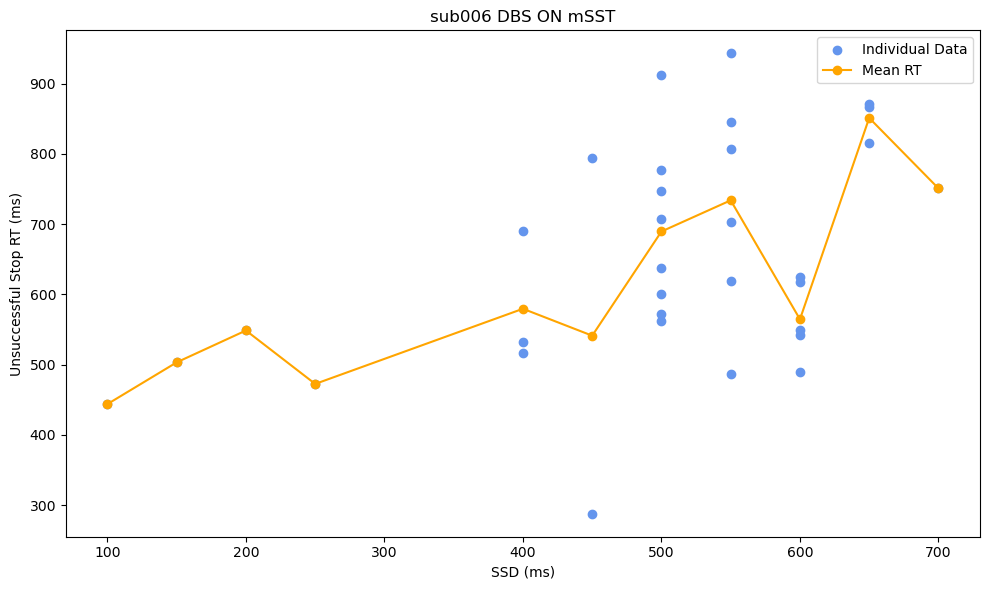

Data appears normally distributed (p = 0.9797026938056058 )
Data appears normally distributed (p = 0.2741398615178706 )
Mean RT (Small SSD): 606.1620175948037
Mean RT (Long SSD): 701.9816000014544
T-test p-value: 0.9553708813525691


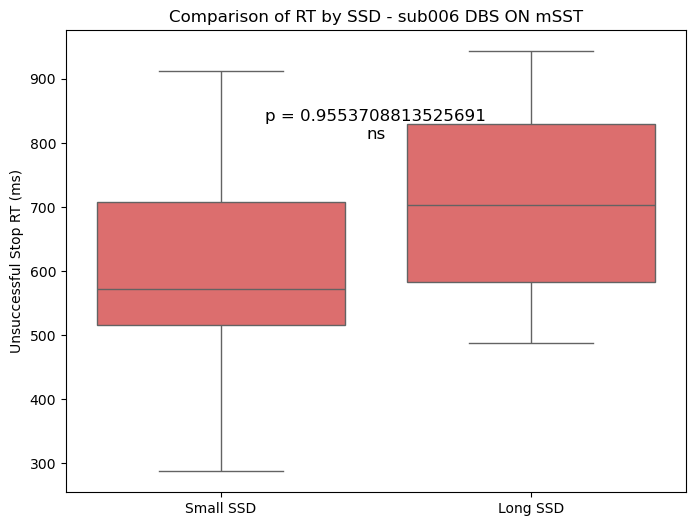

sub006 DBS OFF mSST


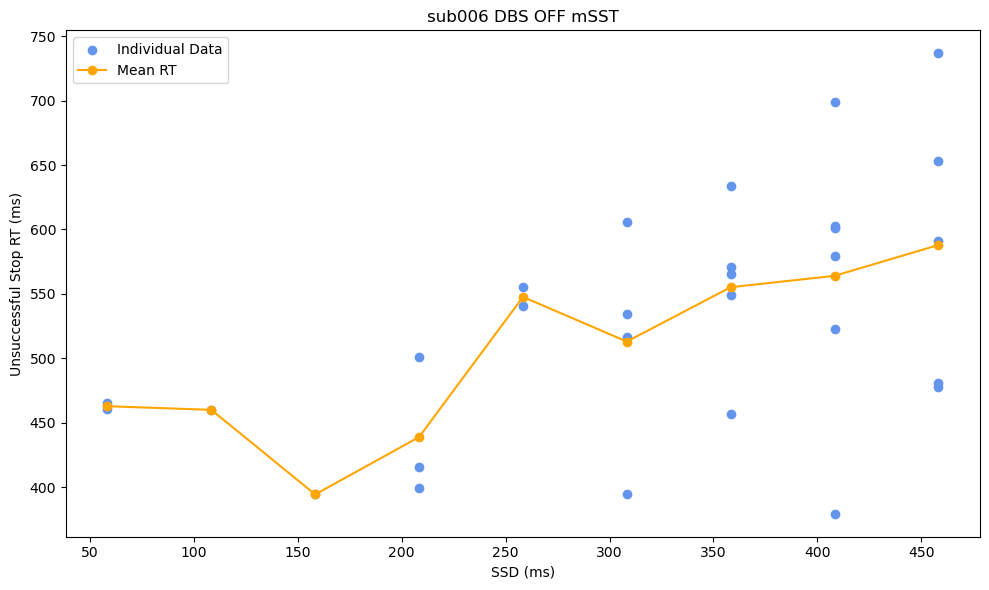

Data appears normally distributed (p = 0.4027316579445687 )
Data appears normally distributed (p = 0.9258807536818046 )
Mean RT (Small SSD): 501.05162222138864
Mean RT (Long SSD): 574.8969454487616
T-test p-value: 0.9795761650143571


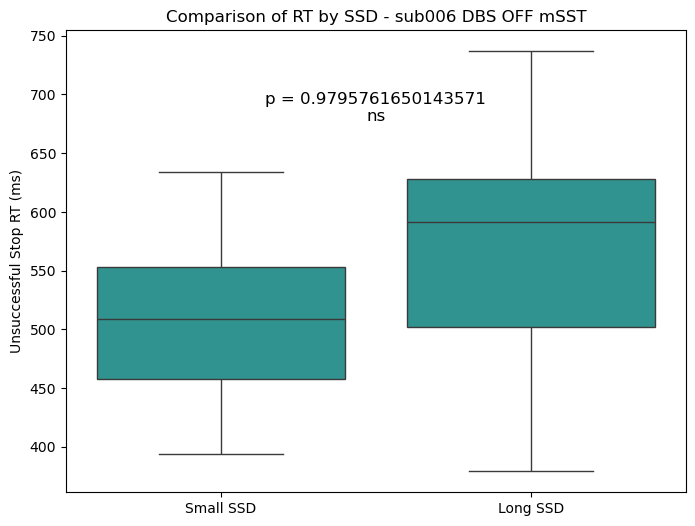

sub007 DBS OFF mSST


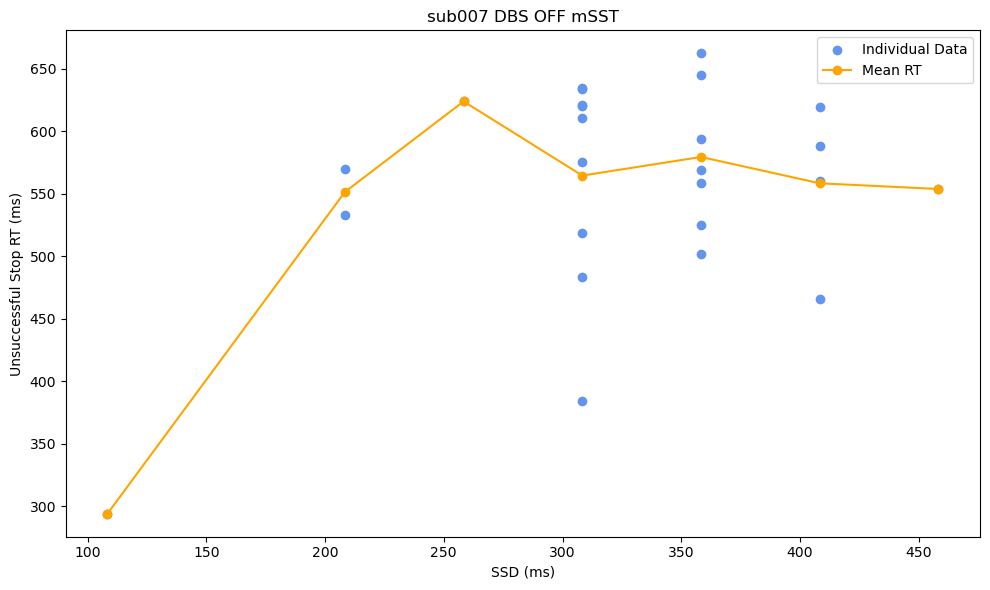

Data does NOT appear normal (p = 0.009723566953395598 )
Data appears normally distributed (p = 0.9886267512197565 )
Mean RT (Small SSD): 546.2800999998412
Mean RT (Long SSD): 570.2774083333679
T-test p-value: 0.4891515376679721


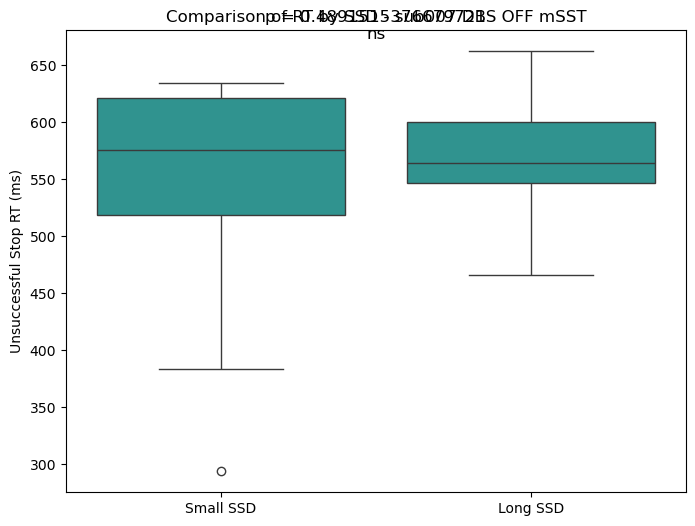

sub008 DBS ON mSST


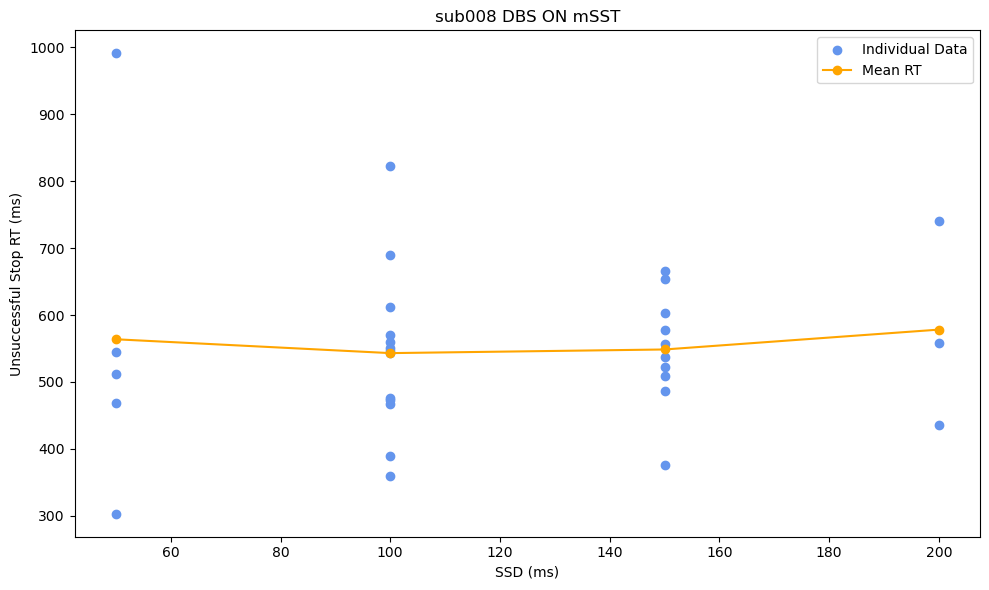

Data does NOT appear normal (p = 0.03815218585074302 )
Data appears normally distributed (p = 0.9993111451972189 )
Mean RT (Small SSD): 548.7807499400029
Mean RT (Long SSD): 555.328423049874
T-test p-value: 0.7455426753933077


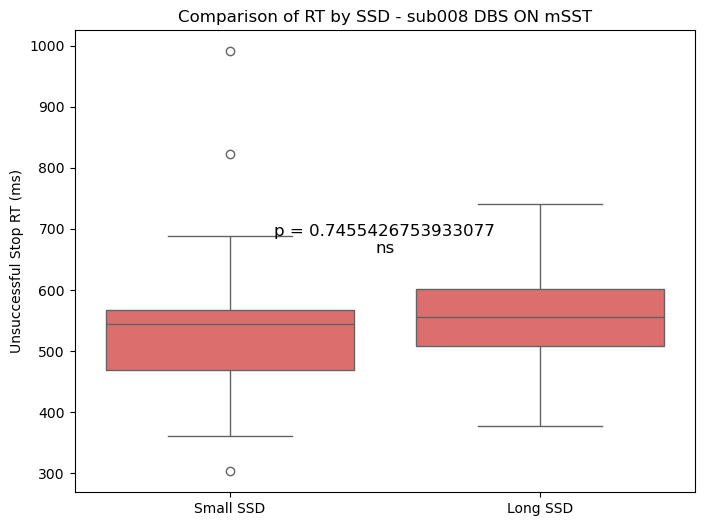

sub008 DBS OFF mSST


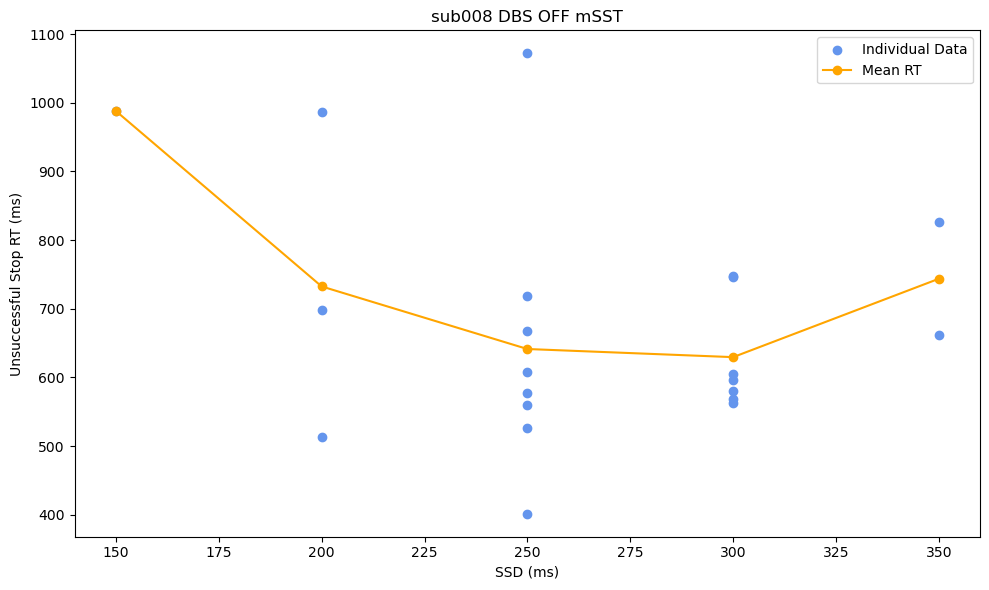

Data appears normally distributed (p = 0.14939501308187358 )
Data appears normally distributed (p = 0.10694961441299505 )
Mean RT (Small SSD): 693.0659916667992
Mean RT (Long SSD): 654.9222444445048
T-test p-value: 0.5705078519955201


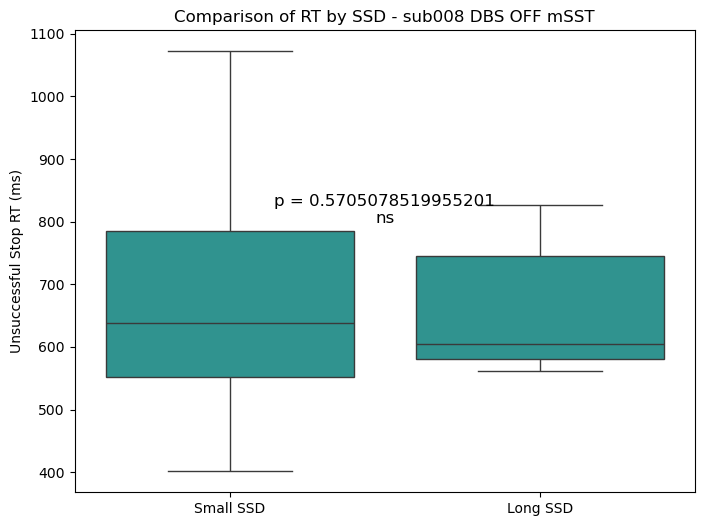

sub009 DBS ON mSST


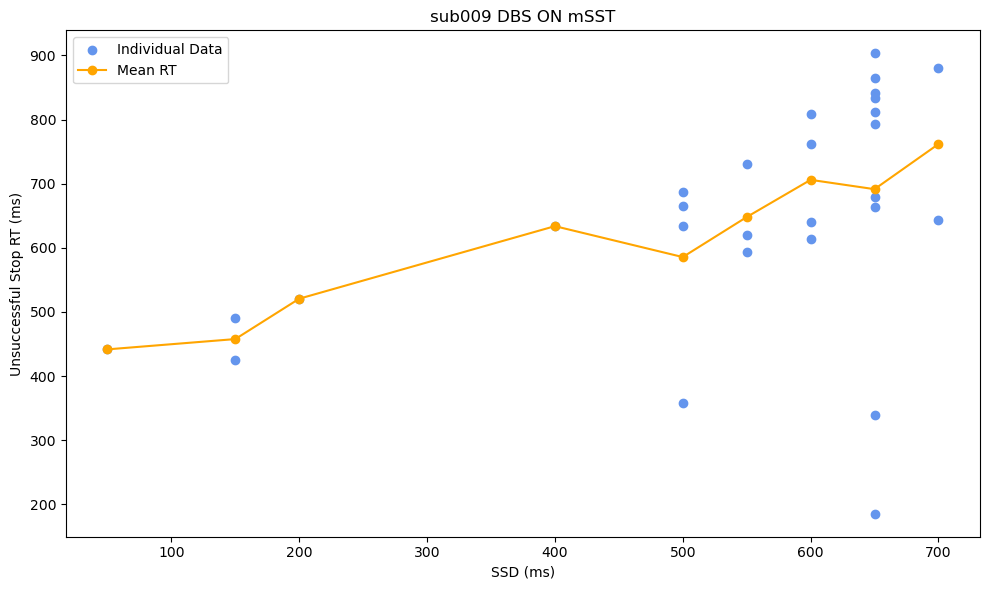

Data appears normally distributed (p = 0.738134667972792 )
Data does NOT appear normal (p = 0.008755758021979022 )
Mean RT (Small SSD): 601.4003999807755
Mean RT (Long SSD): 703.2262916715505
T-test p-value: 0.9892185308626813


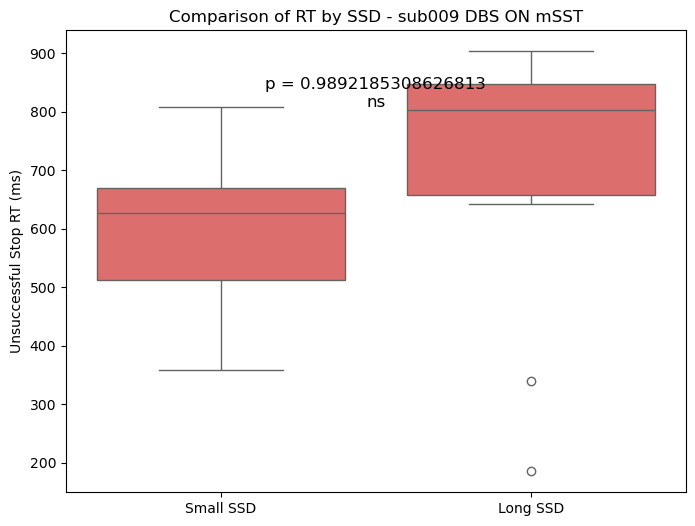

sub009 DBS OFF mSST


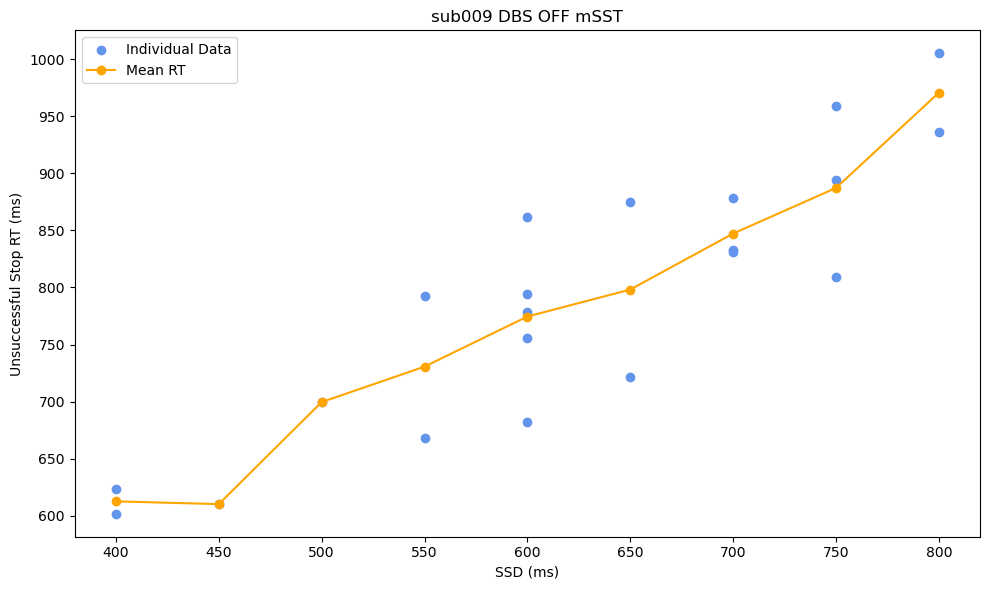

Data appears normally distributed (p = 0.5092870282459807 )
Data appears normally distributed (p = 0.9788644952031109 )
Mean RT (Small SSD): 715.3942818033763
Mean RT (Long SSD): 874.0414200001396
T-test p-value: 0.9995883634816353


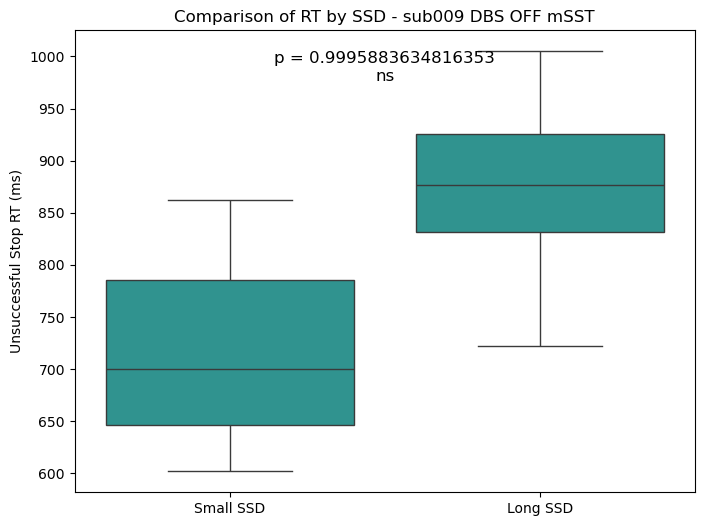

sub011 DBS OFF mSST


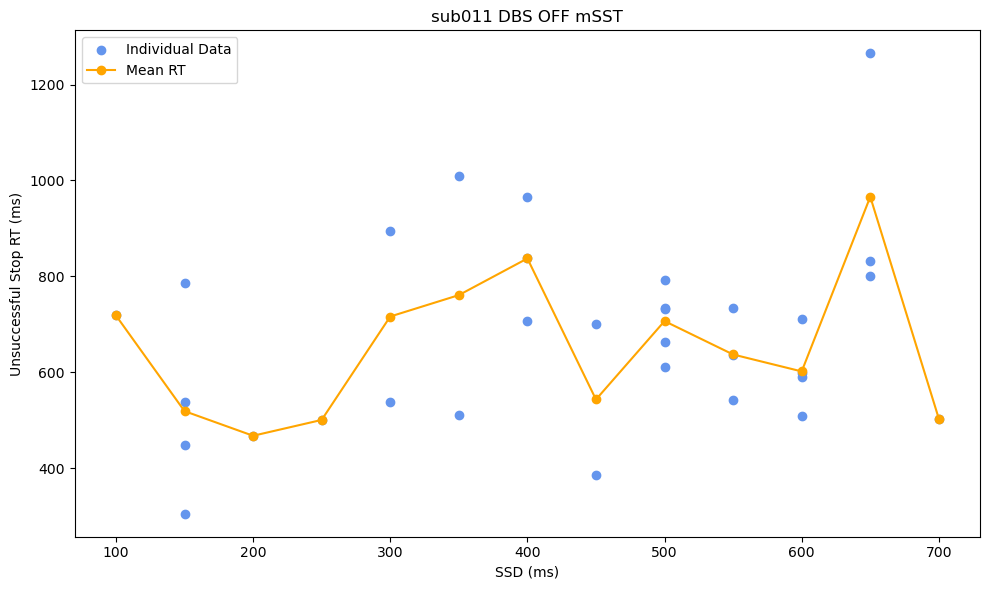

Data appears normally distributed (p = 0.5532150892289582 )
Data does NOT appear normal (p = 0.004261158858090908 )
Mean RT (Small SSD): 644.6616750035901
Mean RT (Long SSD): 703.265018753882
T-test p-value: 0.8317408628039198


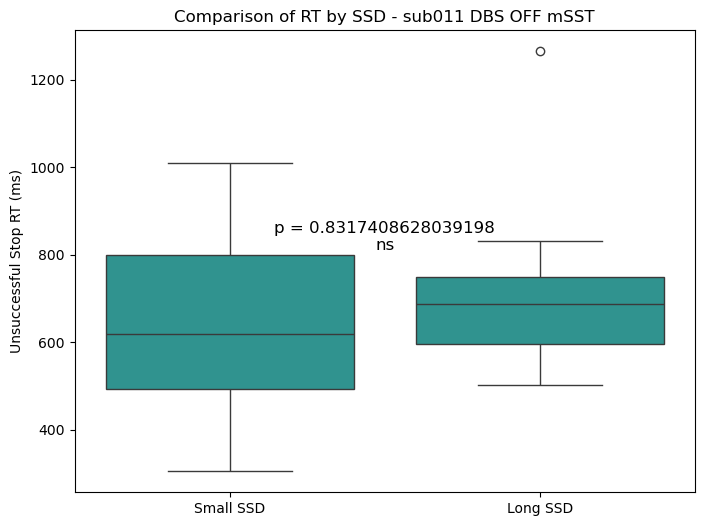

sub011 DBS ON mSST


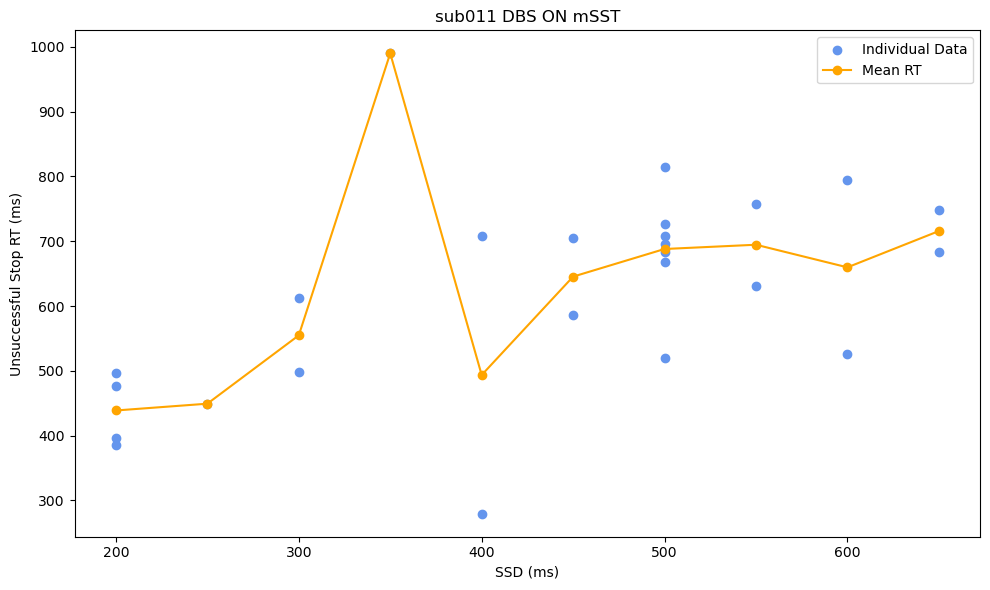

Data appears normally distributed (p = 0.7531807738837536 )
Data appears normally distributed (p = 0.5618689415671664 )
Mean RT (Small SSD): 599.9362263093261
Mean RT (Long SSD): 690.0175333333513
T-test p-value: 0.9394240542066629


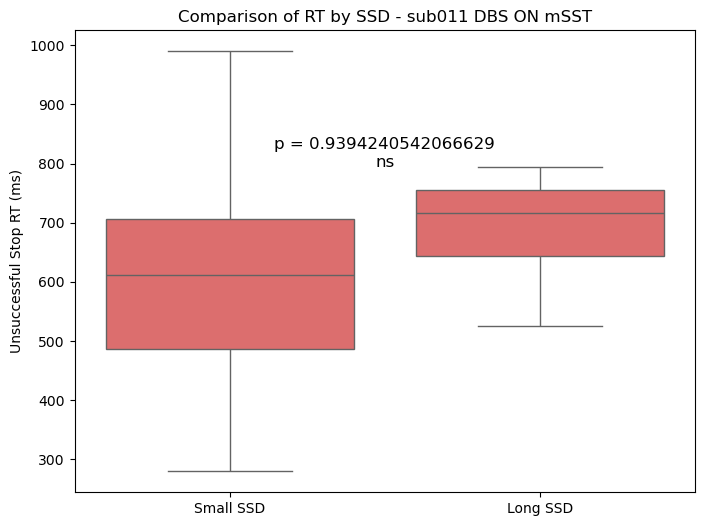

sub012 DBS ON mSST


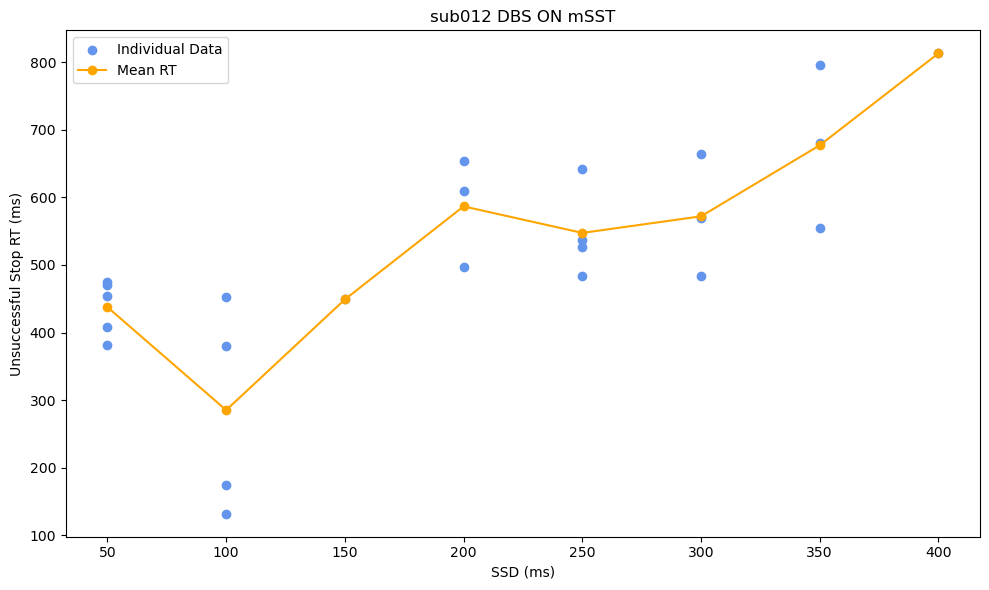

Data appears normally distributed (p = 0.13667565688626981 )
Data appears normally distributed (p = 0.15309498624659418 )
Mean RT (Small SSD): 426.0524076481278
Mean RT (Long SSD): 610.1740916492417
T-test p-value: 0.9995888229431721


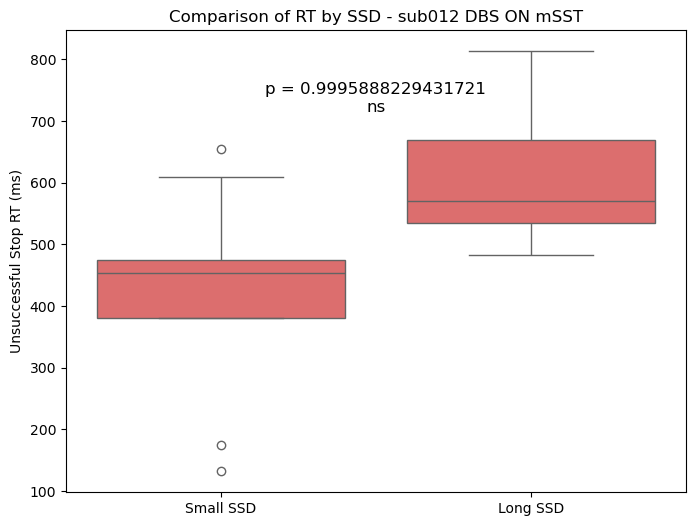

sub013 DBS OFF mSST


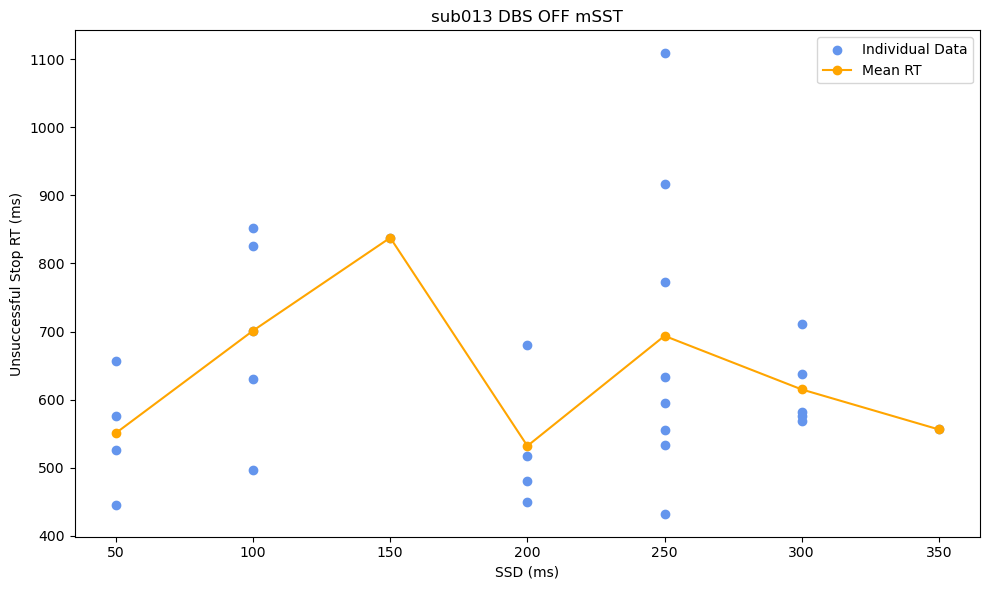

Data appears normally distributed (p = 0.13188295787194443 )
Data does NOT appear normal (p = 0.013676024025922653 )
Mean RT (Small SSD): 619.8512928571063
Mean RT (Long SSD): 655.837564285808
T-test p-value: 0.7171331568611685


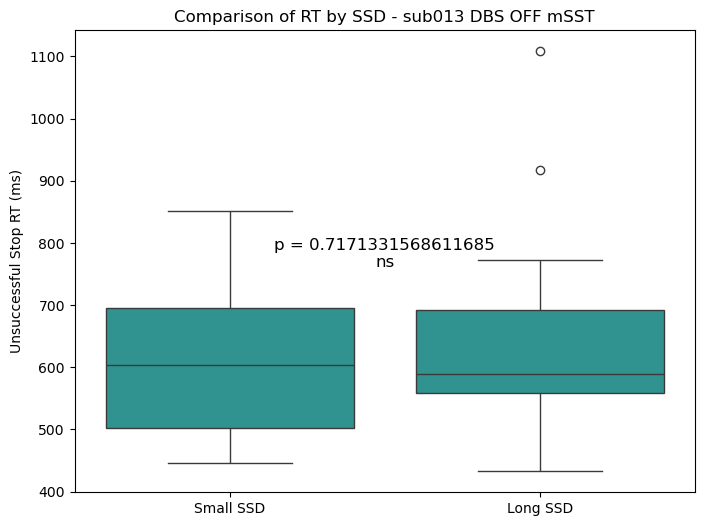

sub014 DBS ON mSST


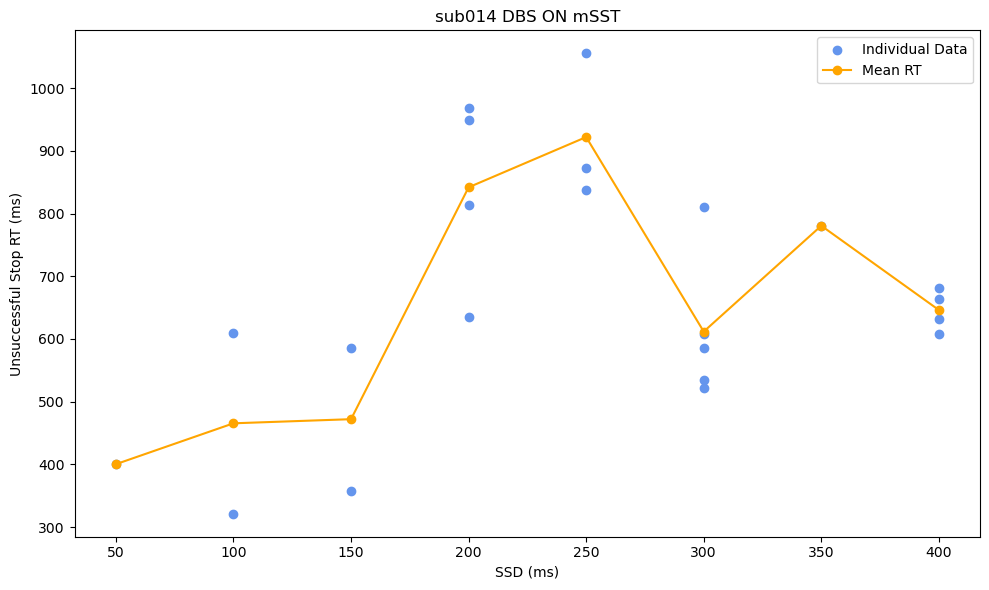

Data appears normally distributed (p = 0.38237286041216423 )
Data appears normally distributed (p = 0.45909417997808255 )
Mean RT (Small SSD): 700.7630000007339
Mean RT (Long SSD): 642.4408500082791
T-test p-value: 0.18668901284022799


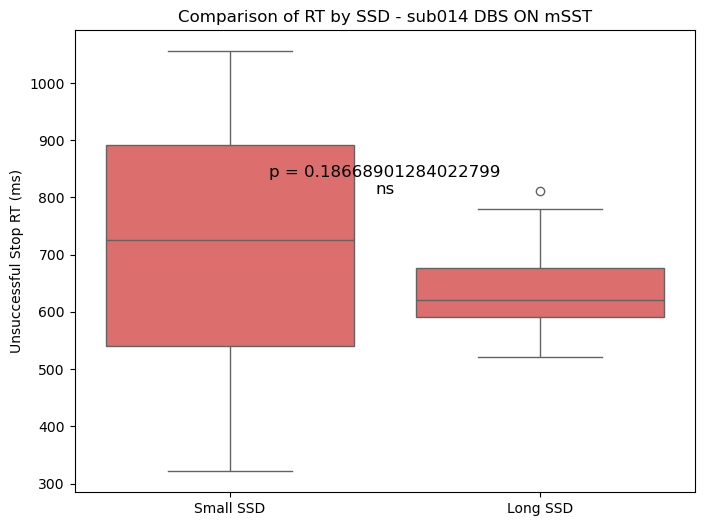

sub015 DBS OFF mSST


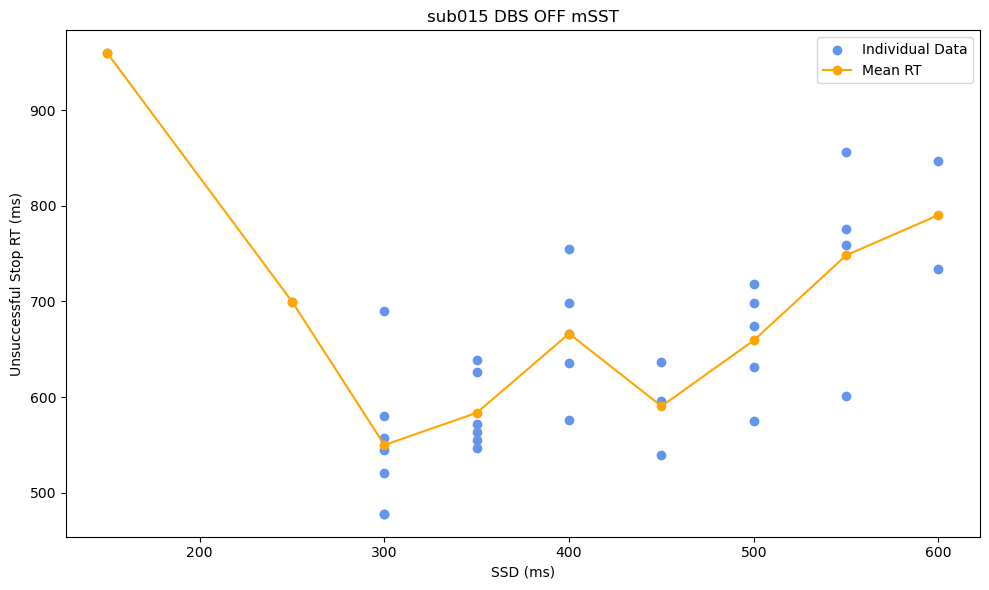

Data does NOT appear normal (p = 0.012652090606333884 )
Data appears normally distributed (p = 0.7466615565269483 )
Mean RT (Small SSD): 617.0393750013318
Mean RT (Long SSD): 688.6456214456952
T-test p-value: 0.985630359037418


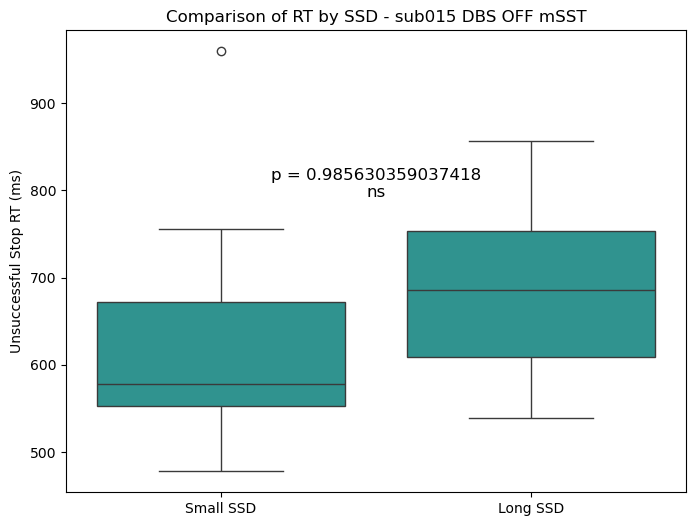

sub015 DBS ON mSST


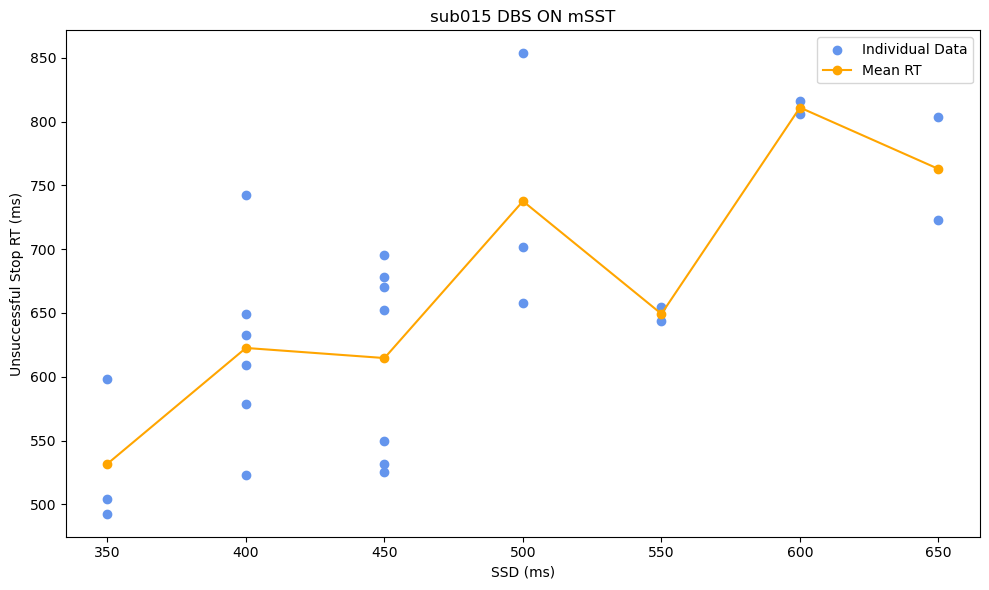

Data appears normally distributed (p = 0.547877453255277 )
Data appears normally distributed (p = 0.18335486889915487 )
Mean RT (Small SSD): 602.0895687470329
Mean RT (Long SSD): 739.8979222117406
T-test p-value: 0.9993097146869618


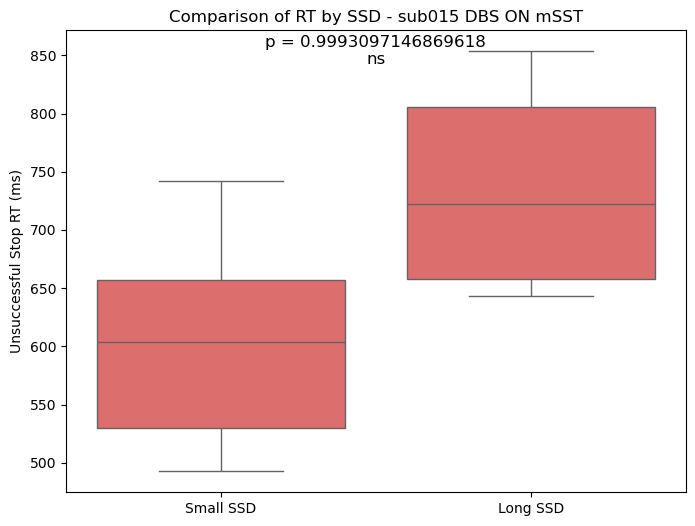

sub017 DBS ON mSST


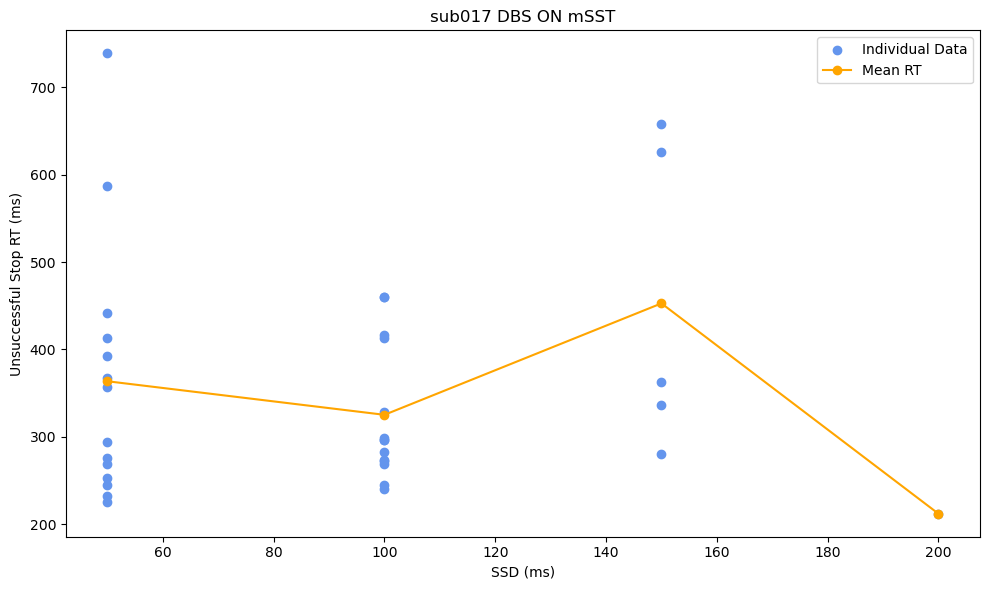

Data does NOT appear normal (p = 0.00029137738205940944 )
Data appears normally distributed (p = 0.2161575347372821 )
Mean RT (Small SSD): 344.3650785567505
Mean RT (Long SSD): 412.61911667728174
T-test p-value: 0.7670309553693051


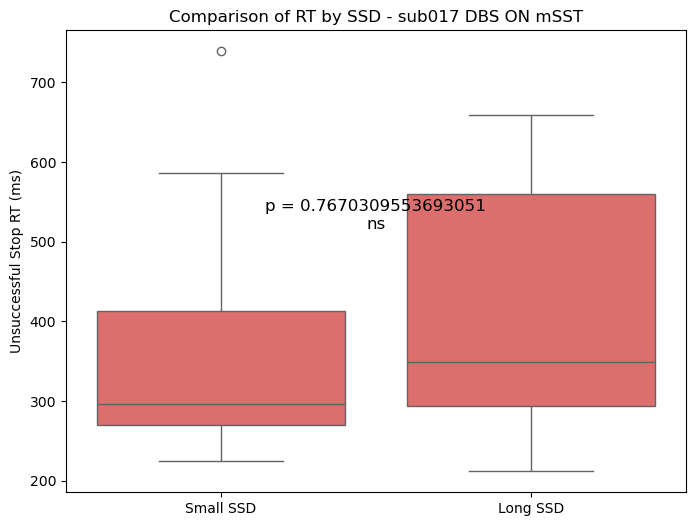

sub017 DBS OFF mSST


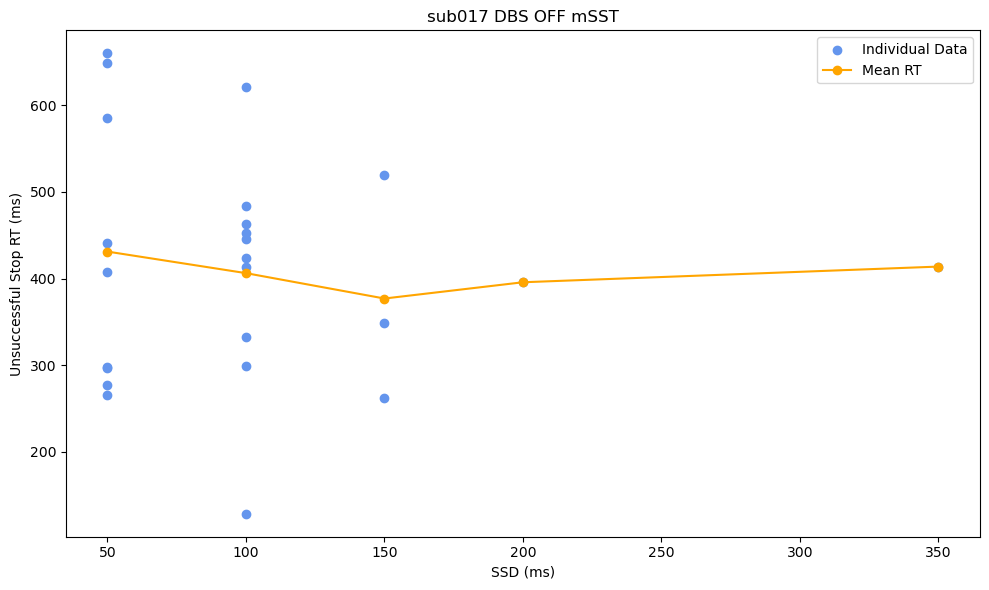

Data appears normally distributed (p = 0.4810676854802969 )
Data appears normally distributed (p = 0.9595521851302335 )
Mean RT (Small SSD): 418.02845260520513
Mean RT (Long SSD): 388.04637999273837
T-test p-value: 0.2904197252023339


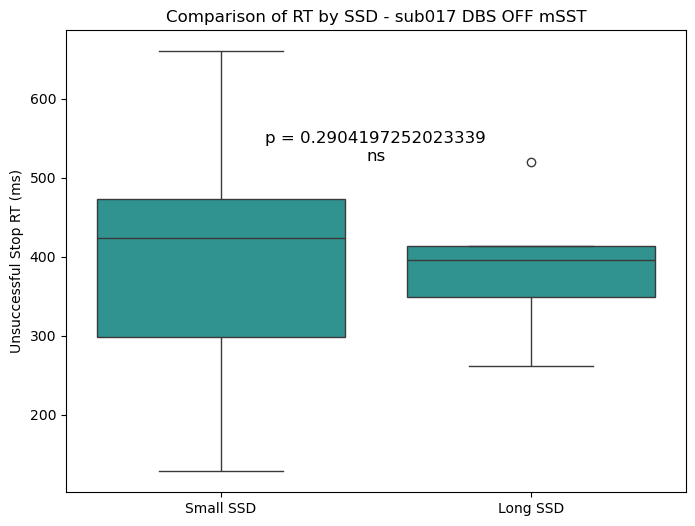

sub019 DBS ON mSST


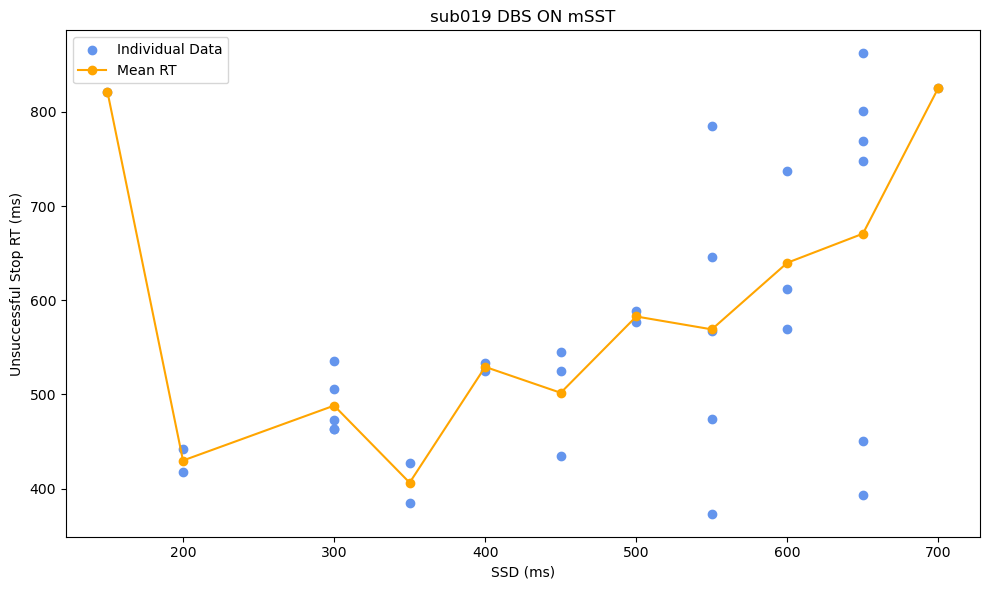

Data does NOT appear normal (p = 0.004936873433958819 )
Data appears normally distributed (p = 0.23067505160478624 )
Mean RT (Small SSD): 509.64374117114966
Mean RT (Long SSD): 641.0232266644016
T-test p-value: 0.989375408626558


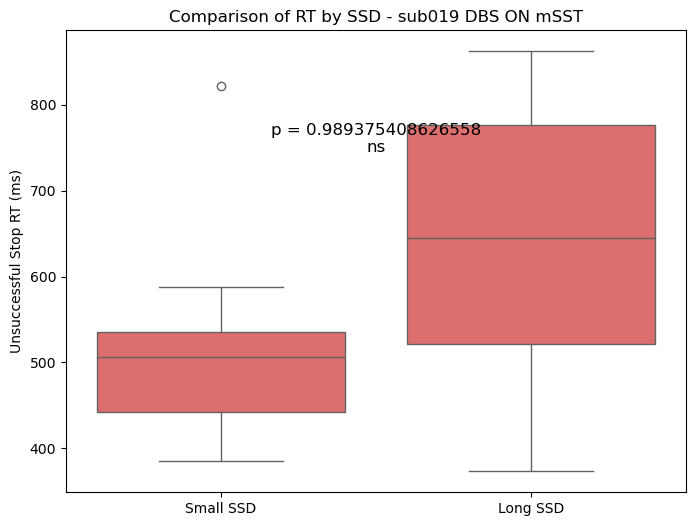

sub019 DBS OFF mSST


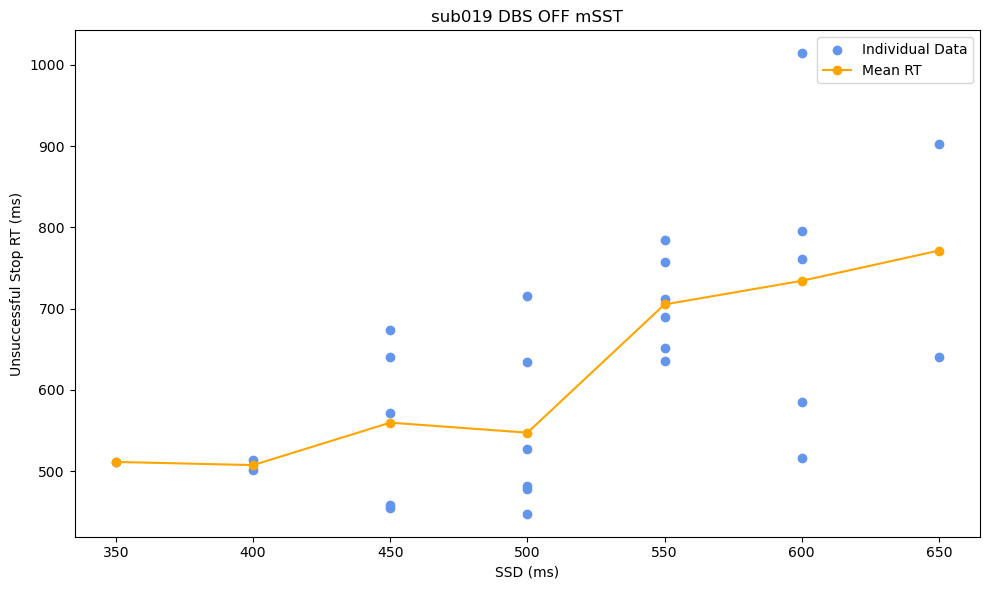

Data appears normally distributed (p = 0.0660405899520332 )
Data appears normally distributed (p = 0.8268546079424496 )
Mean RT (Small SSD): 543.559671362995
Mean RT (Long SSD): 726.5505769755691
T-test p-value: 0.9997394027374218


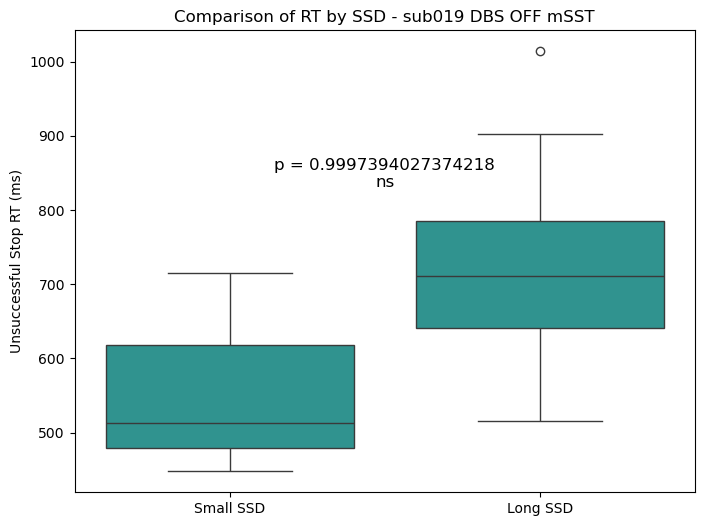

sub020 DBS ON mSST


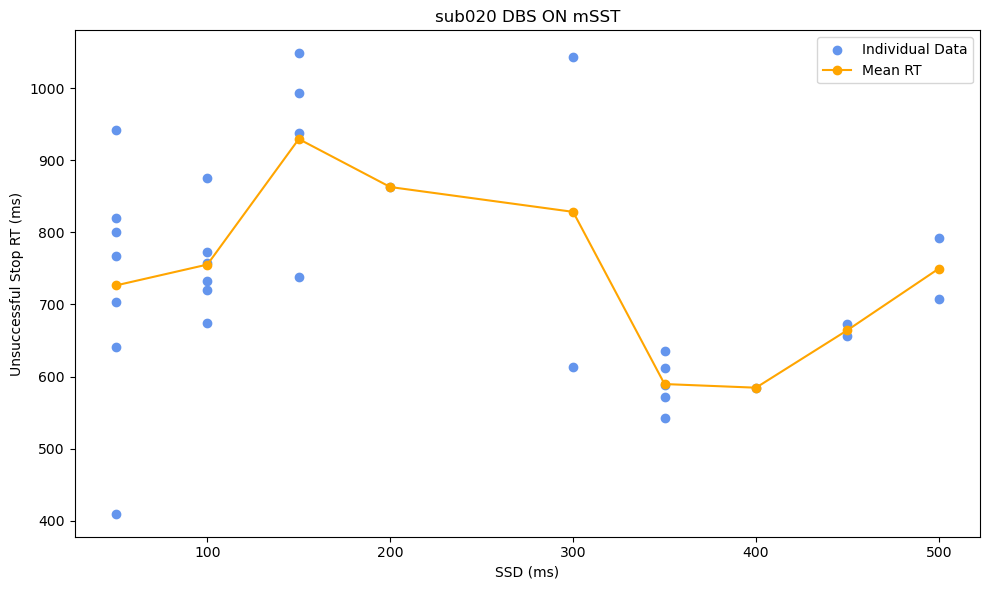

Data appears normally distributed (p = 0.4460394599651192 )
Data does NOT appear normal (p = 0.015593333163331913 )
Mean RT (Small SSD): 784.5084000077537
Mean RT (Long SSD): 683.1399615442094
T-test p-value: 0.00852680565183939


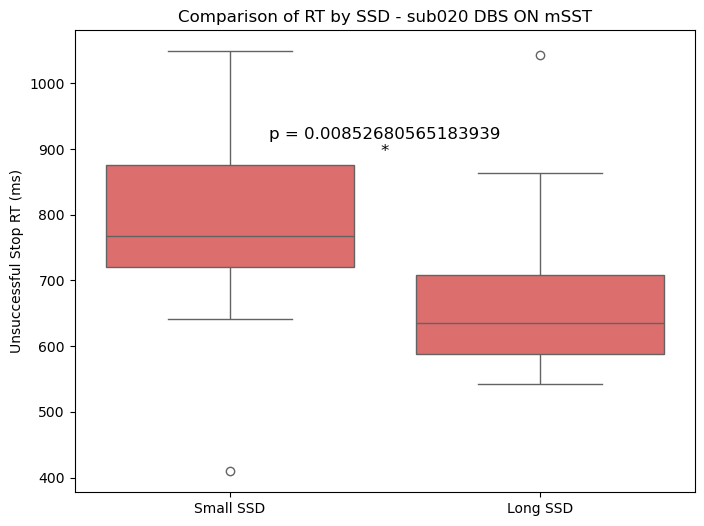

sub021 DBS OFF mSST


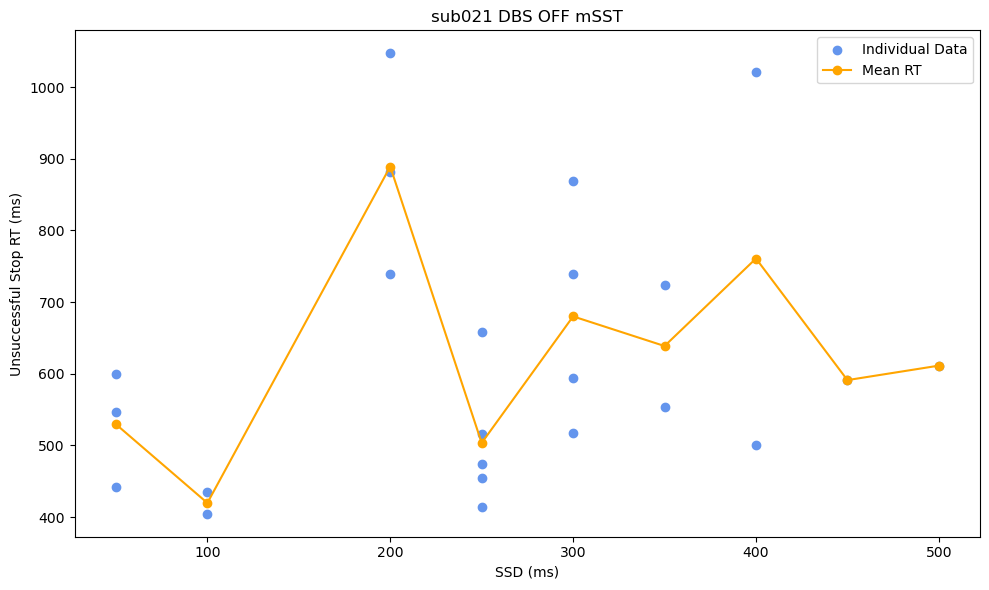

Data does NOT appear normal (p = 0.02270227383043623 )
Data appears normally distributed (p = 0.1389808272643766 )
Mean RT (Small SSD): 585.6319230873711
Mean RT (Long SSD): 672.2384899621829
T-test p-value: 0.9431115936098444


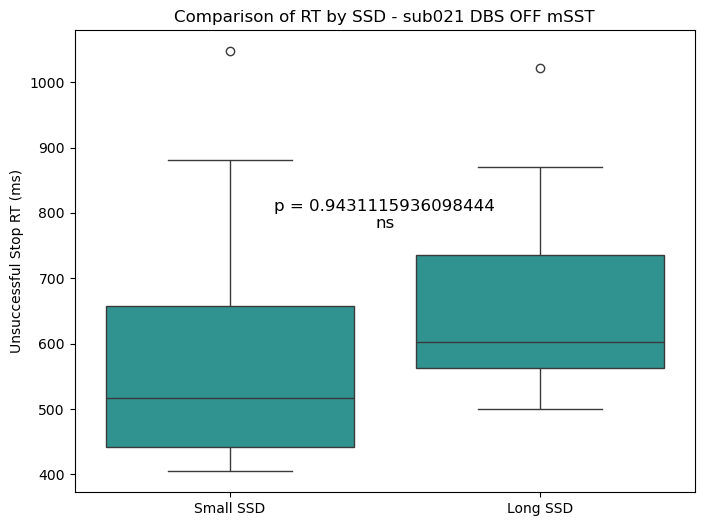

sub021 DBS ON mSST


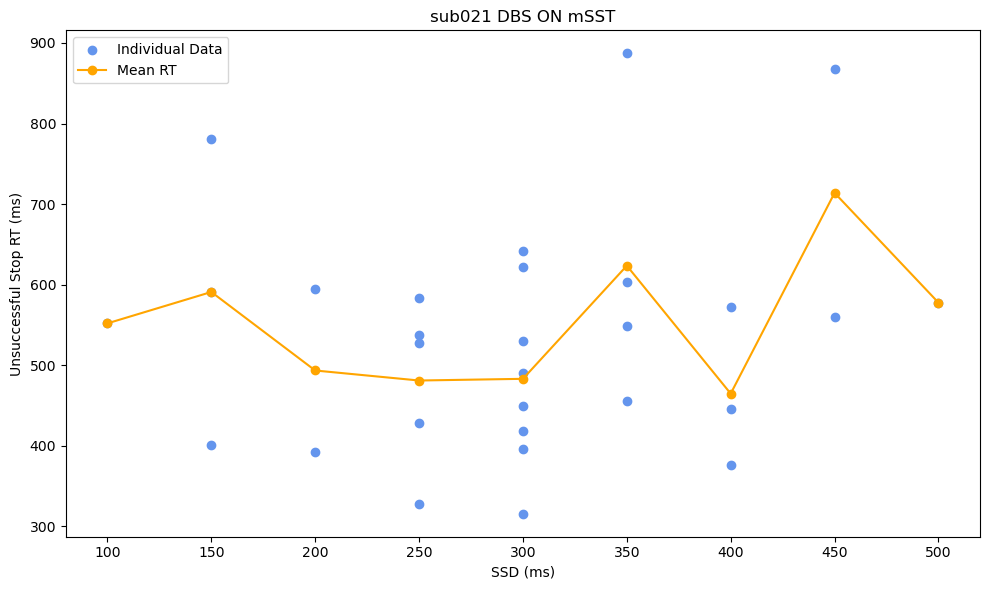

Data appears normally distributed (p = 0.6896226101412131 )
Data appears normally distributed (p = 0.08145411689089366 )
Mean RT (Small SSD): 504.34364211794576
Mean RT (Long SSD): 589.4126599188894
T-test p-value: 0.8964871959215324


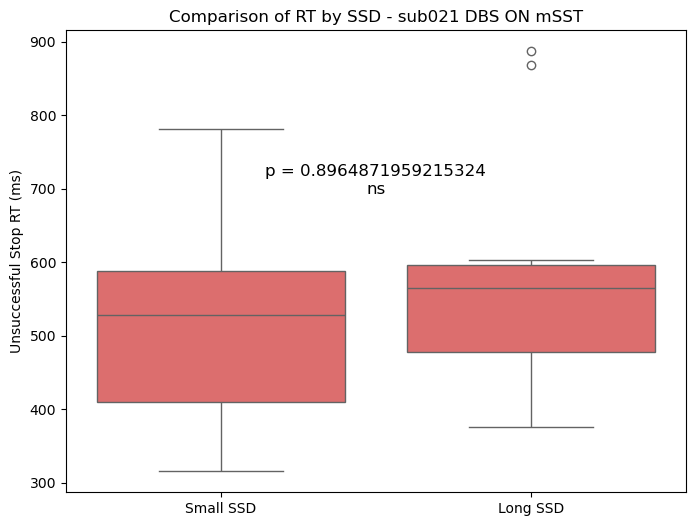

sub022 DBS ON mSST


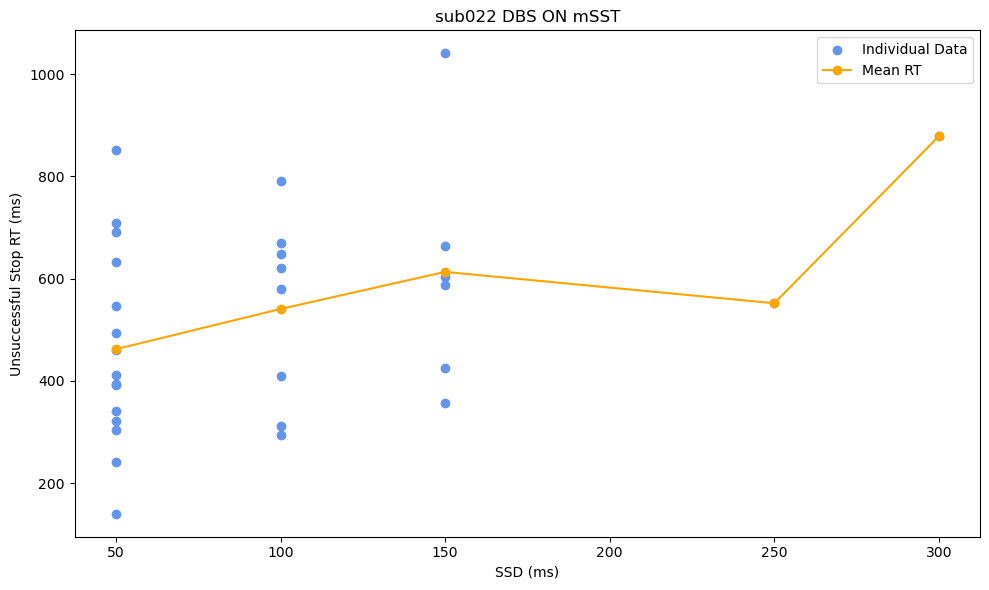

Data appears normally distributed (p = 0.6784006951538394 )
Data appears normally distributed (p = 0.5845275666552557 )
Mean RT (Small SSD): 489.5015826003383
Mean RT (Long SSD): 638.7546125915833
T-test p-value: 0.9395358565547665


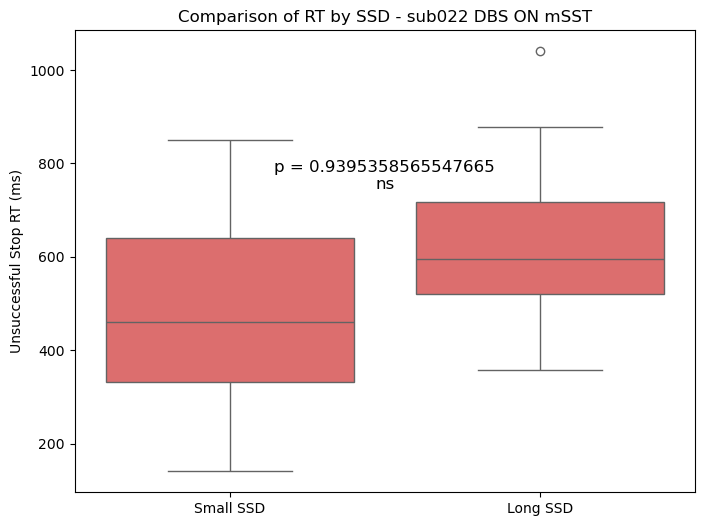

sub023 DBS OFF mSST


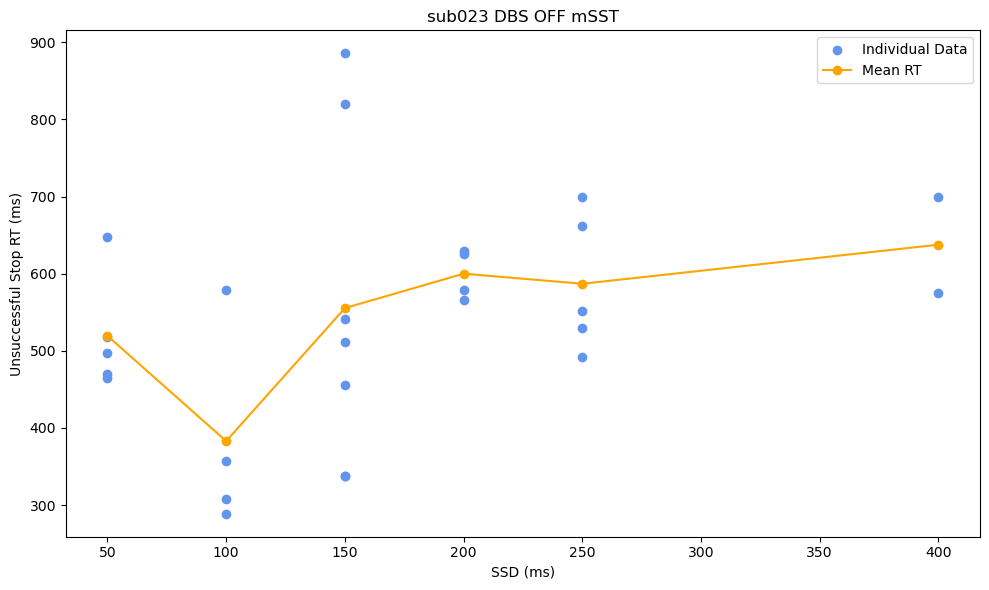

Data appears normally distributed (p = 0.09904358697088149 )
Data appears normally distributed (p = 0.688392597952163 )
Mean RT (Small SSD): 501.00210623349994
Mean RT (Long SSD): 600.8731817657298
T-test p-value: 0.9916511928699199


sub023 DBS ON mSST


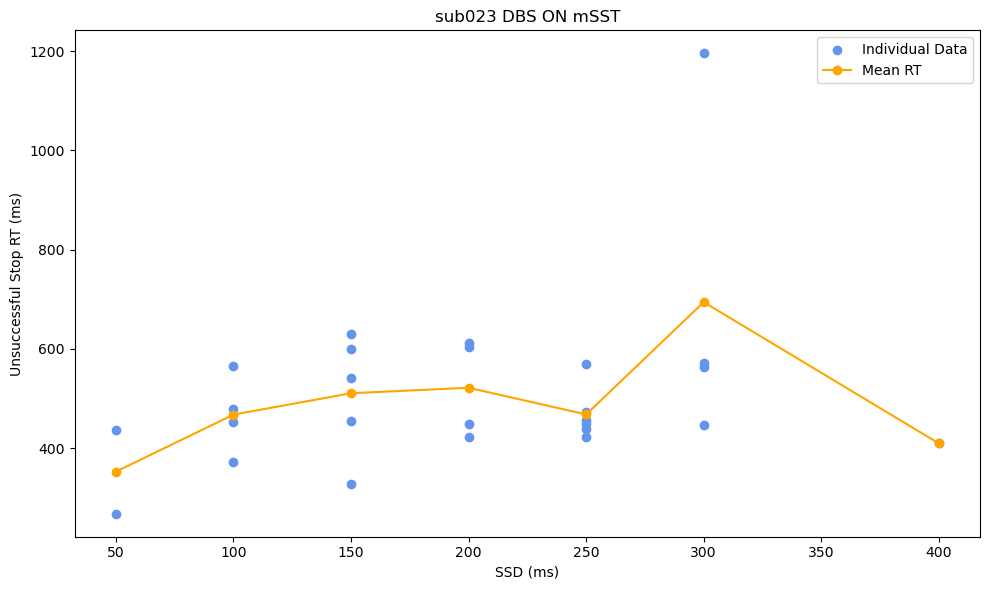

Data appears normally distributed (p = 0.44912010906681327 )
Data does NOT appear normal (p = 1.2908135652358908e-05 )
Mean RT (Small SSD): 480.8072133300205
Mean RT (Long SSD): 544.7060091590339
T-test p-value: 0.5618651681861191


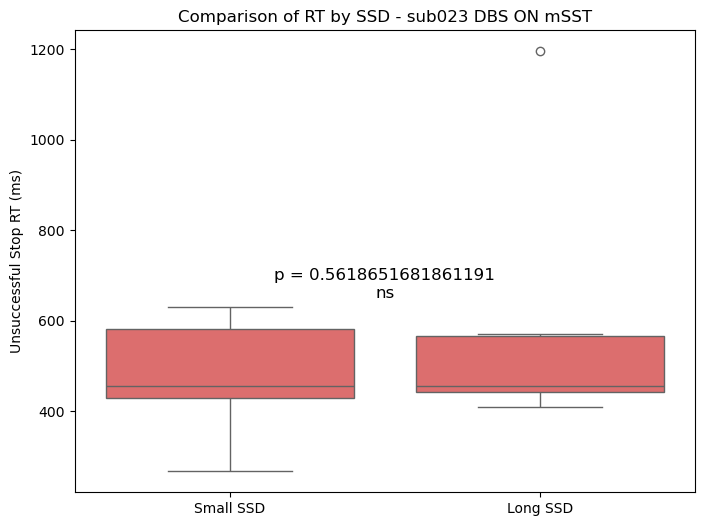

sub024 DBS ON mSST


Data does NOT appear normal (p = 0.030695817468538125 )
Data appears normally distributed (p = 0.17261665545074006 )
Mean RT (Small SSD): 463.07432496299344
Mean RT (Long SSD): 560.5372091416608
T-test p-value: 0.9342061967966657


sub024 DBS OFF mSST


Data appears normally distributed (p = 0.1721073506129579 )
Data appears normally distributed (p = 0.5651476348974724 )
Mean RT (Small SSD): 467.9898077335495
Mean RT (Long SSD): 488.77076389776033
T-test p-value: 0.6139705151246326


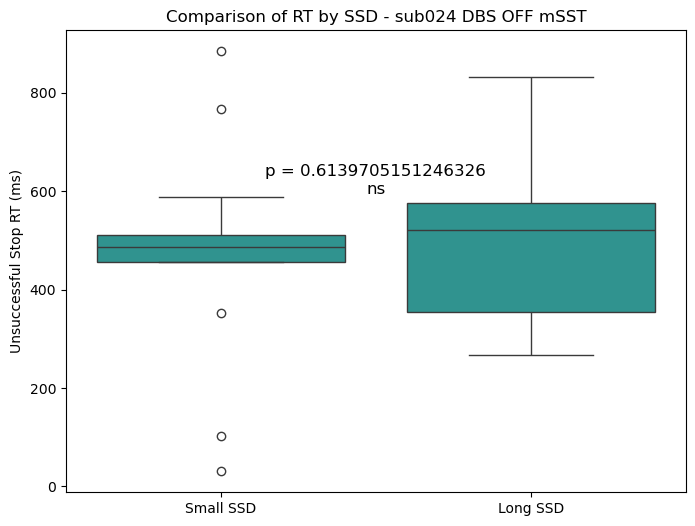

Excel file saved as 'p_values_independance_test_SSD.xlsx'.


In [39]:
p_value_dict_SSD = {}

for subject in stats:
    print(f'{subject}')
    if subject.startswith('C'):
        condition = 'control'
    elif subject.startswith('preop'):
        condition = 'preop'
    else:
        if subject.endswith('ON mSST'):
            condition = 'dbs_on'
        else:
            condition = 'dbs_off'
    u_GS_RT = stats[subject]['stop_trial RTs (ms)']
    SSD = stats[subject]['unsuccessful stop SSD (ms)']
    
    # Convert to DataFrame for easier grouping
    data = pd.DataFrame({'SSD': SSD, 'u_GS_RT': u_GS_RT})
    
    # Calculate mean RT for each unique SSD
    mean_values = data.groupby('SSD')['u_GS_RT'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    plt.scatter(SSD, u_GS_RT, label='Individual Data', color='cornflowerblue')
    plt.plot(mean_values['SSD'], mean_values['u_GS_RT'], 'o-', color='orange', label='Mean RT')
    
    plt.xlabel('SSD (ms)')
    plt.ylabel('Unsuccessful Stop RT (ms)')
    plt.title(f'{subject}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    threshold = np.median(SSD) 
    small_ssd = data[data['SSD'] <= threshold]
    long_ssd = data[data['SSD'] > threshold]

    # Calculate mean RT
    mean_small = small_ssd['u_GS_RT'].mean()
    mean_long = long_ssd['u_GS_RT'].mean()

    stat, p = scipy.stats.shapiro(small_ssd['u_GS_RT'])
    if p > 0.05:
        print("Data appears normally distributed (p =", p, ")")
    else:
        print("Data does NOT appear normal (p =", p, ")")

    stat, p = scipy.stats.shapiro(long_ssd['u_GS_RT'])
    if p > 0.05:
        print("Data appears normally distributed (p =", p, ")")
    else:
        print("Data does NOT appear normal (p =", p, ")")    

    """
    # Perform a t-test or non-parametric test
    t_stat, p_value = ttest_ind(small_ssd['u_GS_RT'], long_ssd['u_GS_RT'], alternative='greater')

    Based on the shapiro test, half of my data does not appear normally distributed. 
    Therefore, a mann whitney test would be better (non parametric test):
    """

    # Perform a non-parametric test (mann whitney):
    #u_stat, p_value = ttest_ind(small_ssd['u_GS_RT'], long_ssd['u_GS_RT'], alternative='greater')
    stat, p_value = scipy.stats.mannwhitneyu(small_ssd['u_GS_RT'], long_ssd['u_GS_RT'], alternative='greater')
    p_value_dict_SSD[subject] = p_value

    print(f"Mean RT (Small SSD): {mean_small}")
    print(f"Mean RT (Long SSD): {mean_long}")
    print(f"T-test p-value: {p_value}")

    plt.figure(figsize=(8, 6))
    sns.boxplot(x=['Small SSD']*len(small_ssd) + ['Long SSD']*len(long_ssd),
                y=pd.concat([small_ssd['u_GS_RT'], long_ssd['u_GS_RT']]),
                color=color_dict[condition]
                )
    # Annotate statistical results
    if p_value is not None:
        annotation = "ns" if p_value >= 0.05 else "*"    
        plt.text(0.5, max(mean_small, mean_long) + 100, f"p = {p_value}\n{annotation}", 
                    ha='center', va='bottom', color='black', fontsize=12)
    plt.ylabel('Unsuccessful Stop RT (ms)')
    plt.title(f'Comparison of RT by SSD - {subject}')
    plt.show()


# Convert dictionary to DataFrame
df_p_value_dict_SSD = pd.DataFrame(list(p_value_dict_SSD.items()), columns=['Subject', 'P-Value'])

# Save to Excel
df_p_value_dict_SSD.to_excel(join(behav_results_saving_path,'p_values_independance_test_SSD.xlsx'), index=False)

print("Excel file saved as 'p_values_independance_test_SSD.xlsx'.")

## Replication of the Hervault et al paper from 2021 ##

""A prediction of the model is that the RT in unsuccessful STOP trials should lengthen with increasing Stop signal delay (SSD), because gradually more movements fail to be inhibited as the STOP signal is delayed. In order to examine this prediction, RT from unsuccessful STOP trials were averaged across participants at each given SSD. From these mean values, the differences were then computed between each SSD and the immediately shorter SSD. A one–sided t-test showed the differential values to be significantly positive for both the pressing (t(6) = 3.42, p <.05) and the swiping type (t(6) = 3.47, p < .05), which confirmed the expected increase of the RT(unsuccessful STOP trials) as function of SSD". 

In [41]:
from scipy.stats import ttest_1samp

ssds = []
rt_failed_stop = []
subs = []
for sub in stats.keys():
    ssds.append(stats[sub]['unsuccessful stop SSD (ms)'])
    rt_failed_stop.append(stats[sub]['stop_trial RTs (ms)'])
    subs.append(sub)

# Create a DataFrame for the SSD and RT data
df_ssd_rt = pd.DataFrame({
    'Subject': subs,
    'SSD (ms)': ssds,
    'RT Failed Stop (ms)': rt_failed_stop
})

long_data = []

for idx, row in df_ssd_rt.iterrows():
    subject = row['Subject']
    ssds = row['SSD (ms)']
    rts = row['RT Failed Stop (ms)']
    
    for ssd, rt in zip(ssds, rts):
        long_data.append({'Subject': subject, 'SSD': ssd, 'RT': rt})

df_long = pd.DataFrame(long_data)

# Step 2: Bin SSDs into 50ms bins
bin_size = 50
df_long['SSD_bin'] = (df_long['SSD'] // bin_size) * bin_size  # e.g., 0–49 => 0, 50–99 => 50, etc.

# Step 3: Compute average RT per subject per bin
mean_rt_per_sub_bin = df_long.groupby(['Subject', 'SSD_bin'])['RT'].mean().reset_index()

# Step 4: Compute average RT across subjects per SSD bin
mean_rt_per_bin = mean_rt_per_sub_bin.groupby('SSD_bin')['RT'].mean().sort_index()

# Step 5: Compute differences between consecutive SSD bins
ssd_bins = mean_rt_per_bin.index.to_list()
rt_means = mean_rt_per_bin.values
rt_diffs = np.diff(rt_means)

# Step 6: One-sided t-test: Are the differences significantly > 0?
t_stat, p_value = ttest_1samp(rt_diffs, popmean=0, alternative='greater')
df = len(rt_diffs) - 1
print(f"t({df}) = {t_stat:.3f}, p = {p_value:.4f}")
# Output the results
print("SSD bins (ms):", ssd_bins)
print("Mean RT per bin (ms):", rt_means)
print("RT differences between bins:", rt_diffs)
print(f"One-sided t-test result: t = {t_stat:.3f}, p = {p_value:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(ssd_bins, rt_means, marker='o', linestyle='-')
plt.xlabel('SSD (ms)')
plt.ylabel('Mean RT (Failed STOP Trials)')
plt.title('RTs on failed STOP trials increase with SSD')
plt.show()


t(15) = 1.994, p = 0.0324
SSD bins (ms): [50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 500.0, 550.0, 600.0, 650.0, 700.0, 750.0, 800.0, 850.0]
Mean RT per bin (ms): [466.10199971 480.54492507 601.02292815 533.73412768 557.54894051
 600.91627841 589.15957464 579.02120041 640.85205179 635.50524253
 734.25506998 684.56089445 813.55635334 761.0724083  831.38612495
 970.54840002 990.7346    ]
RT differences between bins: [ 14.44292536 120.47800308 -67.28880047  23.81481284  43.3673379
 -11.75670377 -10.13837423  61.83085137  -5.34680926  98.74982745
 -49.69417552 128.99545888 -52.48394504  70.31371665 139.16227507
  20.18619998]
One-sided t-test result: t = 1.994, p = 0.0324


The differential values were significantly positive (t(15) = 1.996, p = 0.0322) which confirms the prediction of the model, that the RT in unsuccessful STOP trials should lengthen with increasing Stop signal delay (SSD).

## 3.c. Check the success rate / omission ##

Participants should have a good success rate to evaluate further behavioral measures. If the success rate is too low, they might have not understood the task sufficiently well to make any further deduction, and should be excluded. For example, success rates on GO, GF and GC trials should be as close as possible to 100%. Success rates on GS trials should be close to 50%.

In [42]:
# separate the stats dictionary into 4 dictionaries: one for the DBS OFF condition, one for the DBS ON condition, one for the control group and one for the preop group:
stats_dbs_off = {}
stats_dbs_on = {}
stats_control = {}
stats_preop = {}

for subject in stats:
    if subject.startswith('sub'):
        if 'OFF' in subject:
            stats_dbs_off[subject] = stats[subject]
        elif 'ON' in subject:
            stats_dbs_on[subject] = stats[subject]
    elif subject.startswith('C'):
        stats_control[subject] = stats[subject]
    elif subject.startswith('preop'):
        stats_preop[subject] = stats[subject]


In [43]:
# Create plots to compare groups:
# Plot the percentage of correct trials for each trial type across the 3 groups:
trial_types = ['go_trial', 'stop_trial', 'go_fast_trial', 'go_continue_trial']
bar_width = 0.2
index = np.arange(len(trial_types))
opacity = 0.8

# Define conditions and corresponding dictionaries
conditions = {
    'control': stats_control,
    'dbs_off': stats_dbs_off,
    'dbs_on': stats_dbs_on, 
    'preop': stats_preop
}

# Initialize dictionaries to hold results for each condition
results = {condition: [] for condition in conditions.keys()}

# Loop through each condition and subject
for condition, data_dict in conditions.items():
    for subject_id, metrics in data_dict.items():
        # Retrieve the required metrics and store them in the result dictionary
        results[condition].append([
            metrics['percent correct go_trial'],
            metrics['percent correct stop_trial'],
            metrics['percent correct go_fast_trial'],
            metrics['percent correct go_continue_trial']
        ])

# Access data for each condition
control = results['control']
dbs_off = results['dbs_off']
dbs_on = results['dbs_on']
preop = results['preop']

# Number of subjects in each condition
n_control = len(control)
n_dbs_off = len(dbs_off)
n_dbs_on = len(dbs_on)
n_preop = len(preop)

# Calculate means and standard deviations for each condition
control_means = np.mean(control, axis=0)
control_std = np.std(control, axis=0)

dbs_off_means = np.mean(dbs_off, axis=0)
dbs_off_std = np.std(dbs_off, axis=0)

dbs_on_means = np.mean(dbs_on, axis=0)
dbs_on_std = np.std(dbs_on, axis=0)

preop_means = np.mean(preop, axis = 0)
preop_std = np.std(preop, axis = 0)

# Update error bars with standard deviations
error_control = control_std
error_dbs_off = dbs_off_std
error_dbs_on = dbs_on_std
error_preop = preop_std

# Define plotting parameters
index = np.arange(len(control_means))  # Assuming each metric is a separate bar
bar_width = 0.2
opacity = 0.8

# Plot bars with error bars
plt.figure(figsize=(10, 6))

bar1 = plt.bar(index, control_means, bar_width, alpha=opacity, color='#ffba49', label='Control',
               yerr=error_control, capsize=5)
bar2 = plt.bar(index + bar_width, dbs_off_means, bar_width, alpha=opacity, color='#20a39e', label='DBS OFF',
               yerr=error_dbs_off, capsize=5)
bar3 = plt.bar(index + 2 * bar_width, dbs_on_means, bar_width, alpha=opacity, color='#ef5b5b', label='DBS ON',
               yerr=error_dbs_on, capsize=5)
bar4 = plt.bar(index + 3 * bar_width, preop_means, bar_width, alpha=opacity, color='#8E7DBE', label='Pre-OP',
               yerr=error_preop, capsize=5)

# Add subject count annotations on top of each bar
for i, (mean, std) in enumerate(zip(control_means, control_std)):
    plt.text(i, mean + std + 1, f'n={n_control}', ha='center', va='bottom', color='black')

for i, (mean, std) in enumerate(zip(dbs_off_means, dbs_off_std)):
    plt.text(i + bar_width, mean + std + 1, f'n={n_dbs_off}', ha='center', va='bottom', color='black')

for i, (mean, std) in enumerate(zip(dbs_on_means, dbs_on_std)):
    plt.text(i + 2 * bar_width, mean + std + 1, f'n={n_dbs_on}', ha='center', va='bottom', color='black')

for i, (mean, std) in enumerate(zip(preop_means, preop_std)):
    plt.text(i + 3 * bar_width, mean + std + 1, f'n={n_preop}', ha='center', va='bottom', color='black')


# Add labels, title, and legend
plt.xlabel('Trial type')
plt.ylabel('Percent Correct')
plt.title('Performance Across Conditions')
plt.xticks(index + bar_width, ['Go Trial', 'Stop Trial', 'Go Fast Trial', 'Go Continue Trial'])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.savefig(join(behav_results_saving_path, f"Performance Across Conditions - Group level (all subjects).png"))


In [44]:
single_subject = {}
for subject in stats.keys():
    # Retrieve values for each trial type in both conditions
    values = [
        stats[subject]['percent correct go_trial'],
        stats[subject]['percent correct stop_trial'],
        stats[subject]['percent correct go_fast_trial'],
        stats[subject]['percent correct go_continue_trial']
    ]
    single_subject[subject] = values

In [45]:
# Define trial types
trial_types = ['go_trial', 'stop_trial', 'go_fast_trial', 'go_continue_trial']

# List to store subject data
data_list = []

# Loop through subjects in the dictionary
for subject_id, values in single_subject.items():
    
    # Identify condition
    if subject_id.startswith('C'):
        condition = 'control'
    elif subject_id.startswith('preop'):
        condition = 'preop'
    elif 'OFF' in subject_id:
        condition = 'dbs_off'
    elif 'ON' in subject_id:
        condition = 'dbs_on'
    
    # Append a dictionary for each subject
    data_list.append({
        'Subject': subject_id,
        'Condition': condition,
        'go_trial': values[0],
        'stop_trial': values[1],
        'go_fast_trial': values[2],
        'go_continue_trial': values[3]
    })

    if values[0] < 75:
        print(f"Warning: {subject_id} has a go_trial success rate below 75%: {values[0]}%")
        excluded_subjects.append(subject_id)
    if values[1] > 65:
        print(f"Warning: {subject_id} has a stop_trial success rate above 65%: {values[1]}%")
        excluded_subjects.append(subject_id)

# Convert to DataFrame
df_summary = pd.DataFrame(data_list)

# Display DataFrame
print(df_summary)

# Save to Excel
df_summary.to_excel(join(behav_results_saving_path,'summary_success_rates.xlsx'), index=False)

print("Summary DataFrame saved as 'summary_success_rates.xlsx'.")


                Subject Condition   go_trial  stop_trial  go_fast_trial  \
0         preop001 mSST     preop  93.888889   55.000000      98.333333   
1             C002 mSST   control  73.750000   60.759494      99.375000   
2             C003 mSST   control  89.166667   63.291139     100.000000   
3             C004 mSST   control  97.777778   45.000000     100.000000   
4             C006 mSST   control  94.166667   60.000000      92.500000   
5    sub006 DBS ON mSST    dbs_on  79.166667   60.000000      97.500000   
6   sub006 DBS OFF mSST   dbs_off  96.666667   51.666667     100.000000   
7   sub007 DBS OFF mSST   dbs_off  92.737430   58.333333      93.333333   
8    sub008 DBS ON mSST    dbs_on  83.333333   60.000000      71.250000   
9   sub008 DBS OFF mSST   dbs_off  78.333333   72.500000      72.500000   
10   sub009 DBS ON mSST    dbs_on  80.000000   65.000000     100.000000   
11  sub009 DBS OFF mSST   dbs_off  72.916667   71.250000      86.250000   
12  sub011 DBS OFF mSST  

In [46]:
excluded_subjects = list(set(excluded_subjects))  # Remove duplicates

In [47]:
excluded_subjects

['sub008 DBS OFF mSST',
 'C002 mSST',
 'sub024 DBS ON mSST',
 'sub017 DBS OFF mSST',
 'sub021 DBS OFF mSST',
 'sub009 DBS OFF mSST',
 'sub014 DBS ON mSST',
 'sub020 DBS ON mSST',
 'sub013 DBS OFF mSST',
 'sub024 DBS OFF mSST']

In [48]:
from collections import defaultdict
# Step 1: Organize sessions by subject ID
subject_sessions = defaultdict(list)
for subj in included_subjects:
    if subj.startswith("sub"):
        subj_id = subj.split()[0]
        subject_sessions[subj_id].append(subj)

# Step 2: Normalize excluded list by subject ID
excluded_ids = set(s.split()[0] for s in excluded_subjects)

# Step 3: Update excluded list to include both sessions (ON and OFF) or all if only one
final_excluded_subjects = set()
for subj_id in excluded_ids:
    sessions = subject_sessions.get(subj_id, [])
    final_excluded_subjects.update(sessions)

# Step 4: Also exclude subjects with only one session
for subj_id, sessions in subject_sessions.items():
    if len(sessions) == 1:
        final_excluded_subjects.update(sessions)

# Optional: Convert to sorted list for readability
final_excluded_subjects = sorted(final_excluded_subjects)

# Output
print("Final excluded subjects:")
for s in final_excluded_subjects:
    print(s)

Final excluded subjects:
sub007 DBS OFF mSST
sub008 DBS OFF mSST
sub008 DBS ON mSST
sub009 DBS OFF mSST
sub009 DBS ON mSST
sub012 DBS ON mSST
sub013 DBS OFF mSST
sub014 DBS ON mSST
sub017 DBS OFF mSST
sub017 DBS ON mSST
sub020 DBS ON mSST
sub021 DBS OFF mSST
sub021 DBS ON mSST
sub022 DBS ON mSST
sub024 DBS OFF mSST
sub024 DBS ON mSST


In [49]:
final_excluded_subjects = final_excluded_subjects + excluded_subjects

In [50]:
final_excluded_subjects


['sub007 DBS OFF mSST',
 'sub008 DBS OFF mSST',
 'sub008 DBS ON mSST',
 'sub009 DBS OFF mSST',
 'sub009 DBS ON mSST',
 'sub012 DBS ON mSST',
 'sub013 DBS OFF mSST',
 'sub014 DBS ON mSST',
 'sub017 DBS OFF mSST',
 'sub017 DBS ON mSST',
 'sub020 DBS ON mSST',
 'sub021 DBS OFF mSST',
 'sub021 DBS ON mSST',
 'sub022 DBS ON mSST',
 'sub024 DBS OFF mSST',
 'sub024 DBS ON mSST',
 'sub008 DBS OFF mSST',
 'C002 mSST',
 'sub024 DBS ON mSST',
 'sub017 DBS OFF mSST',
 'sub021 DBS OFF mSST',
 'sub009 DBS OFF mSST',
 'sub014 DBS ON mSST',
 'sub020 DBS ON mSST',
 'sub013 DBS OFF mSST',
 'sub024 DBS OFF mSST']

In [51]:
final_included_subjects = [s for s in included_subjects if s not in final_excluded_subjects]
final_included_subjects
# Save the final included subjects to a JSON file
with open(join(behav_results_saving_path, 'final_included_subjects.json'), 'w') as f:
    json.dump(final_included_subjects, f, indent=4)
    

In [52]:
final_included_subjects

['preop001 mSST',
 'C003 mSST',
 'C004 mSST',
 'C006 mSST',
 'sub006 DBS ON mSST',
 'sub006 DBS OFF mSST',
 'sub011 DBS OFF mSST',
 'sub011 DBS ON mSST',
 'sub015 DBS OFF mSST',
 'sub015 DBS ON mSST',
 'sub019 DBS ON mSST',
 'sub019 DBS OFF mSST',
 'sub023 DBS OFF mSST',
 'sub023 DBS ON mSST']

[0 1 2 3]


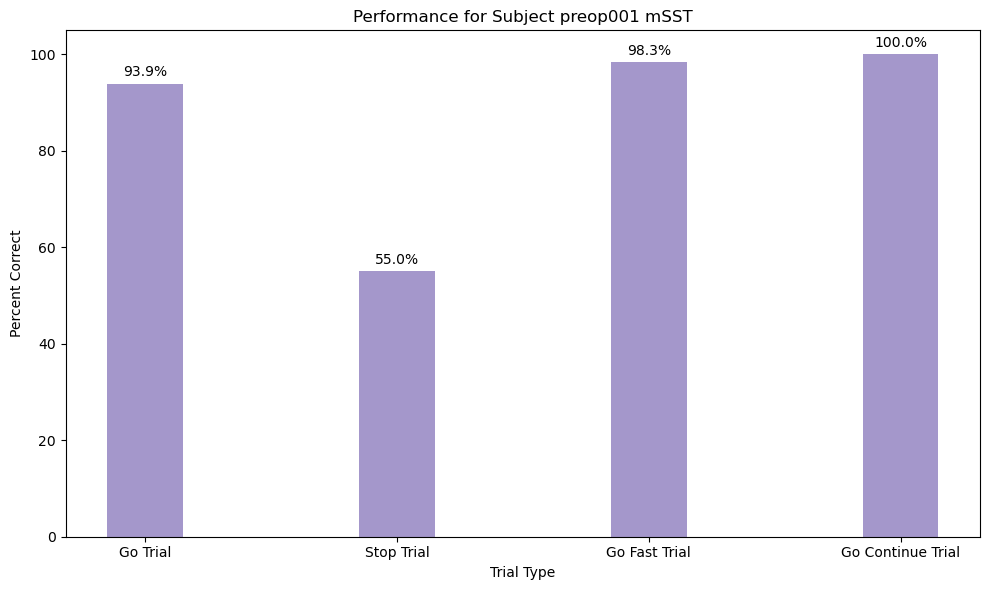

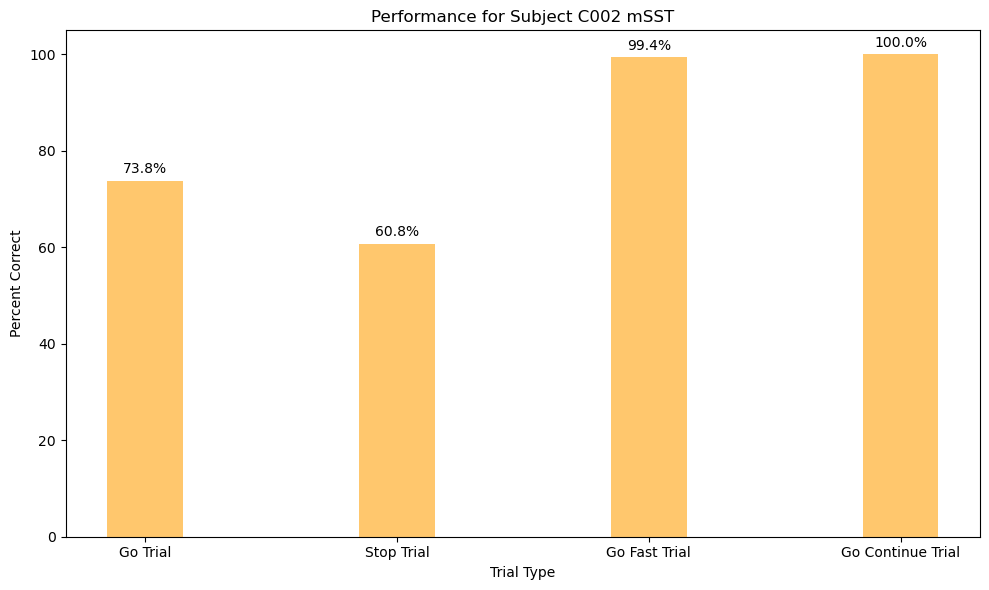

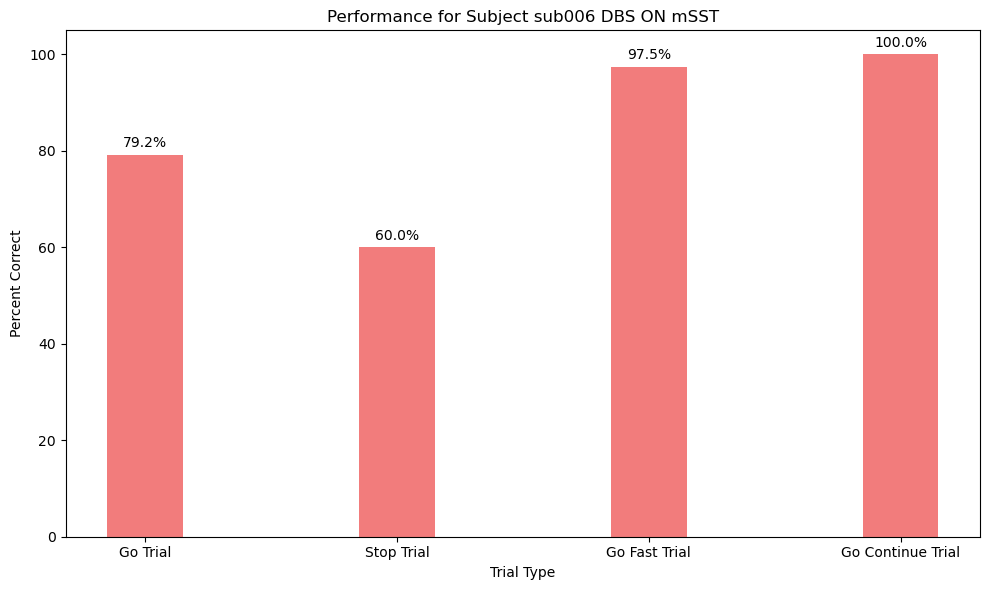

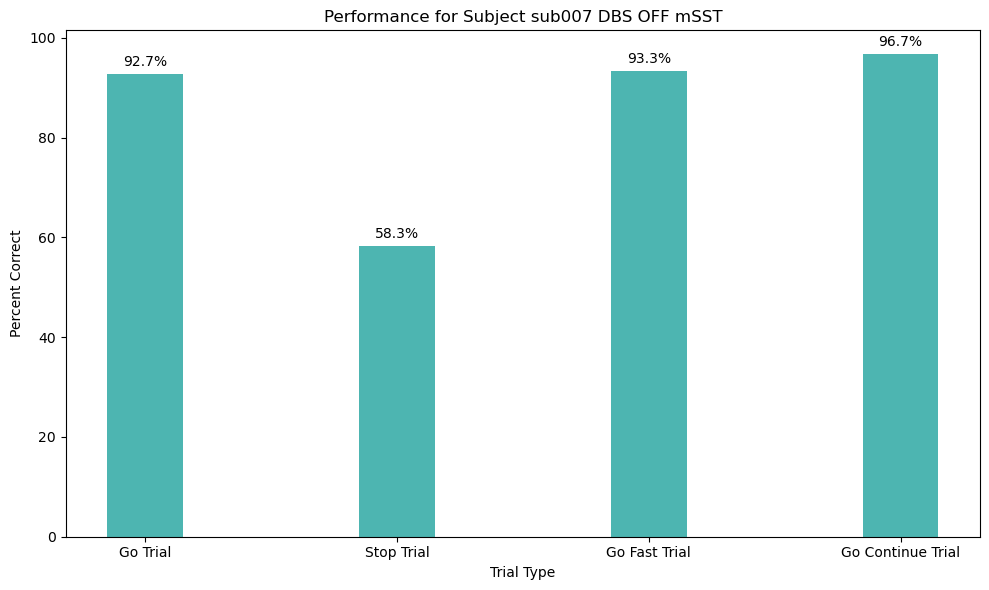

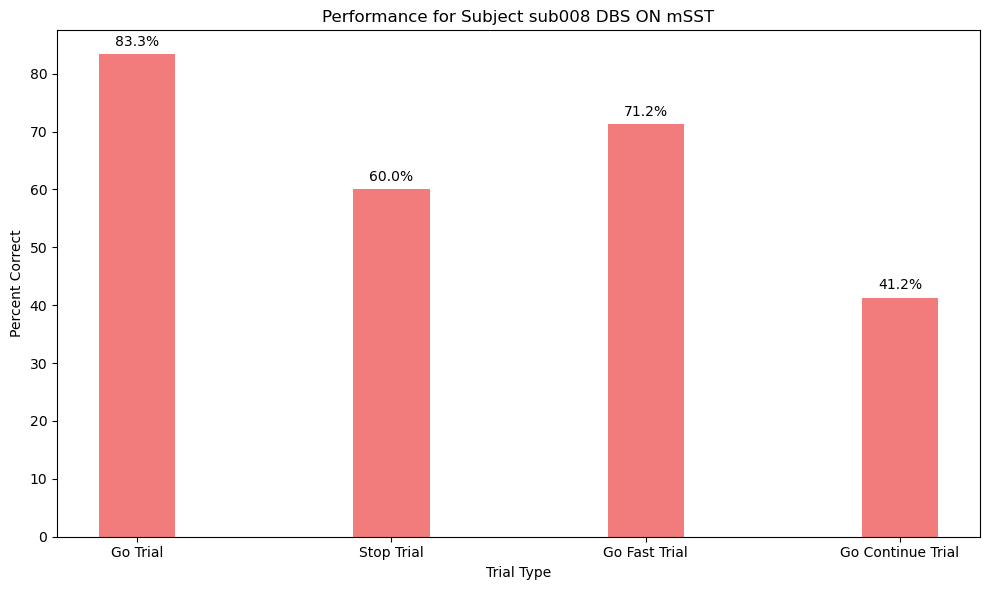

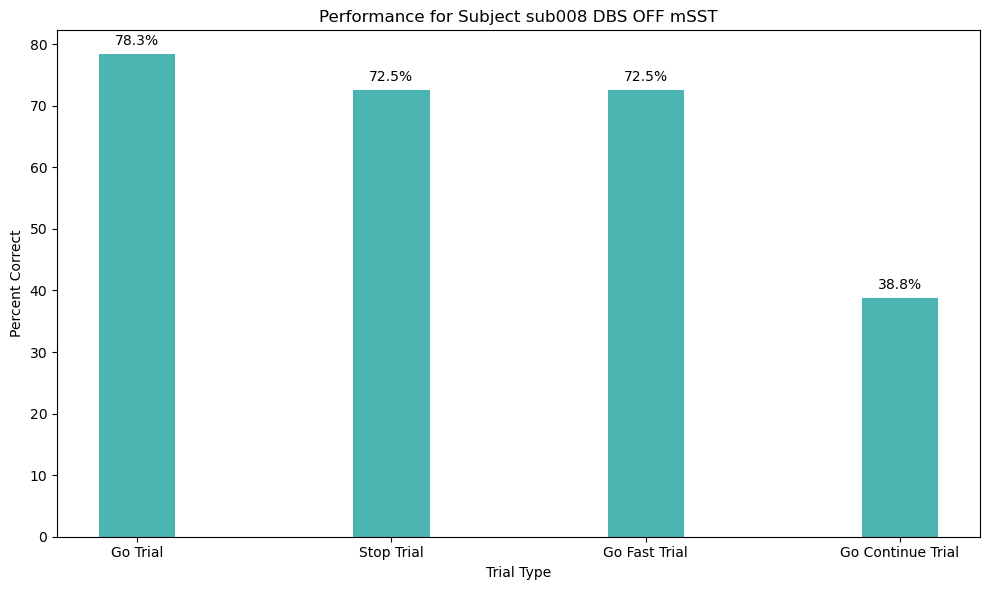

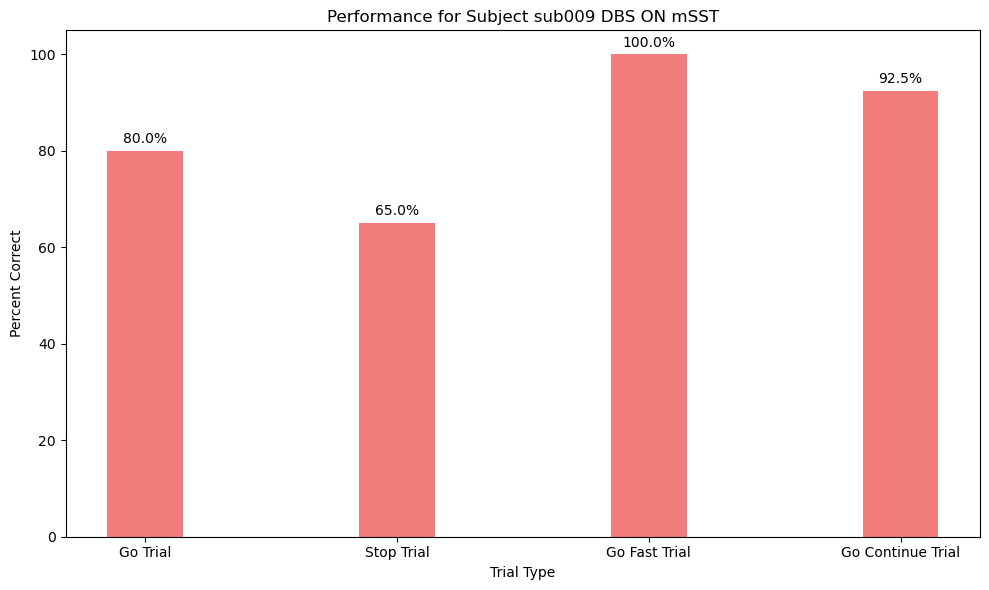

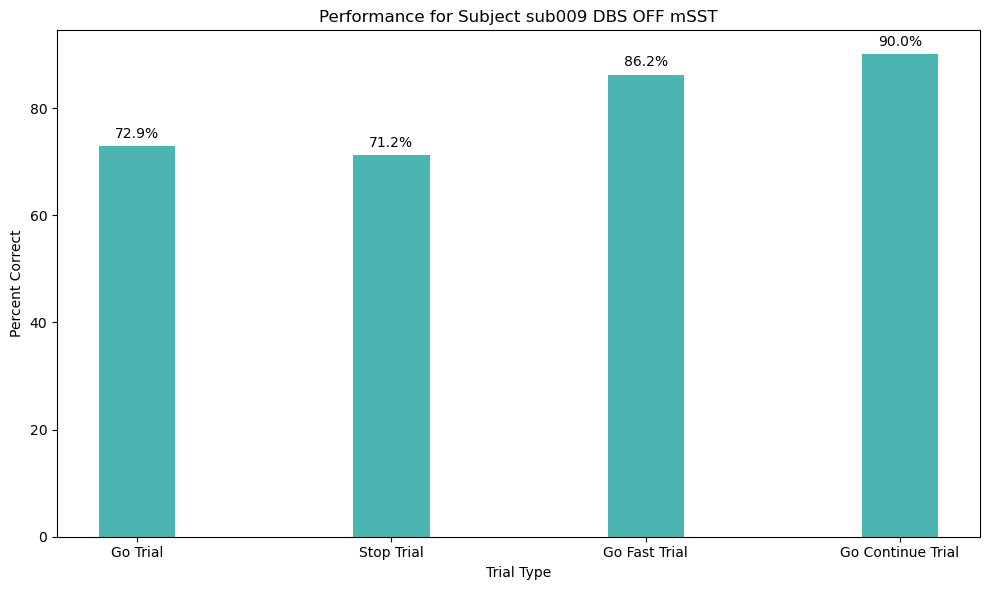

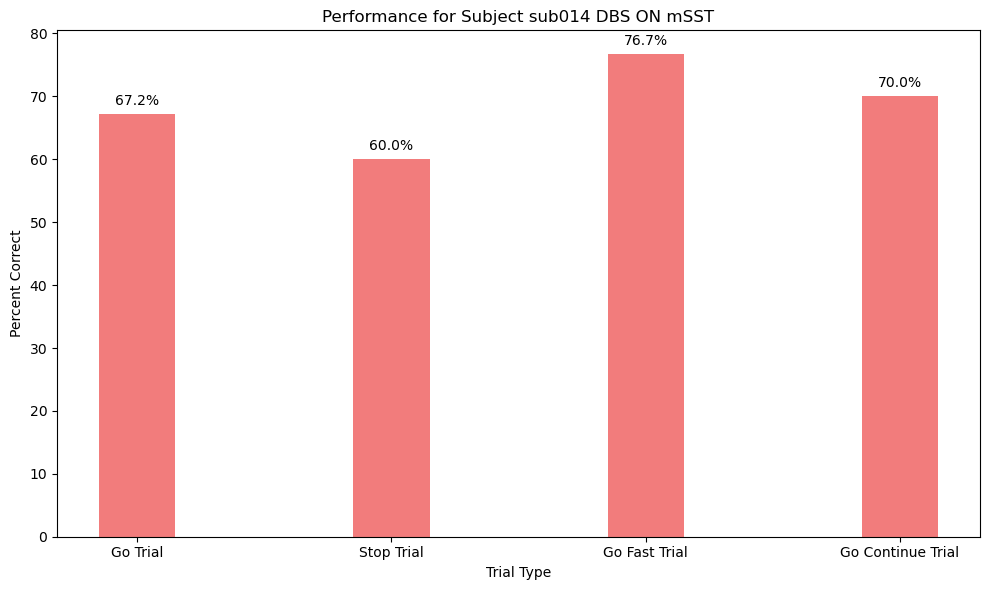

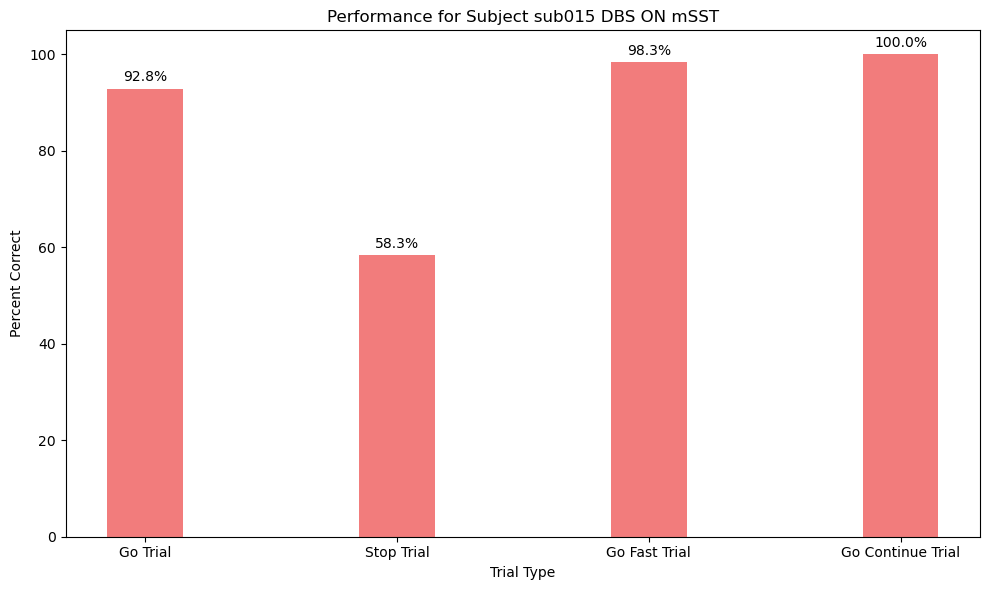

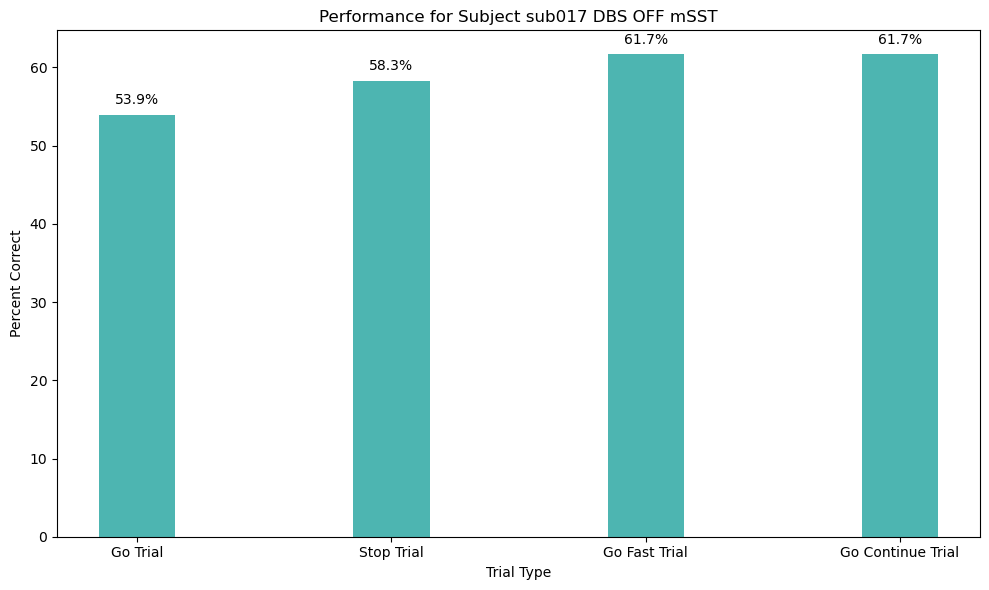

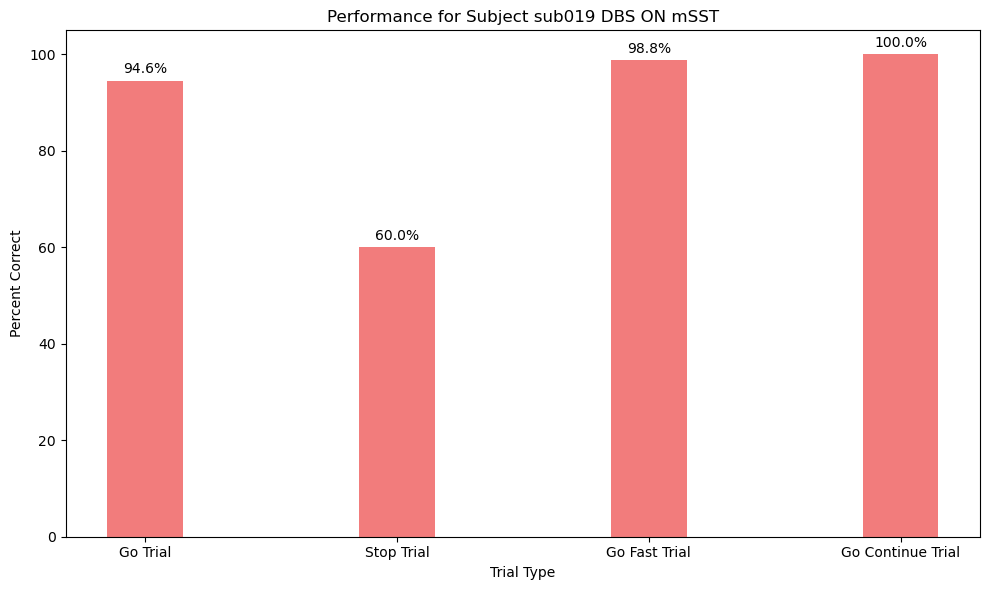

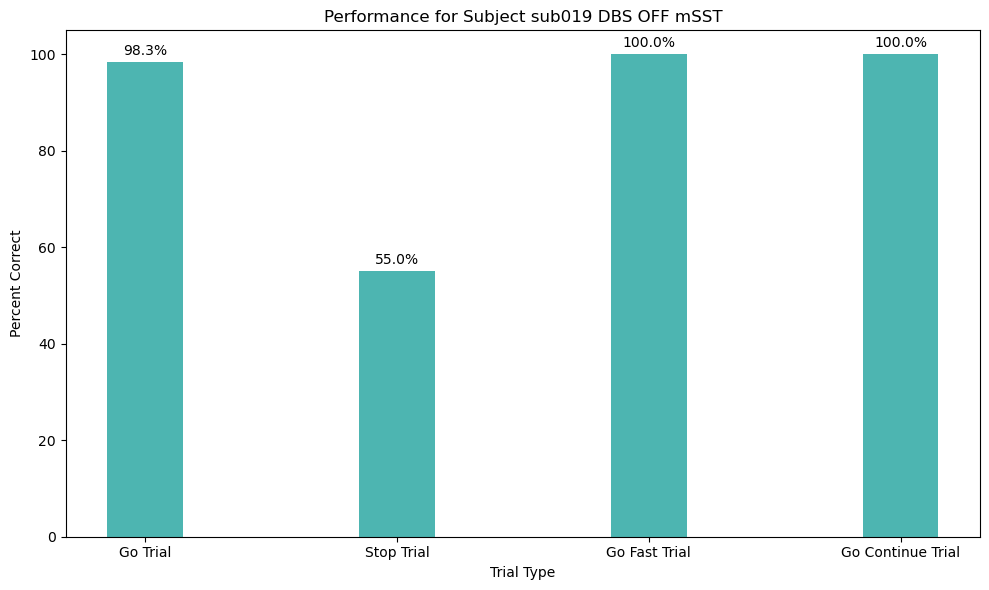

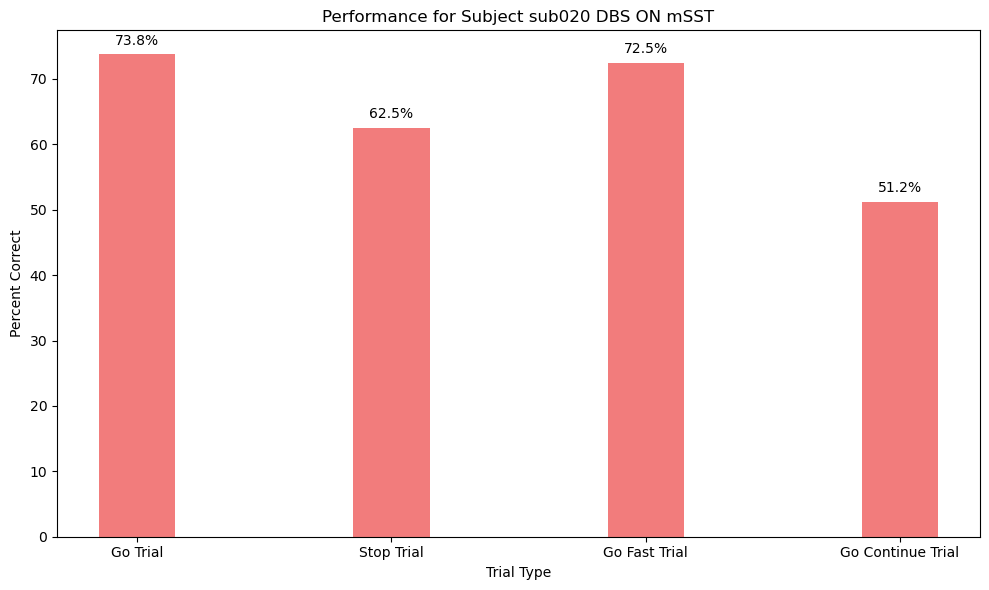

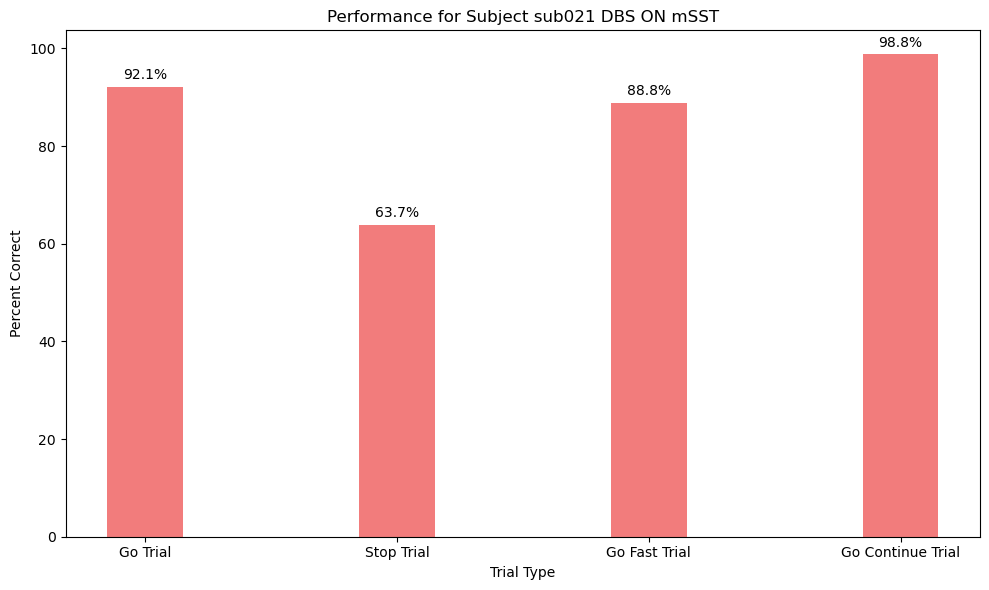

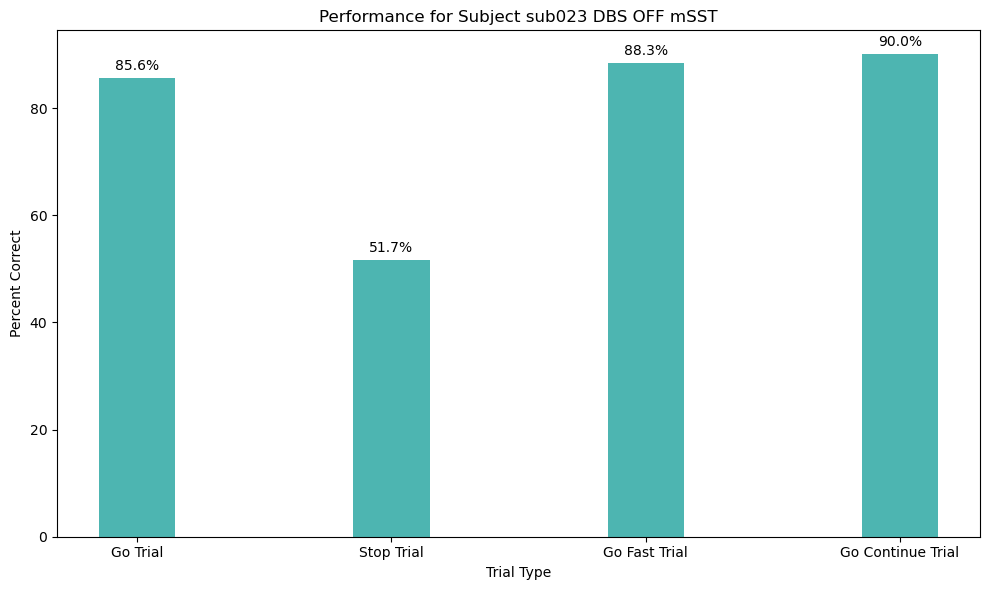

In [53]:
# Define trial types and bar width
trial_types = ['go_trial', 'stop_trial', 'go_fast_trial', 'go_continue_trial']
bar_width = 0.3
index = np.arange(len(trial_types))
print(index)
opacity = 0.8

# Access data for a single subject 
for subject_id in single_subject.keys():
    # Retrieve values for each trial type

    if subject_id.startswith('C'):
        condition = 'control'
    elif subject_id.startswith('preop'):
        condition = 'preop'
    elif 'OFF' in subject_id:
        condition = 'dbs_off'
    elif 'ON' in subject_id:
        condition = 'dbs_on'

    values = single_subject[subject_id]
    results_dict[subject_id]['go success rate'] = values[0]
    results_dict[subject_id]['stop success rate'] = values[1]
    results_dict[subject_id]['go fast success rate'] = values[2]
    results_dict[subject_id]['go continue success rate'] = values[3]

    # Plot bars for each condition
    plt.figure(figsize=(10, 6))

    plt.bar(index, values, bar_width, alpha=opacity, color=color_dict[condition], label='control', capsize=5)

    for i, (val) in enumerate(values):
        plt.text(x=i, y=val + 1, s=f'{val:.1f}%', ha='center', va='bottom', color='black')

    # Add labels, title, and legend
    plt.xlabel('Trial Type')
    plt.ylabel('Percent Correct')
    plt.title(f'Performance for Subject {subject_id}')
    plt.xticks(index, ['Go Trial', 'Stop Trial', 'Go Fast Trial', 'Go Continue Trial'])
    #plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.tight_layout()
    plt.savefig(join(behav_results_saving_path, f"Performance for {subject_id}.png"))
    plt.show()

In [54]:
# Convert to DataFrame
df = pd.DataFrame.from_dict(results_dict, orient='index')

# Reset index and rename the first column to 'subject'
df.reset_index(inplace=True)
df.rename(columns={'index': 'subject'}, inplace=True)

# Display the DataFrame
print(df)

                subject independance test used  p-value independance  \
0         preop001 mSST    Mann-Whitney U test              0.999938   
1             C002 mSST    Mann-Whitney U test              0.955865   
2             C003 mSST    Mann-Whitney U test              0.918472   
3             C004 mSST    Mann-Whitney U test              0.999998   
4             C006 mSST    Mann-Whitney U test              0.987165   
5    sub006 DBS ON mSST    Mann-Whitney U test              0.950186   
6   sub006 DBS OFF mSST                 t-test              1.000000   
7   sub007 DBS OFF mSST    Mann-Whitney U test              0.998378   
8    sub008 DBS ON mSST    Mann-Whitney U test              0.999892   
9   sub008 DBS OFF mSST    Mann-Whitney U test              0.957765   
10   sub009 DBS ON mSST    Mann-Whitney U test              0.983582   
11  sub009 DBS OFF mSST    Mann-Whitney U test              0.493503   
12  sub011 DBS OFF mSST    Mann-Whitney U test              0.87

In [55]:
# Compute mean and standard deviation of "go success rate"
mean_go_success = df["go success rate"].mean()
std_go_success = df["go success rate"].std()
#threshold = mean_go_success - std_go_success
threshold = 75  # Use a threshold of 75% as reported in other papers

# Apply the inclusion criteria
df["included"] = df.apply(lambda row: "Yes" if (row["p-value independance"] > 0.1) and 
                                               (row["go success rate"] > threshold) else "No", axis=1)

# Save to an Excel file
df.to_excel(join(behav_results_saving_path,"output.xlsx"), index=False)

## reproducing one mode analysis from Mario Hervault et al 2021 ##
"In addition, due to the SSD increment procedure, the resulting p(respond|signal) must not differ from 0.50 to estimate the RT STOP value correctly (Verbruggen & Logan, 2008). This was the case for both the pressing (t(39) = 0.43, p > .50) and the swiping type (t(39) = 0.46, p > .50)."

They computed p(respond|signal) for each participant — that is, the number of failed STOP trials / total STOP trials — and then performed a one-sample t-test against the reference value 0.5.

t(13) = -5.09, p = 0.0002082880


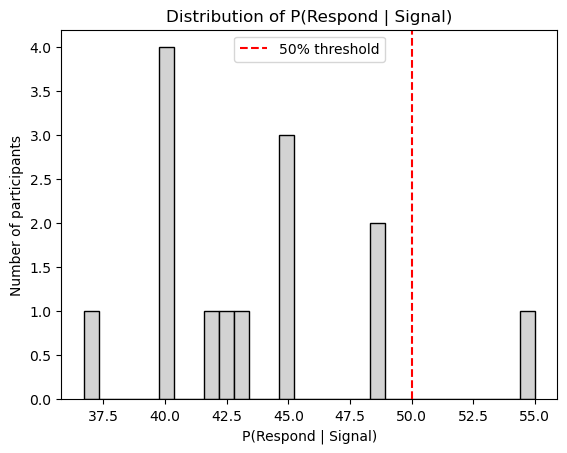

In [56]:
p_respond = []
for sub in final_included_subjects:
    p_respond.append(100-stats[sub]['percent correct stop_trial'])
# Test if the mean is different from 0.5
t_stat, p_val = scipy.stats.ttest_1samp(p_respond, popmean=50)

print(f"t({len(p_respond)-1}) = {t_stat:.2f}, p = {p_val:.10f}")
plt.hist(p_respond, bins=30, color='lightgray', edgecolor='black')
plt.axvline(x=50, color='red', linestyle='--', label='50% threshold')
plt.xlabel('P(Respond | Signal)')
plt.ylabel('Number of participants')
plt.title('Distribution of P(Respond | Signal)')
plt.legend()

# 4. Check that no inhibition is triggered by the "CONTINUE" signal #

Data appears normally distributed (p = 0.07617788997057216 )
Data does NOT appear normal (p = 0.02978707368704431 )


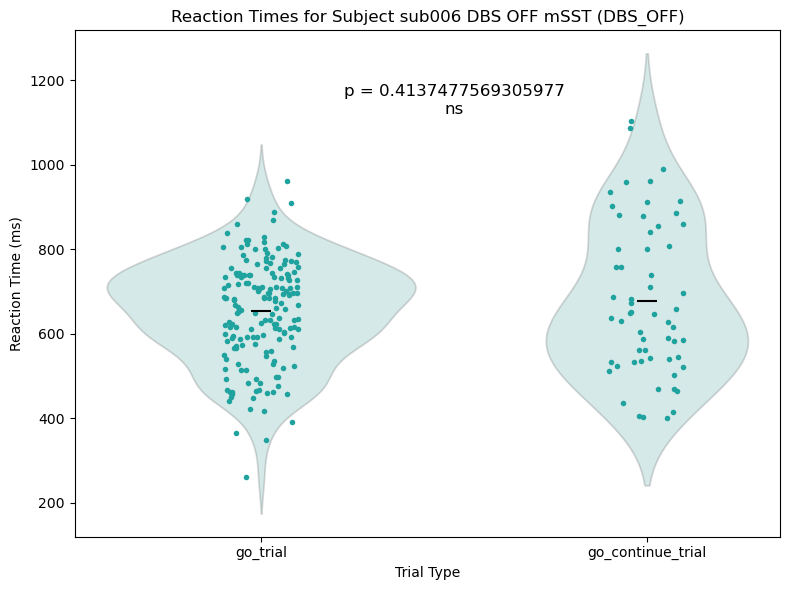

Data appears normally distributed (p = 0.14055015816537808 )
Data appears normally distributed (p = 0.9073397825526359 )


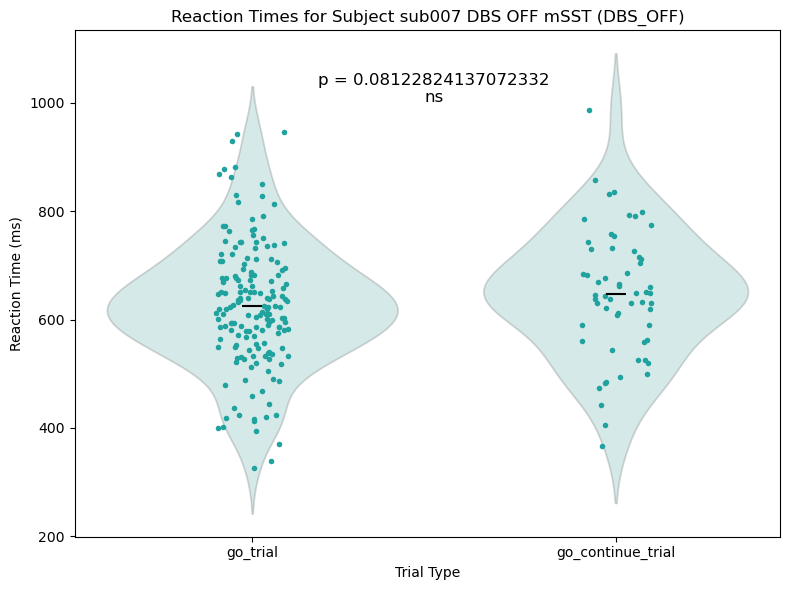

Data appears normally distributed (p = 0.07939002783384144 )
Data appears normally distributed (p = 0.42800543189693324 )


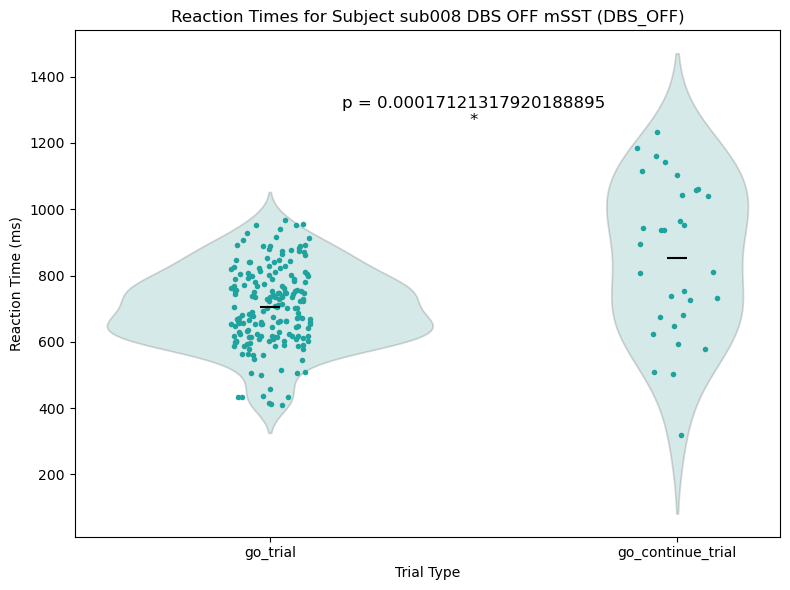

Data does NOT appear normal (p = 5.112222122237458e-07 )
Data appears normally distributed (p = 0.3292744199565466 )


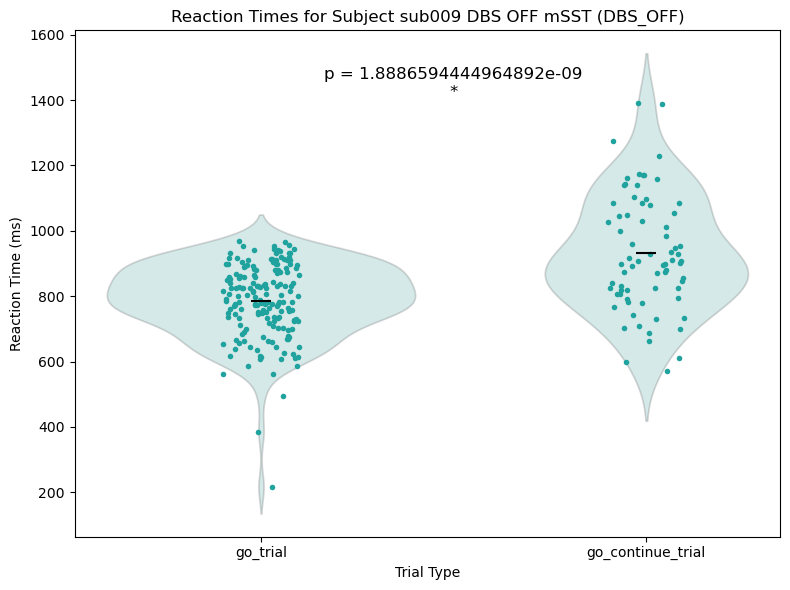

Data does NOT appear normal (p = 1.8176770307578436e-06 )
Data does NOT appear normal (p = 0.008767799825150118 )


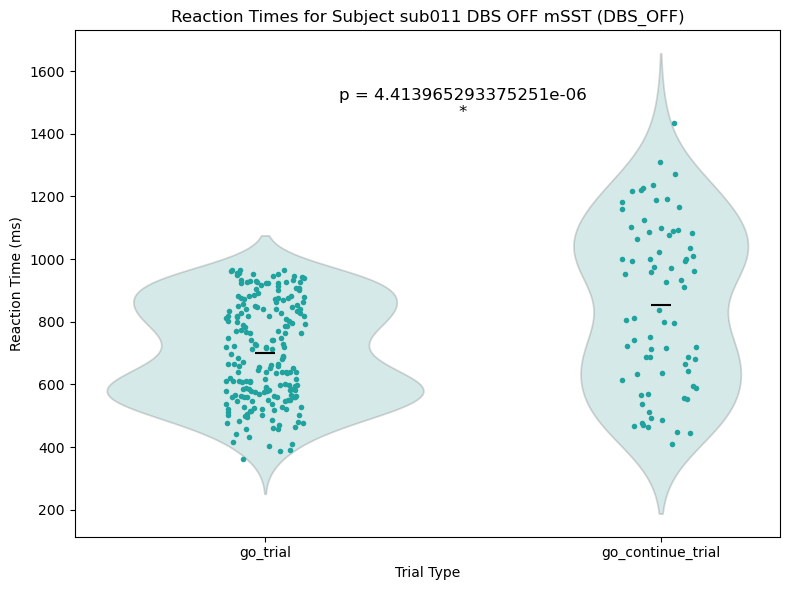

Data appears normally distributed (p = 0.7255241309609184 )
Data does NOT appear normal (p = 0.0013008026574195303 )


Data does NOT appear normal (p = 0.041018204832944404 )
Data appears normally distributed (p = 0.9904067617260414 )


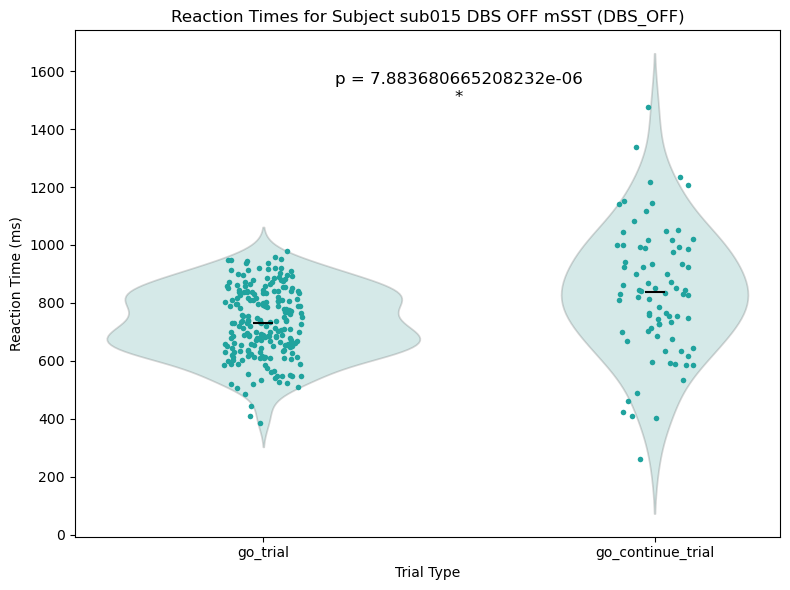

Data appears normally distributed (p = 0.4629863307793347 )
Data appears normally distributed (p = 0.9431234850970638 )


Data does NOT appear normal (p = 0.0005859001088569703 )
Data does NOT appear normal (p = 0.0011373264817383332 )


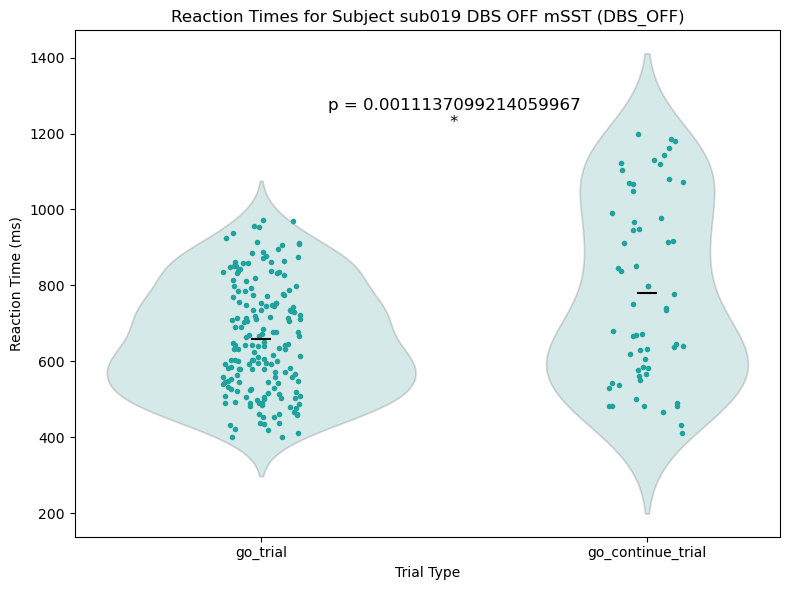

Data appears normally distributed (p = 0.3953036457263144 )
Data appears normally distributed (p = 0.12409611318216318 )


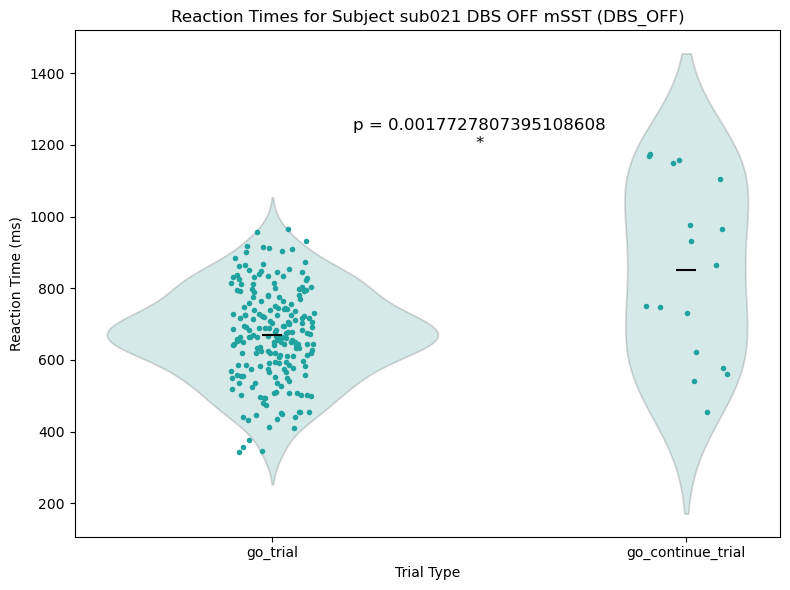

Data does NOT appear normal (p = 0.041694259417886986 )
Data does NOT appear normal (p = 0.01265353843986342 )


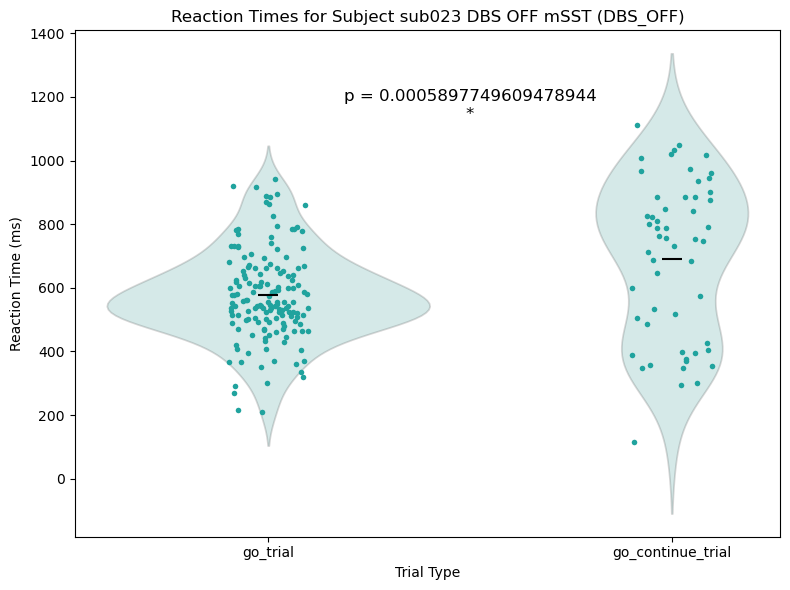

Data appears normally distributed (p = 0.07353018811052006 )
Data appears normally distributed (p = 0.07158109243353836 )


Data does NOT appear normal (p = 0.0007015879739467417 )
Data appears normally distributed (p = 0.3412174439979989 )


Data appears normally distributed (p = 0.36183461762735497 )
Data does NOT appear normal (p = 0.00019989882246236186 )


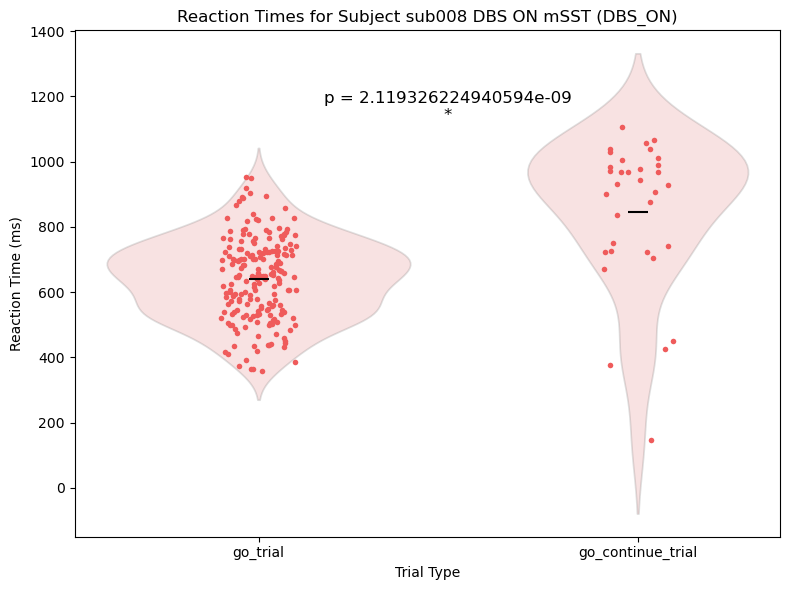

Data does NOT appear normal (p = 2.8373235894946426e-07 )
Data does NOT appear normal (p = 0.004839685471789312 )


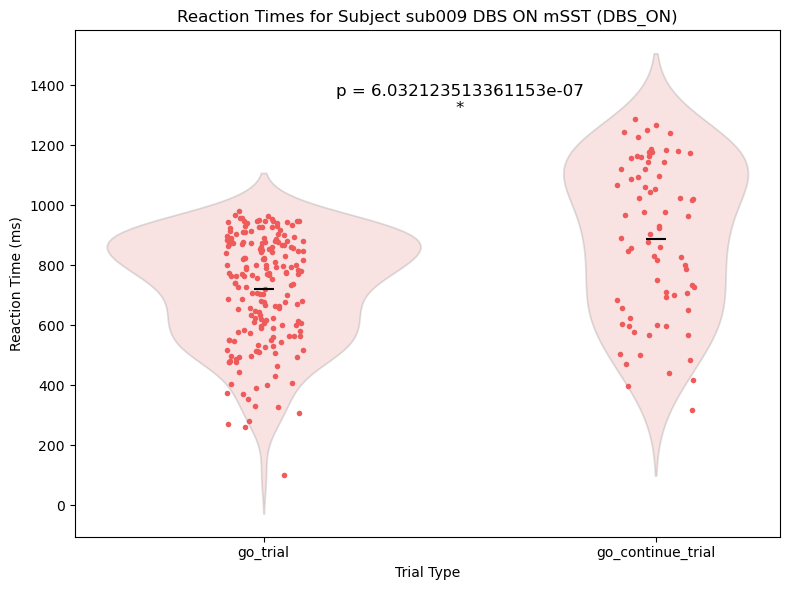

Data does NOT appear normal (p = 0.0017105454551751243 )
Data appears normally distributed (p = 0.3931061233214916 )


Data does NOT appear normal (p = 0.019149644284265983 )
Data appears normally distributed (p = 0.7799058593633106 )


Data does NOT appear normal (p = 0.020442550452619706 )
Data appears normally distributed (p = 0.08713999953913172 )


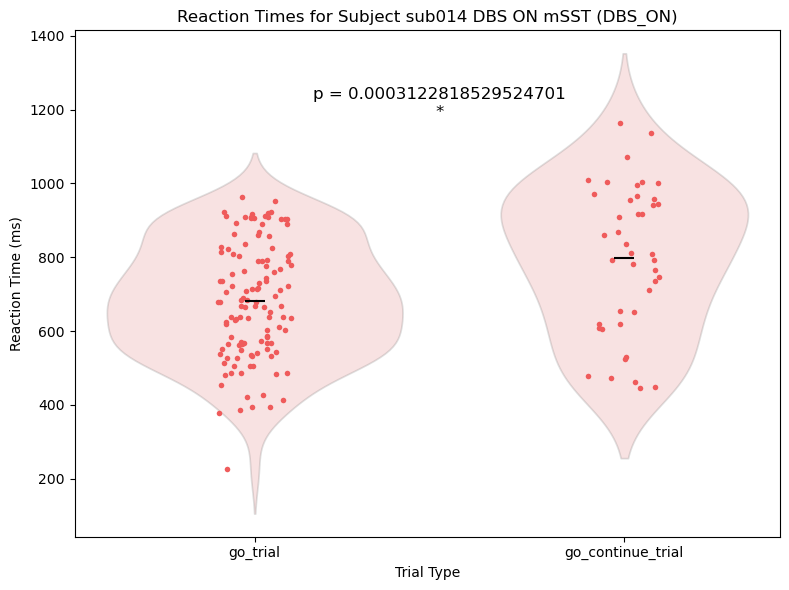

Data does NOT appear normal (p = 0.039900918243240505 )
Data appears normally distributed (p = 0.22628379636166812 )


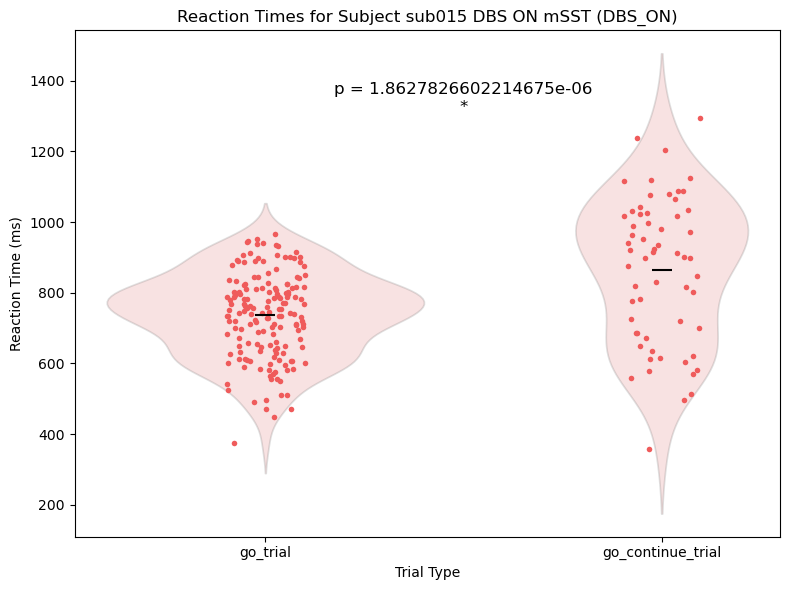

Data does NOT appear normal (p = 1.99354226264243e-08 )
Data does NOT appear normal (p = 0.0018211379785453119 )


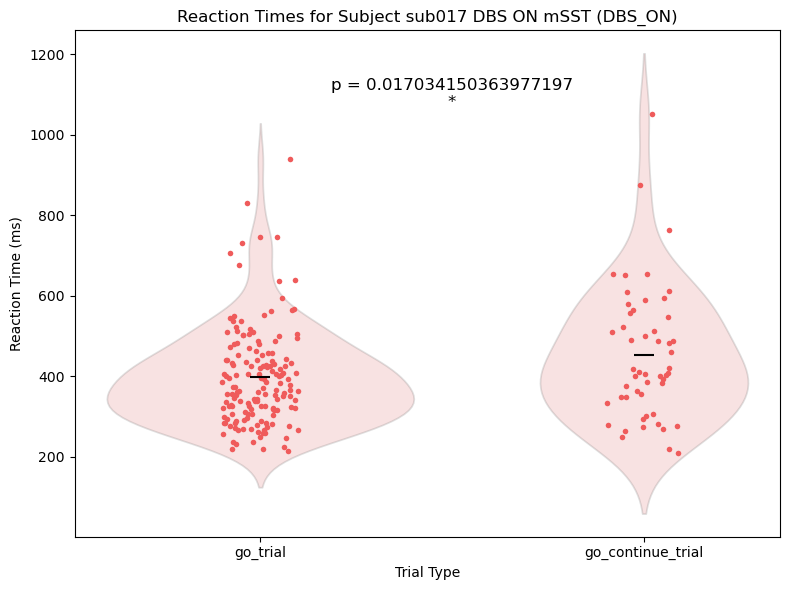

Data does NOT appear normal (p = 1.3134454402658662e-07 )
Data appears normally distributed (p = 0.176454171299266 )


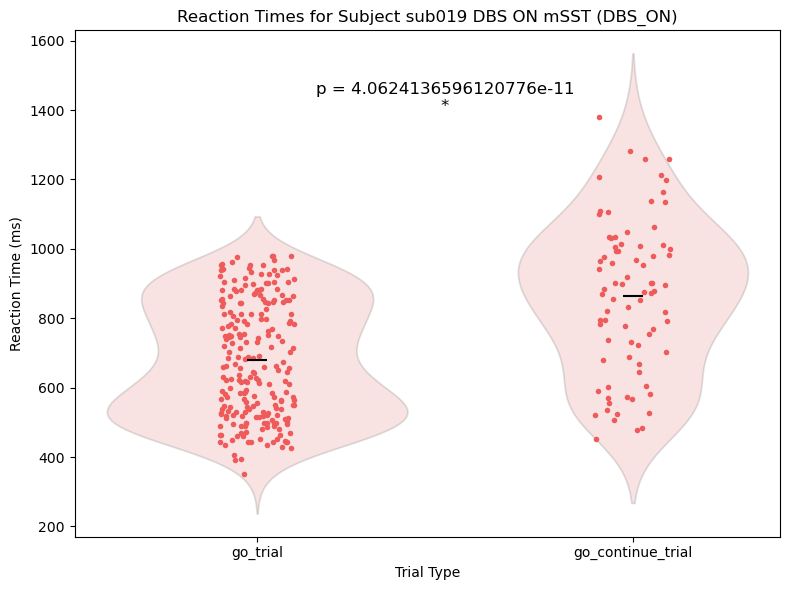

Data does NOT appear normal (p = 2.88836521046278e-05 )
Data appears normally distributed (p = 0.14927837736402272 )


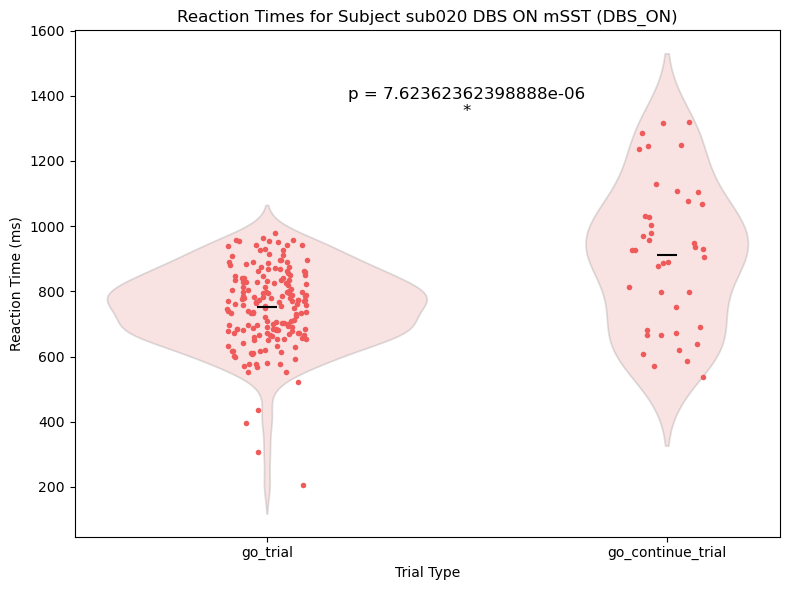

Data does NOT appear normal (p = 0.0001224343826400756 )
Data does NOT appear normal (p = 0.004575694983254823 )


Data appears normally distributed (p = 0.11234526292792457 )
Data does NOT appear normal (p = 0.0024591741076631633 )


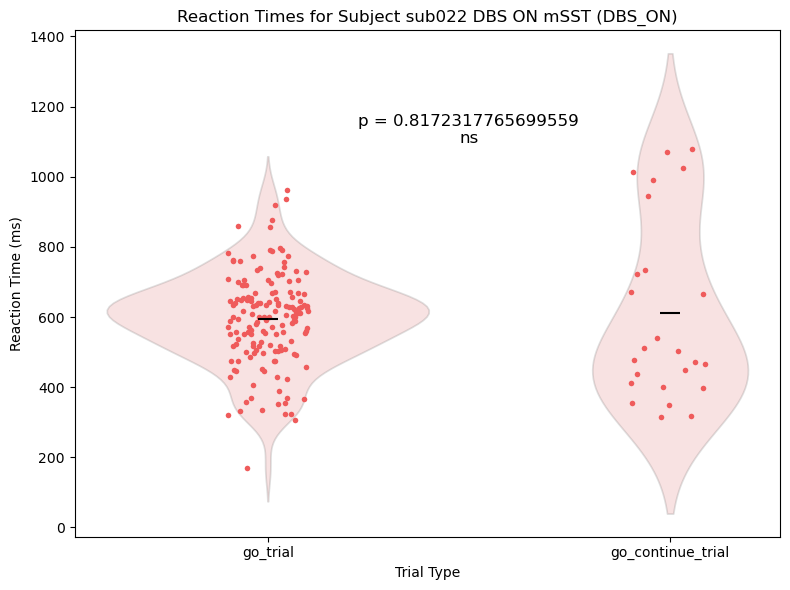

Data does NOT appear normal (p = 0.013673250468771776 )
Data appears normally distributed (p = 0.06892706335239394 )


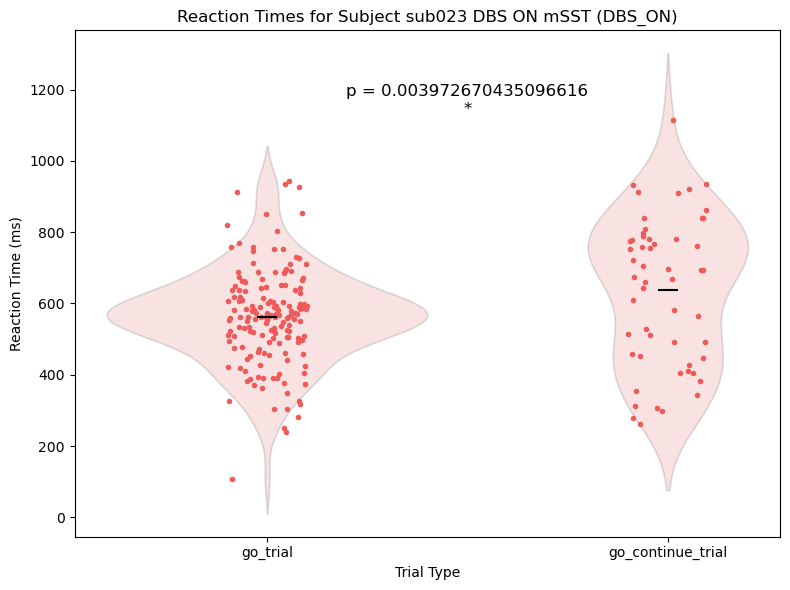

Data does NOT appear normal (p = 3.224264307304329e-05 )
Data does NOT appear normal (p = 0.01689643365437809 )


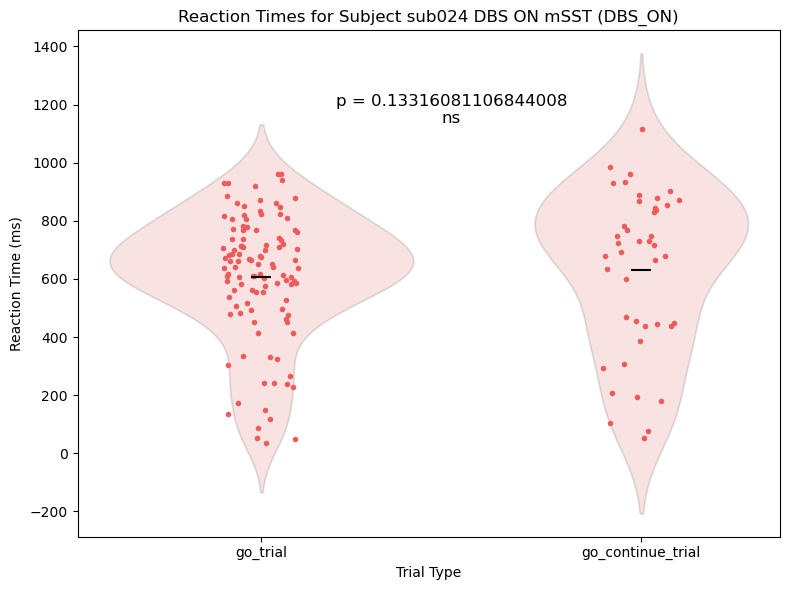

Data does NOT appear normal (p = 0.0001998569753707865 )
Data appears normally distributed (p = 0.18968777024815958 )


Data does NOT appear normal (p = 4.052927843415066e-07 )
Data appears normally distributed (p = 0.3963379256640921 )


Data does NOT appear normal (p = 8.226072155890689e-05 )
Data does NOT appear normal (p = 0.0015702576289061102 )


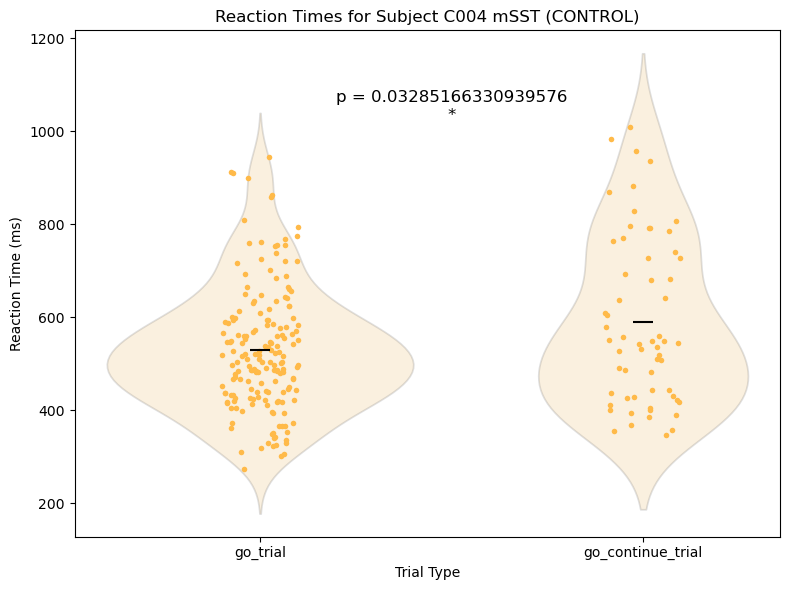

Data does NOT appear normal (p = 0.0007840367774146542 )
Data does NOT appear normal (p = 0.00029860539230493595 )


Data does NOT appear normal (p = 0.018857171232186245 )
Data does NOT appear normal (p = 0.004241154831878586 )


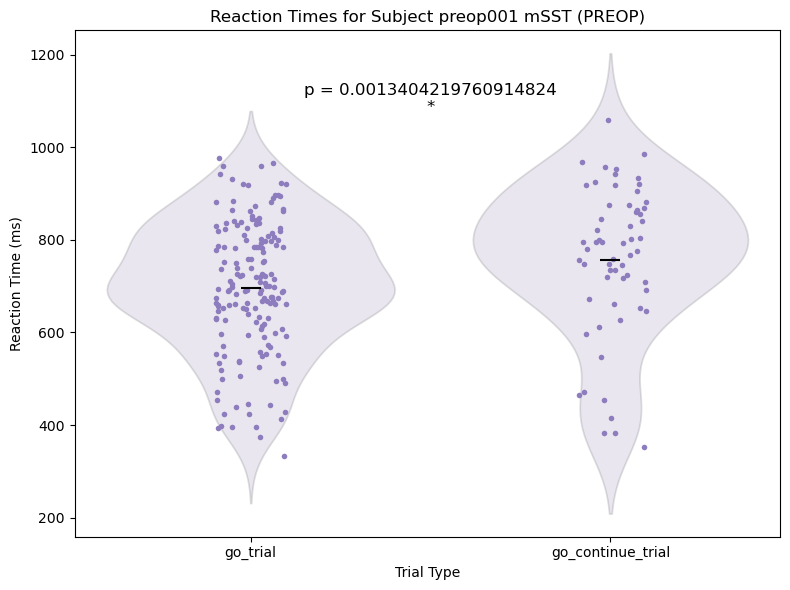

In [57]:
# Define trial types to include only go trials and stop_trials
trial_types = ['go_trial', 'go_continue_trial']


# Loop through the filtered dictionaries (e.g., stats_OFF, stats_ON, etc.)
for condition, condition_stats in [('dbs_off', stats_OFF), 
                                   ('dbs_on', stats_ON), 
                                   ('control', stats_CONTROL), 
                                   ('preop', stats_PREOP)]:
    for subject_id, subject_data in condition_stats.items():
        # Gather data for the selected trial types into a DataFrame
        data = []
        for trial_type in trial_types:
            if f"{trial_type} RTs (ms)" in subject_data:  # Ensure the trial type key exists
                data.extend([(trial_type, val) for val in subject_data[f"{trial_type} RTs (ms)"]])

        df = pd.DataFrame(data, columns=['Trial Type', 'Reaction Time'])

        # Extract reaction times for statistical comparison
        go_data = df[df['Trial Type'] == 'go_trial']['Reaction Time']
        go_continue_data = df[df['Trial Type'] == 'go_continue_trial']['Reaction Time']

        # Test for normality:
        stat, p = scipy.stats.shapiro(go_data)
        if p > 0.05:
            print("Data appears normally distributed (p =", p, ")")
        else:
            print("Data does NOT appear normal (p =", p, ")")

        stat, p = scipy.stats.shapiro(go_continue_data)
        if p > 0.05:
            print("Data appears normally distributed (p =", p, ")")
        else:
            print("Data does NOT appear normal (p =", p, ")")    

        # Data is not normal, use non-parametric test (mann whitney)

        # Perform Mann-Whitney U test if both trial types have sufficient data
        if len(go_data) >= 2 and len(go_continue_data) >= 2:  # Minimum data size for test
            stat, p_value = scipy.stats.mannwhitneyu(go_continue_data, go_data, alternative='greater')
        else:
            p_value = None  # Not enough data to perform test

        # Initialize the plot
        plt.figure(figsize=(8, 6))

        # Plot violins for the single condition using the custom palette
        sns.violinplot(data=df, x='Trial Type', y='Reaction Time', 
                       inner=None, color=color_dict[condition], alpha=0.2)  # Use condition color

        # Overlay data points with a strip plot
        sns.stripplot(data=df, x='Trial Type', y='Reaction Time', 
                      jitter=True, color=color_dict[condition], marker='o', size=4)

        # Calculate and plot means manually for each trial type
        for i, trial_type in enumerate(trial_types):
            condition_data = df[df['Trial Type'] == trial_type]
            mean_value = condition_data['Reaction Time'].mean()
            plt.scatter(x=i, y=mean_value, color='black', marker="_", s=200, label='Mean' if i == 0 else "", zorder=5)

        # Annotate statistical results
        if p_value is not None:
            annotation = "ns" if p_value >= 0.05 else "*"
            max_val = df['Reaction Time'].max()
            plt.text(0.5, max_val + 10, f"p = {p_value}\n{annotation}", 
                     ha='center', va='bottom', color='black', fontsize=12)

        # Customize plot
        plt.xlabel('Trial Type')
        plt.ylabel('Reaction Time (ms)')
        plt.title(f'Reaction Times for Subject {subject_id} ({condition.upper()})')
        plt.tight_layout()

        plt.savefig(join(behav_results_saving_path, f"Go continue triggered inhibition {subject_id}.png"))
        plt.show()